# Performing sentiment analysis on the yelp reviews dataset using a fine-tuned DistilBERT model.

This notebook is an implementation of a sentiment analysis performed on a cleaned version of the [Yelp dataset](https://huggingface.co/datasets/noahnsimbe/yelp-dataset). 
It contains model development, hyperparameter tuning, evaluation and analysis of performance. 

- [Information about the base model](https://huggingface.co/docs/transformers/model_doc/distilbert)
- [Information about ray use cases](https://docs.ray.io/en/latest/ray-overview/use-cases.html)
- [Ray tuning example](https://docs.ray.io/en/latest/train/examples/transformers/huggingface_text_classification.html)
- [Training](https://huggingface.co/docs/transformers/en/training)


## Set up a ray cluster

Change `--num-cpus` to match CPUs on each machine

### Start the Head node
```shell
ray start --head --port=7374 --num-cpus=24
```

### Start Worker Nodes
```shell
ray start --address=<head-node-address:port> --num-cpus=24
```

### View Dashboard
```shell
ray dashboard
```

## Installing required packages

In [1]:
! export RAY_PICKLE_VERBOSE_DEBUG='2'
! export RAY_AIR_NEW_OUTPUT='1'
# ! export RAY_ADDRESS="http://127.0.0.1:8265"

In [2]:
! pip install -U -q datasets "transformers[torch]" "ray[tune]" evaluate scikit-learn seaborn

## Importing required packages

In [37]:
%%time
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import (
    AutoTokenizer,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW
import numpy as np
from huggingface_hub import notebook_login
from ray import tune
import ray
import evaluate
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
from typing import Tuple, Dict
from datasets import load_dataset
from transformers import (pipeline)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

CPU times: user 228 µs, sys: 4 µs, total: 232 µs
Wall time: 243 µs


In [4]:
base_model_checkpoint = "distilbert-base-uncased"
model_checkpoint = "noahnsimbe/DistilBERT-yelp-sentiment-analysis"
batch_size = 8
dataset_checkpoint = "noahnsimbe/yelp-dataset"
data_fraction = 0.05
num_train_epochs = 10
RAY_ADDRESS = os.getenv("RAY_ADDRESS")

## Data Loading

In [5]:
%%time
data = load_dataset(dataset_checkpoint)

CPU times: user 291 ms, sys: 62.7 ms, total: 354 ms
Wall time: 4.67 s


## Data Preprocessing

### Using a fraction of the data
Due to resource limitations, we shall use 0.1 of the train, test and evaluation dataset.

In [6]:
def filter_data(dataset):
    negative_reviews = dataset.filter(lambda review: review['label'] == 0)
    neutral_reviews = dataset.filter(lambda review: review['label'] == 1)
    positive_reviews = dataset.filter(lambda review: review['label'] == 2)

    negative_reviews = negative_reviews.train_test_split(train_size=data_fraction)["train"]
    neutral_reviews = neutral_reviews.train_test_split(train_size=data_fraction)["train"]
    positive_reviews = positive_reviews.train_test_split(train_size=data_fraction)["train"]

    return concatenate_datasets([negative_reviews, neutral_reviews, positive_reviews]).shuffle(seed=42)

In [7]:
train_data = filter_data(data["train"])
test_data = filter_data(data["test"])
eval_data = filter_data(data["eval"])

### Creating tokenizer from the pre-trained DistilBERT model

In [8]:
tokenizer = AutoTokenizer.from_pretrained(base_model_checkpoint)

In [9]:
def tokenize_review(review: Dict) -> Dict:
    """
    Tokenizes the text in a given review text using the tokenizer with truncation.

    Args:
        record (dict): A dictionary containing the text to be tokenized under the key "text".

    Returns:
        dict: A dictionary containing the tokenized text.
    """
    return tokenizer(review["text"], truncation=True)

### Tokenize the text using the tokenizer with truncation

In [10]:
%%time
tokenized_train_data = train_data.map(tokenize_review, batched=True)
tokenized_test_data = test_data.map(tokenize_review, batched=True)
tokenized_eval_data = eval_data.map(tokenize_review, batched=True)

train_dataset = Dataset.from_list(tokenized_train_data)
test_dataset = Dataset.from_list(tokenized_test_data)
eval_dataset = Dataset.from_list(tokenized_eval_data)

Map:   0%|          | 0/6170 [00:00<?, ? examples/s]

Map:   0%|          | 0/770 [00:00<?, ? examples/s]

Map:   0%|          | 0/770 [00:00<?, ? examples/s]

CPU times: user 6.98 s, sys: 499 ms, total: 7.47 s
Wall time: 4.88 s


### Creating the DataCollatorWithPadding object

In [11]:
%%time

# Converts the training reviews to PyTorch tensors and concatenate them with the correct amount of padding to speed up training
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

CPU times: user 12 µs, sys: 4 µs, total: 16 µs
Wall time: 18.8 µs


## Model Development

### Load pre-trained model for sequence classification

In [12]:
%%time
model = AutoModelForSequenceClassification.from_pretrained(
    base_model_checkpoint, num_labels=3
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 581 ms, sys: 660 ms, total: 1.24 s
Wall time: 279 ms


### Define the metrics to evaluate the model

In [13]:
def compute_metrics(eval_pred: Tuple) -> Dict[str, float]:
    """
    Compute various evaluation metrics such as accuracy, F1 score, precision, and recall.

    Args:
        eval_pred (tuple): A tuple containing the model predictions (logits) and the ground truth labels.

    Returns:
        dict: A dictionary containing computed evaluation metrics (accuracy, F1 score, precision, and recall).
    """
        
    load_accuracy = evaluate.load("accuracy", trust_remote_code=True)
    load_f1 = evaluate.load("f1", trust_remote_code=True)
    load_precision = evaluate.load("precision", trust_remote_code=True)
    load_recall = evaluate.load("recall", trust_remote_code=True)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)[
        "accuracy"
    ]
    f1 = load_f1.compute(predictions=predictions, references=labels, average="macro")[
        "f1"
    ]
    precision = load_precision.compute(
        predictions=predictions, references=labels, average="macro", zero_division=0
    )["precision"]
    recall = load_recall.compute(
        predictions=predictions, references=labels, average="macro"
    )["recall"]
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

### Define training arguments for the model training process

In [14]:
notebook_login()

In [15]:
training_args = TrainingArguments(
    output_dir=model_checkpoint,
    learning_rate=2e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    push_to_hub=True,
    use_cpu=True,
)

### Define the optimizer and learning rate scheduler

In [16]:
optimizer = AdamW(model.parameters(), lr=5e-5)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataset) * training_args.num_train_epochs,
)

### Define the Trainer for model training

In [17]:
model_trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    optimizers=(optimizer, lr_scheduler),
)

/home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Train the model

In [16]:
%%time
model_trainer.train()

CPU times: user 17h 43min 11s, sys: 19min 5s, total: 18h 2min 17s
Wall time: 1h 33min 29s


TrainOutput(global_step=7720, training_loss=0.18452841210241763, metrics={'train_runtime': 5584.3678, 'train_samples_per_second': 11.049, 'train_steps_per_second': 1.382, 'total_flos': 2614266413188452.0, 'train_loss': 0.18452841210241763, 'epoch': 10.0})

### Observation

The model's performance improves over the epochs in terms of loss reduction and validation metrics such as accuracy, F1 score, precision, and recall. However, there are fluctuations in the metrics across epochs, indicating possible overfitting or instability in training.

## Model Evaluation

### Evalute the model

In [28]:
%%time
model_trainer.evaluate(eval_dataset=eval_dataset)

CPU times: user 3min 25s, sys: 1.88 s, total: 3min 27s
Wall time: 19.3 s


{'eval_loss': 0.4802529215812683,
 'eval_accuracy': 0.8298701298701299,
 'eval_f1': 0.6262787850061224,
 'eval_precision': 0.6756062343232129,
 'eval_recall': 0.6341881589681134,
 'eval_runtime': 19.2559,
 'eval_samples_per_second': 39.988,
 'eval_steps_per_second': 5.037,
 'epoch': 10.0}

In [29]:
model_pipeline = pipeline("text-classification", model=model_trainer.model, tokenizer=tokenizer)

In [30]:
%%time
predictions = model_pipeline(eval_dataset["text"])
y_test = eval_dataset["label"]

CPU times: user 4min 25s, sys: 102 ms, total: 4min 25s
Wall time: 22.1 s


In [31]:
label_mapping = {
    'LABEL_0': 0,
    'LABEL_1': 1,
    'LABEL_2': 2
}
class_labels = ["Negative", "Neutral", "Positive"]

### Generate predictions and evaluation metrics.

In [32]:
y_pred = list(map(lambda x: label_mapping[x['label']], predictions))
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=class_labels)

### Classification report

In [33]:
print(f"Classification Report:\n{classification_rep}")

Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.85      0.80       183
     Neutral       0.39      0.11      0.17        85
    Positive       0.87      0.94      0.91       502

    accuracy                           0.83       770
   macro avg       0.68      0.63      0.63       770
weighted avg       0.79      0.83      0.80       770



### Confusion Matrix

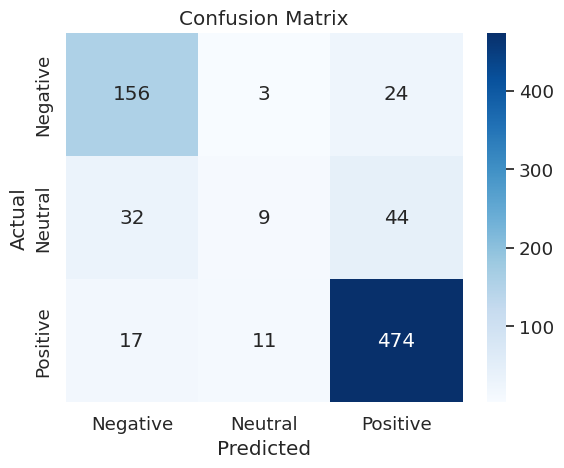

In [34]:
sns.set(font_scale=1.2)
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Observation

The model's performance improves over the epochs in terms of loss reduction and validation metrics such as accuracy, F1 score, precision, and recall. However, there are fluctuations in the metrics across epochs, indicating possible overfitting or instability in training. 

### Updating Hub

In [35]:
model_trainer.push_to_hub()

events.out.tfevents.1713288960.ad-dl:   0%|          | 0.00/984 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/noahnsimbe/DistilBERT-yelp-sentiment-analysis/commit/2818af7df821d8176a4c0d2b00c4508ade741ecb', commit_message='End of training', commit_description='', oid='2818af7df821d8176a4c0d2b00c4508ade741ecb', pr_url=None, pr_revision=None, pr_num=None)

## Hyperparameter Tuning

In [18]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        base_model_checkpoint, num_labels=3, return_dict=True
    )

In [19]:
hp_trainer = Trainer(
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    model_init=model_init,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
def ray_hp_space(_):
    return {
        "learning_rate": tune.loguniform(1e-6, 1e-4),
        "per_device_train_batch_size": tune.choice([2, 4, 8]),
        "per_device_eval_batch_size": tune.choice([4, 8]),
        "weight_decay": tune.choice([0.001, 0.01, 0.1]),
        "num_train_epochs": tune.choice([2, 3, 4]),
    }

In [21]:
setattr(hp_trainer.args, "push_to_hub", False)

In [22]:
%%time
# ray.init()
# ray.init(f"ray://{RAY_ADDRESS}")
results = hp_trainer.hyperparameter_search(
    direction="maximize",
    backend="ray",
    hp_space=ray_hp_space,
    resources_per_trial={"cpu": 24},
    n_trials=4,
)
ray.shutdown()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

== Status ==
Current time: 2024-04-16 19:15:33 (running for 00:00:00.15)
Using FIFO scheduling algorithm.
Logical resource usage: 0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (4 PENDING)
+------------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |       |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+-------+-----------------+--------------------+------------------------+------------------------+----------------|
| _objective_b2a5e_00000 | PENDING  |       |     5.61152e-06 |  

(_objective pid=12768) /home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
(_objective pid=12768) dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
(_objective pid=12768)   warnings.warn(
(_objective pid=12768) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
(_objective pid=12768) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|        

== Status ==
Current time: 2024-04-16 19:15:38 (running for 00:00:05.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  0%|          | 18/6170 [00:05<24:50,  4.13it/s]


== Status ==
Current time: 2024-04-16 19:15:43 (running for 00:00:10.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  1%|          | 38/6170 [00:10<24:34,  4.16it/s]


== Status ==
Current time: 2024-04-16 19:15:48 (running for 00:00:15.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  1%|          | 57/6170 [00:15<27:39,  3.68it/s]


== Status ==
Current time: 2024-04-16 19:15:54 (running for 00:00:20.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  1%|▏         | 79/6170 [00:20<24:01,  4.23it/s]


== Status ==
Current time: 2024-04-16 19:15:59 (running for 00:00:25.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  2%|▏         | 101/6170 [00:25<24:57,  4.05it/s]


== Status ==
Current time: 2024-04-16 19:16:04 (running for 00:00:30.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  2%|▏         | 122/6170 [00:30<24:20,  4.14it/s]


== Status ==
Current time: 2024-04-16 19:16:09 (running for 00:00:35.63)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  2%|▏         | 144/6170 [00:35<25:50,  3.89it/s]


== Status ==
Current time: 2024-04-16 19:16:14 (running for 00:00:40.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  3%|▎         | 164/6170 [00:40<24:06,  4.15it/s]


== Status ==
Current time: 2024-04-16 19:16:19 (running for 00:00:45.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  3%|▎         | 185/6170 [00:45<23:03,  4.33it/s]


== Status ==
Current time: 2024-04-16 19:16:24 (running for 00:00:50.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  3%|▎         | 204/6170 [00:50<25:59,  3.83it/s]


== Status ==
Current time: 2024-04-16 19:16:29 (running for 00:00:55.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  4%|▎         | 224/6170 [00:55<22:32,  4.40it/s]


== Status ==
Current time: 2024-04-16 19:16:34 (running for 00:01:00.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  4%|▍         | 244/6170 [01:00<26:40,  3.70it/s]


== Status ==
Current time: 2024-04-16 19:16:39 (running for 00:01:06.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  4%|▍         | 265/6170 [01:05<23:58,  4.11it/s]


== Status ==
Current time: 2024-04-16 19:16:44 (running for 00:01:11.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  5%|▍         | 286/6170 [01:10<26:21,  3.72it/s]


== Status ==
Current time: 2024-04-16 19:16:49 (running for 00:01:16.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  5%|▍         | 305/6170 [01:15<24:44,  3.95it/s]


== Status ==
Current time: 2024-04-16 19:16:54 (running for 00:01:21.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  5%|▌         | 326/6170 [01:21<22:00,  4.43it/s]


== Status ==
Current time: 2024-04-16 19:16:59 (running for 00:01:26.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  6%|▌         | 348/6170 [01:26<24:19,  3.99it/s]


== Status ==
Current time: 2024-04-16 19:17:05 (running for 00:01:31.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  6%|▌         | 369/6170 [01:31<20:21,  4.75it/s]


== Status ==
Current time: 2024-04-16 19:17:10 (running for 00:01:36.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  6%|▋         | 391/6170 [01:36<22:59,  4.19it/s]


== Status ==
Current time: 2024-04-16 19:17:15 (running for 00:01:41.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  7%|▋         | 412/6170 [01:41<22:19,  4.30it/s]


== Status ==
Current time: 2024-04-16 19:17:20 (running for 00:01:46.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  7%|▋         | 431/6170 [01:46<30:59,  3.09it/s]


== Status ==
Current time: 2024-04-16 19:17:25 (running for 00:01:51.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  7%|▋         | 451/6170 [01:51<22:37,  4.21it/s]


== Status ==
Current time: 2024-04-16 19:17:30 (running for 00:01:56.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  8%|▊         | 471/6170 [01:56<23:41,  4.01it/s]


== Status ==
Current time: 2024-04-16 19:17:35 (running for 00:02:01.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  8%|▊         | 491/6170 [02:01<27:27,  3.45it/s]


== Status ==
Current time: 2024-04-16 19:17:40 (running for 00:02:06.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  8%|▊         | 499/6170 [02:03<24:24,  3.87it/s]


(_objective pid=12768) {'loss': 0.7703, 'grad_norm': 1.6364059448242188, 'learning_rate': 5.1567744043673694e-06, 'epoch': 0.16}


  8%|▊         | 513/6170 [02:06<23:51,  3.95it/s]


== Status ==
Current time: 2024-04-16 19:17:45 (running for 00:02:11.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  9%|▊         | 534/6170 [02:11<23:28,  4.00it/s]


== Status ==
Current time: 2024-04-16 19:17:50 (running for 00:02:16.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  9%|▉         | 554/6170 [02:16<24:25,  3.83it/s]


== Status ==
Current time: 2024-04-16 19:17:55 (running for 00:02:22.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  9%|▉         | 573/6170 [02:21<25:38,  3.64it/s]


== Status ==
Current time: 2024-04-16 19:18:00 (running for 00:02:27.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 10%|▉         | 595/6170 [02:26<20:33,  4.52it/s]


== Status ==
Current time: 2024-04-16 19:18:05 (running for 00:02:32.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 10%|▉         | 614/6170 [02:31<22:50,  4.05it/s]


== Status ==
Current time: 2024-04-16 19:18:10 (running for 00:02:37.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 10%|█         | 634/6170 [02:37<23:48,  3.88it/s]


== Status ==
Current time: 2024-04-16 19:18:15 (running for 00:02:42.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 11%|█         | 654/6170 [02:42<24:13,  3.79it/s]


== Status ==
Current time: 2024-04-16 19:18:20 (running for 00:02:47.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 11%|█         | 673/6170 [02:47<23:06,  3.96it/s]


== Status ==
Current time: 2024-04-16 19:18:26 (running for 00:02:52.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 11%|█▏        | 695/6170 [02:52<20:36,  4.43it/s]


== Status ==
Current time: 2024-04-16 19:18:31 (running for 00:02:57.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 12%|█▏        | 714/6170 [02:57<21:06,  4.31it/s]


== Status ==
Current time: 2024-04-16 19:18:36 (running for 00:03:02.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 12%|█▏        | 734/6170 [03:02<27:55,  3.24it/s]


== Status ==
Current time: 2024-04-16 19:18:41 (running for 00:03:07.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 12%|█▏        | 754/6170 [03:07<23:10,  3.89it/s]


== Status ==
Current time: 2024-04-16 19:18:46 (running for 00:03:12.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 13%|█▎        | 773/6170 [03:12<30:10,  2.98it/s]


== Status ==
Current time: 2024-04-16 19:18:51 (running for 00:03:17.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 13%|█▎        | 791/6170 [03:17<25:15,  3.55it/s]


== Status ==
Current time: 2024-04-16 19:18:56 (running for 00:03:22.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 13%|█▎        | 811/6170 [03:22<23:05,  3.87it/s]


== Status ==
Current time: 2024-04-16 19:19:01 (running for 00:03:27.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 13%|█▎        | 832/6170 [03:27<21:02,  4.23it/s]


== Status ==
Current time: 2024-04-16 19:19:06 (running for 00:03:32.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 14%|█▍        | 853/6170 [03:32<19:12,  4.61it/s]


== Status ==
Current time: 2024-04-16 19:19:11 (running for 00:03:38.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 14%|█▍        | 874/6170 [03:37<22:13,  3.97it/s]


== Status ==
Current time: 2024-04-16 19:19:16 (running for 00:03:43.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 14%|█▍        | 892/6170 [03:42<21:44,  4.04it/s]


== Status ==
Current time: 2024-04-16 19:19:21 (running for 00:03:48.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 15%|█▍        | 912/6170 [03:47<19:22,  4.52it/s]


== Status ==
Current time: 2024-04-16 19:19:26 (running for 00:03:53.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 15%|█▌        | 932/6170 [03:53<24:55,  3.50it/s]


== Status ==
Current time: 2024-04-16 19:19:31 (running for 00:03:58.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 15%|█▌        | 953/6170 [03:58<22:11,  3.92it/s]


== Status ==
Current time: 2024-04-16 19:19:36 (running for 00:04:03.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 16%|█▌        | 972/6170 [04:03<22:38,  3.83it/s]


== Status ==
Current time: 2024-04-16 19:19:42 (running for 00:04:08.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 16%|█▌        | 994/6170 [04:08<23:36,  3.65it/s]


== Status ==
Current time: 2024-04-16 19:19:47 (running for 00:04:13.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 16%|█▌        | 999/6170 [04:09<24:06,  3.58it/s]


(_objective pid=12768) {'loss': 0.7376, 'grad_norm': 0.23964135348796844, 'learning_rate': 4.70203239340023e-06, 'epoch': 0.32}


 16%|█▋        | 1012/6170 [04:13<23:36,  3.64it/s]


== Status ==
Current time: 2024-04-16 19:19:52 (running for 00:04:18.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 17%|█▋        | 1030/6170 [04:18<24:43,  3.47it/s]


== Status ==
Current time: 2024-04-16 19:19:57 (running for 00:04:23.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 17%|█▋        | 1050/6170 [04:23<19:01,  4.49it/s]


== Status ==
Current time: 2024-04-16 19:20:02 (running for 00:04:28.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 17%|█▋        | 1068/6170 [04:28<25:59,  3.27it/s]


== Status ==
Current time: 2024-04-16 19:20:07 (running for 00:04:33.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 18%|█▊        | 1085/6170 [04:33<22:28,  3.77it/s]


== Status ==
Current time: 2024-04-16 19:20:12 (running for 00:04:38.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 18%|█▊        | 1102/6170 [04:38<25:00,  3.38it/s]


== Status ==
Current time: 2024-04-16 19:20:17 (running for 00:04:43.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 18%|█▊        | 1118/6170 [04:43<24:31,  3.43it/s]


== Status ==
Current time: 2024-04-16 19:20:22 (running for 00:04:48.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 18%|█▊        | 1135/6170 [04:48<22:58,  3.65it/s]


== Status ==
Current time: 2024-04-16 19:20:27 (running for 00:04:54.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 19%|█▊        | 1153/6170 [04:53<25:14,  3.31it/s]


== Status ==
Current time: 2024-04-16 19:20:32 (running for 00:04:59.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 19%|█▉        | 1169/6170 [04:58<28:13,  2.95it/s]


== Status ==
Current time: 2024-04-16 19:20:37 (running for 00:05:04.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 19%|█▉        | 1186/6170 [05:03<22:34,  3.68it/s]


== Status ==
Current time: 2024-04-16 19:20:42 (running for 00:05:09.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 20%|█▉        | 1206/6170 [05:09<19:27,  4.25it/s]


== Status ==
Current time: 2024-04-16 19:20:47 (running for 00:05:14.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 20%|█▉        | 1226/6170 [05:14<19:20,  4.26it/s]


== Status ==
Current time: 2024-04-16 19:20:53 (running for 00:05:19.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 20%|██        | 1247/6170 [05:19<19:41,  4.17it/s]


== Status ==
Current time: 2024-04-16 19:20:58 (running for 00:05:24.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 21%|██        | 1265/6170 [05:24<22:29,  3.63it/s]


== Status ==
Current time: 2024-04-16 19:21:03 (running for 00:05:29.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 21%|██        | 1283/6170 [05:29<23:31,  3.46it/s]


== Status ==
Current time: 2024-04-16 19:21:08 (running for 00:05:34.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 21%|██        | 1299/6170 [05:34<36:46,  2.21it/s]


== Status ==
Current time: 2024-04-16 19:21:13 (running for 00:05:39.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 21%|██▏       | 1318/6170 [05:39<21:00,  3.85it/s]


== Status ==
Current time: 2024-04-16 19:21:18 (running for 00:05:44.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 22%|██▏       | 1337/6170 [05:44<24:20,  3.31it/s]


== Status ==
Current time: 2024-04-16 19:21:23 (running for 00:05:49.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 22%|██▏       | 1356/6170 [05:49<18:55,  4.24it/s]


== Status ==
Current time: 2024-04-16 19:21:28 (running for 00:05:54.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 22%|██▏       | 1376/6170 [05:54<19:32,  4.09it/s]


== Status ==
Current time: 2024-04-16 19:21:33 (running for 00:05:59.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 23%|██▎       | 1396/6170 [05:59<22:35,  3.52it/s]


== Status ==
Current time: 2024-04-16 19:21:38 (running for 00:06:04.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 23%|██▎       | 1411/6170 [06:04<22:20,  3.55it/s]


== Status ==
Current time: 2024-04-16 19:21:43 (running for 00:06:10.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 23%|██▎       | 1432/6170 [06:10<18:49,  4.19it/s]


== Status ==
Current time: 2024-04-16 19:21:48 (running for 00:06:15.13)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 24%|██▎       | 1451/6170 [06:15<19:58,  3.94it/s]


== Status ==
Current time: 2024-04-16 19:21:53 (running for 00:06:20.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 24%|██▍       | 1470/6170 [06:20<19:05,  4.10it/s]


== Status ==
Current time: 2024-04-16 19:21:58 (running for 00:06:25.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 24%|██▍       | 1488/6170 [06:25<24:03,  3.24it/s]


== Status ==
Current time: 2024-04-16 19:22:03 (running for 00:06:30.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 24%|██▍       | 1499/6170 [06:27<19:50,  3.92it/s]


(_objective pid=12768) {'loss': 0.8003, 'grad_norm': 0.23097801208496094, 'learning_rate': 4.24729038243309e-06, 'epoch': 0.49}


 24%|██▍       | 1507/6170 [06:30<23:50,  3.26it/s]


== Status ==
Current time: 2024-04-16 19:22:09 (running for 00:06:35.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 25%|██▍       | 1527/6170 [06:35<19:16,  4.01it/s]


== Status ==
Current time: 2024-04-16 19:22:14 (running for 00:06:40.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 25%|██▌       | 1547/6170 [06:40<19:57,  3.86it/s]


== Status ==
Current time: 2024-04-16 19:22:19 (running for 00:06:45.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 25%|██▌       | 1567/6170 [06:45<19:19,  3.97it/s]


== Status ==
Current time: 2024-04-16 19:22:24 (running for 00:06:50.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 26%|██▌       | 1587/6170 [06:50<18:57,  4.03it/s]


== Status ==
Current time: 2024-04-16 19:22:29 (running for 00:06:55.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 26%|██▌       | 1598/6170 [06:55<34:25,  2.21it/s]


== Status ==
Current time: 2024-04-16 19:22:34 (running for 00:07:00.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 26%|██▌       | 1619/6170 [07:00<19:53,  3.81it/s]


== Status ==
Current time: 2024-04-16 19:22:39 (running for 00:07:05.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 27%|██▋       | 1638/6170 [07:05<19:42,  3.83it/s]


== Status ==
Current time: 2024-04-16 19:22:44 (running for 00:07:10.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 27%|██▋       | 1658/6170 [07:10<20:03,  3.75it/s]


== Status ==
Current time: 2024-04-16 19:22:49 (running for 00:07:15.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 27%|██▋       | 1676/6170 [07:15<23:57,  3.13it/s]


== Status ==
Current time: 2024-04-16 19:22:54 (running for 00:07:20.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 27%|██▋       | 1696/6170 [07:20<19:25,  3.84it/s]


== Status ==
Current time: 2024-04-16 19:22:59 (running for 00:07:26.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 28%|██▊       | 1716/6170 [07:25<18:05,  4.10it/s]


== Status ==
Current time: 2024-04-16 19:23:04 (running for 00:07:31.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 28%|██▊       | 1736/6170 [07:30<21:29,  3.44it/s]


== Status ==
Current time: 2024-04-16 19:23:09 (running for 00:07:36.13)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 28%|██▊       | 1754/6170 [07:35<20:55,  3.52it/s]


== Status ==
Current time: 2024-04-16 19:23:14 (running for 00:07:41.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 29%|██▊       | 1773/6170 [07:41<21:29,  3.41it/s]


== Status ==
Current time: 2024-04-16 19:23:19 (running for 00:07:46.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 29%|██▉       | 1790/6170 [07:46<20:06,  3.63it/s]


== Status ==
Current time: 2024-04-16 19:23:24 (running for 00:07:51.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 29%|██▉       | 1810/6170 [07:51<18:43,  3.88it/s]


== Status ==
Current time: 2024-04-16 19:23:30 (running for 00:07:56.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 30%|██▉       | 1829/6170 [07:56<19:29,  3.71it/s]


== Status ==
Current time: 2024-04-16 19:23:35 (running for 00:08:01.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 30%|██▉       | 1850/6170 [08:01<16:22,  4.40it/s]


== Status ==
Current time: 2024-04-16 19:23:40 (running for 00:08:06.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 30%|███       | 1868/6170 [08:06<24:58,  2.87it/s]


== Status ==
Current time: 2024-04-16 19:23:45 (running for 00:08:11.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 31%|███       | 1887/6170 [08:11<19:44,  3.62it/s]


== Status ==
Current time: 2024-04-16 19:23:50 (running for 00:08:16.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 31%|███       | 1907/6170 [08:16<18:29,  3.84it/s]


== Status ==
Current time: 2024-04-16 19:23:55 (running for 00:08:21.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 31%|███       | 1928/6170 [08:21<17:48,  3.97it/s]


== Status ==
Current time: 2024-04-16 19:24:00 (running for 00:08:26.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 32%|███▏      | 1949/6170 [08:26<15:52,  4.43it/s]


== Status ==
Current time: 2024-04-16 19:24:05 (running for 00:08:31.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 32%|███▏      | 1969/6170 [08:31<17:57,  3.90it/s]


== Status ==
Current time: 2024-04-16 19:24:10 (running for 00:08:36.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 32%|███▏      | 1991/6170 [08:36<15:51,  4.39it/s]


== Status ==
Current time: 2024-04-16 19:24:15 (running for 00:08:42.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 32%|███▏      | 1999/6170 [08:38<18:40,  3.72it/s]


(_objective pid=12768) {'loss': 0.699, 'grad_norm': 109.40454864501953, 'learning_rate': 3.792548371465949e-06, 'epoch': 0.65}


 33%|███▎      | 2011/6170 [08:41<16:25,  4.22it/s]


== Status ==
Current time: 2024-04-16 19:24:20 (running for 00:08:47.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 33%|███▎      | 2032/6170 [08:47<14:45,  4.67it/s]


== Status ==
Current time: 2024-04-16 19:24:25 (running for 00:08:52.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 33%|███▎      | 2052/6170 [08:51<15:17,  4.49it/s]


== Status ==
Current time: 2024-04-16 19:24:30 (running for 00:08:57.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 34%|███▎      | 2071/6170 [08:57<17:49,  3.83it/s]


== Status ==
Current time: 2024-04-16 19:24:35 (running for 00:09:02.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 34%|███▍      | 2090/6170 [09:02<17:04,  3.98it/s]


== Status ==
Current time: 2024-04-16 19:24:40 (running for 00:09:07.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 34%|███▍      | 2109/6170 [09:07<19:08,  3.54it/s]


== Status ==
Current time: 2024-04-16 19:24:46 (running for 00:09:12.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 35%|███▍      | 2131/6170 [09:12<14:58,  4.50it/s]


== Status ==
Current time: 2024-04-16 19:24:51 (running for 00:09:17.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 35%|███▍      | 2150/6170 [09:17<16:48,  3.99it/s]


== Status ==
Current time: 2024-04-16 19:24:56 (running for 00:09:22.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 35%|███▌      | 2172/6170 [09:22<15:11,  4.39it/s]


== Status ==
Current time: 2024-04-16 19:25:01 (running for 00:09:27.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 36%|███▌      | 2191/6170 [09:27<19:36,  3.38it/s]


== Status ==
Current time: 2024-04-16 19:25:06 (running for 00:09:32.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 36%|███▌      | 2210/6170 [09:32<18:40,  3.53it/s]


== Status ==
Current time: 2024-04-16 19:25:11 (running for 00:09:37.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 36%|███▌      | 2231/6170 [09:37<17:23,  3.77it/s]


== Status ==
Current time: 2024-04-16 19:25:16 (running for 00:09:42.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 36%|███▋      | 2251/6170 [09:42<16:04,  4.06it/s]


== Status ==
Current time: 2024-04-16 19:25:21 (running for 00:09:47.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 37%|███▋      | 2270/6170 [09:47<16:29,  3.94it/s]


== Status ==
Current time: 2024-04-16 19:25:26 (running for 00:09:52.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 37%|███▋      | 2289/6170 [09:52<16:48,  3.85it/s]


== Status ==
Current time: 2024-04-16 19:25:31 (running for 00:09:58.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 37%|███▋      | 2308/6170 [09:57<15:44,  4.09it/s]


== Status ==
Current time: 2024-04-16 19:25:36 (running for 00:10:03.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 38%|███▊      | 2329/6170 [10:02<15:10,  4.22it/s]


== Status ==
Current time: 2024-04-16 19:25:41 (running for 00:10:08.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 38%|███▊      | 2346/6170 [10:08<19:00,  3.35it/s]


== Status ==
Current time: 2024-04-16 19:25:46 (running for 00:10:13.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 38%|███▊      | 2365/6170 [10:12<15:59,  3.97it/s]


== Status ==
Current time: 2024-04-16 19:25:51 (running for 00:10:18.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 39%|███▊      | 2386/6170 [10:18<17:24,  3.62it/s]


== Status ==
Current time: 2024-04-16 19:25:56 (running for 00:10:23.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 39%|███▉      | 2406/6170 [10:23<15:24,  4.07it/s]


== Status ==
Current time: 2024-04-16 19:26:02 (running for 00:10:28.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 39%|███▉      | 2424/6170 [10:28<16:57,  3.68it/s]


== Status ==
Current time: 2024-04-16 19:26:07 (running for 00:10:33.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 40%|███▉      | 2444/6170 [10:33<14:54,  4.17it/s]


== Status ==
Current time: 2024-04-16 19:26:12 (running for 00:10:38.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 40%|███▉      | 2465/6170 [10:38<14:43,  4.19it/s]


== Status ==
Current time: 2024-04-16 19:26:17 (running for 00:10:43.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 40%|████      | 2485/6170 [10:43<14:36,  4.20it/s]


== Status ==
Current time: 2024-04-16 19:26:22 (running for 00:10:48.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 41%|████      | 2499/6170 [10:47<14:42,  4.16it/s]


(_objective pid=12768) {'loss': 0.649, 'grad_norm': 57.29054260253906, 'learning_rate': 3.3378063604988086e-06, 'epoch': 0.81}


 41%|████      | 2505/6170 [10:48<14:43,  4.15it/s]


== Status ==
Current time: 2024-04-16 19:26:27 (running for 00:10:53.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 41%|████      | 2525/6170 [10:53<15:27,  3.93it/s]


== Status ==
Current time: 2024-04-16 19:26:32 (running for 00:10:58.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 41%|████      | 2545/6170 [10:58<14:38,  4.13it/s]


== Status ==
Current time: 2024-04-16 19:26:37 (running for 00:11:03.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 42%|████▏     | 2565/6170 [11:03<13:53,  4.33it/s]


== Status ==
Current time: 2024-04-16 19:26:42 (running for 00:11:08.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 42%|████▏     | 2587/6170 [11:08<14:43,  4.05it/s]


== Status ==
Current time: 2024-04-16 19:26:47 (running for 00:11:14.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 42%|████▏     | 2606/6170 [11:13<14:08,  4.20it/s]


== Status ==
Current time: 2024-04-16 19:26:52 (running for 00:11:19.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 43%|████▎     | 2625/6170 [11:18<15:55,  3.71it/s]


== Status ==
Current time: 2024-04-16 19:26:57 (running for 00:11:24.13)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 43%|████▎     | 2645/6170 [11:24<17:00,  3.45it/s]


== Status ==
Current time: 2024-04-16 19:27:02 (running for 00:11:29.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 43%|████▎     | 2664/6170 [11:28<15:16,  3.82it/s]


== Status ==
Current time: 2024-04-16 19:27:07 (running for 00:11:34.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 44%|████▎     | 2685/6170 [11:34<14:31,  4.00it/s]


== Status ==
Current time: 2024-04-16 19:27:12 (running for 00:11:39.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 44%|████▍     | 2704/6170 [11:39<14:21,  4.02it/s]


== Status ==
Current time: 2024-04-16 19:27:18 (running for 00:11:44.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 44%|████▍     | 2724/6170 [11:44<15:06,  3.80it/s]


== Status ==
Current time: 2024-04-16 19:27:23 (running for 00:11:49.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 44%|████▍     | 2744/6170 [11:49<16:21,  3.49it/s]


== Status ==
Current time: 2024-04-16 19:27:28 (running for 00:11:54.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 45%|████▍     | 2763/6170 [11:54<13:14,  4.29it/s]


== Status ==
Current time: 2024-04-16 19:27:33 (running for 00:11:59.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 45%|████▌     | 2782/6170 [11:59<16:16,  3.47it/s]


== Status ==
Current time: 2024-04-16 19:27:38 (running for 00:12:04.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 45%|████▌     | 2802/6170 [12:04<12:58,  4.33it/s]


== Status ==
Current time: 2024-04-16 19:27:43 (running for 00:12:09.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 46%|████▌     | 2823/6170 [12:09<13:36,  4.10it/s]


== Status ==
Current time: 2024-04-16 19:27:48 (running for 00:12:14.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 46%|████▌     | 2844/6170 [12:14<13:53,  3.99it/s]


== Status ==
Current time: 2024-04-16 19:27:53 (running for 00:12:19.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 46%|████▋     | 2864/6170 [12:19<13:05,  4.21it/s]


== Status ==
Current time: 2024-04-16 19:27:58 (running for 00:12:24.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 47%|████▋     | 2883/6170 [12:24<15:41,  3.49it/s]


== Status ==
Current time: 2024-04-16 19:28:03 (running for 00:12:30.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 47%|████▋     | 2904/6170 [12:29<13:56,  3.91it/s]


== Status ==
Current time: 2024-04-16 19:28:08 (running for 00:12:35.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 47%|████▋     | 2924/6170 [12:34<12:57,  4.17it/s]


== Status ==
Current time: 2024-04-16 19:28:13 (running for 00:12:40.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 48%|████▊     | 2943/6170 [12:39<15:06,  3.56it/s]


== Status ==
Current time: 2024-04-16 19:28:18 (running for 00:12:45.21)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 48%|████▊     | 2964/6170 [12:45<13:19,  4.01it/s]


== Status ==
Current time: 2024-04-16 19:28:23 (running for 00:12:50.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 48%|████▊     | 2986/6170 [12:50<12:06,  4.38it/s]


== Status ==
Current time: 2024-04-16 19:28:28 (running for 00:12:55.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 49%|████▊     | 2999/6170 [12:54<12:48,  4.12it/s]


(_objective pid=12768) {'loss': 0.6572, 'grad_norm': 0.840381383895874, 'learning_rate': 2.8830643495316687e-06, 'epoch': 0.97}


 49%|████▊     | 3004/6170 [12:55<13:02,  4.05it/s]


== Status ==
Current time: 2024-04-16 19:28:34 (running for 00:13:00.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 49%|████▉     | 3026/6170 [13:00<12:35,  4.16it/s]


== Status ==
Current time: 2024-04-16 19:28:39 (running for 00:13:05.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 49%|████▉     | 3047/6170 [13:05<12:31,  4.15it/s]


== Status ==
Current time: 2024-04-16 19:28:44 (running for 00:13:10.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

 50%|████▉     | 3066/6170 [13:10<13:01,  3.97it/s]


== Status ==
Current time: 2024-04-16 19:28:49 (running for 00:13:15.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

  0%|          | 0/193 [00:00<?, ?it/s]
(_objective pid=12768) 
  2%|▏         | 3/193 [00:00<00:09, 19.41it/s]


== Status ==
Current time: 2024-04-16 19:28:54 (running for 00:13:20.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

(_objective pid=12768) 
  3%|▎         | 5/193 [00:00<00:19,  9.43it/s]
(_objective pid=12768) 
  4%|▎         | 7/193 [00:00<00:19,  9.70it/s]
(_objective pid=12768) 
  5%|▍         | 9/193 [00:01<00:23,  7.85it/s]
(_objective pid=12768) 
  5%|▌         | 10/193 [00:01<00:25,  7.04it/s]
(_objective pid=12768) 
  6%|▌         | 12/193 [00:01<00:20,  9.00it/s]
(_objective pid=12768) 
  7%|▋         | 14/193 [00:01<00:18,  9.43it/s]
(_objective pid=12768) 
  8%|▊         | 16/193 [00:01<00:17,  9.85it/s]
(_objective pid=12768) 
  9%|▉         | 18/193 [00:01<00:15, 11.36it/s]
(_objective pid=12768) 
 10%|█         | 20/193 [00:01<00:13, 12.94it/s]
(_objective pid=12768) 
 11%|█▏        | 22/193 [00:02<00:14, 11.67it/s]
(_objective pid=12768) 
 12%|█▏        | 24/193 [00:02<00:13, 12.58it/s]
(_objective pid=12768) 
 13%|█▎        | 26/193 [00:02<00:13, 12.69it/s]
(_objective pid=12768) 
 15%|█▍        | 28/193 [00:02<00:13, 11.82it/s]
(_objective pid=12768) 
 16%|█▌        | 30/193 [00:02

== Status ==
Current time: 2024-04-16 19:28:59 (running for 00:13:25.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

(_objective pid=12768) 
 34%|███▍      | 66/193 [00:05<00:09, 13.33it/s]
(_objective pid=12768) 
 35%|███▌      | 68/193 [00:05<00:09, 13.60it/s]
(_objective pid=12768) 
 36%|███▋      | 70/193 [00:05<00:10, 11.91it/s]
(_objective pid=12768) 
 37%|███▋      | 72/193 [00:06<00:09, 13.39it/s]
(_objective pid=12768) 
 38%|███▊      | 74/193 [00:06<00:11, 10.04it/s]
(_objective pid=12768) 
 39%|███▉      | 76/193 [00:06<00:11, 10.03it/s]
(_objective pid=12768) 
 40%|████      | 78/193 [00:06<00:10, 11.01it/s]
(_objective pid=12768) 
 41%|████▏     | 80/193 [00:06<00:11,  9.45it/s]
(_objective pid=12768) 
 42%|████▏     | 82/193 [00:07<00:10, 10.40it/s]
(_objective pid=12768) 
 44%|████▎     | 84/193 [00:07<00:09, 11.00it/s]
(_objective pid=12768) 
 45%|████▍     | 86/193 [00:07<00:10, 10.54it/s]
(_objective pid=12768) 
 46%|████▌     | 88/193 [00:07<00:09, 11.32it/s]
(_objective pid=12768) 
 47%|████▋     | 90/193 [00:07<00:08, 12.45it/s]
(_objective pid=12768) 
 48%|████▊     | 92/193 [00

== Status ==
Current time: 2024-04-16 19:29:04 (running for 00:13:30.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

(_objective pid=12768) 
 65%|██████▍   | 125/193 [00:10<00:05, 12.97it/s]
(_objective pid=12768) 
 66%|██████▌   | 127/193 [00:10<00:05, 11.47it/s]
(_objective pid=12768) 
 67%|██████▋   | 129/193 [00:11<00:06, 10.17it/s]
(_objective pid=12768) 
 68%|██████▊   | 131/193 [00:11<00:05, 10.40it/s]
(_objective pid=12768) 
 69%|██████▉   | 133/193 [00:11<00:05, 10.43it/s]
(_objective pid=12768) 
 70%|██████▉   | 135/193 [00:11<00:05, 11.41it/s]
(_objective pid=12768) 
 71%|███████   | 137/193 [00:11<00:04, 11.59it/s]
(_objective pid=12768) 
 72%|███████▏  | 139/193 [00:11<00:04, 12.25it/s]
(_objective pid=12768) 
 73%|███████▎  | 141/193 [00:11<00:03, 13.83it/s]
(_objective pid=12768) 
 74%|███████▍  | 143/193 [00:12<00:03, 13.06it/s]
(_objective pid=12768) 
 75%|███████▌  | 145/193 [00:12<00:03, 13.36it/s]
(_objective pid=12768) 
 76%|███████▌  | 147/193 [00:12<00:03, 13.14it/s]
(_objective pid=12768) 
 77%|███████▋  | 149/193 [00:12<00:03, 12.75it/s]
(_objective pid=12768) 
 78%|███████▊ 

== Status ==
Current time: 2024-04-16 19:29:09 (running for 00:13:35.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------|
| _obje

(_objective pid=12768) 
 96%|█████████▋| 186/193 [00:15<00:00, 13.26it/s]
(_objective pid=12768) 
 97%|█████████▋| 188/193 [00:15<00:00, 13.76it/s]
(_objective pid=12768) 
 98%|█████████▊| 190/193 [00:15<00:00, 12.20it/s]
(_objective pid=12768) 
 99%|█████████▉| 192/193 [00:15<00:00, 13.55it/s]


(_objective pid=12768) {'eval_loss': 0.7502871155738831, 'eval_accuracy': 0.8155844155844156, 'eval_f1': 0.5727963193709229, 'eval_precision': 0.5881983131555196, 'eval_recall': 0.618570442922277, 'eval_runtime': 18.2537, 'eval_samples_per_second': 42.183, 'eval_steps_per_second': 10.573, 'epoch': 1.0}


                                                   
100%|██████████| 193/193 [00:18<00:00, 13.55it/s]
                                                 


(_objective pid=12768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-16_19-15-33/_objective_b2a5e_00000_0_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=4,per_device_train_batch_size=2,weight_2024-04-16_19-15-33/checkpoint_000000)


== Status ==
Current time: 2024-04-16 19:29:14 (running for 00:13:40.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 50%|█████     | 3104/6170 [13:40<13:39,  3.74it/s]


== Status ==
Current time: 2024-04-16 19:29:19 (running for 00:13:45.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 51%|█████     | 3122/6170 [13:45<13:18,  3.82it/s]


== Status ==
Current time: 2024-04-16 19:29:24 (running for 00:13:51.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 51%|█████     | 3142/6170 [13:50<13:16,  3.80it/s]


== Status ==
Current time: 2024-04-16 19:29:29 (running for 00:13:56.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 51%|█████     | 3162/6170 [13:55<11:25,  4.39it/s]


== Status ==
Current time: 2024-04-16 19:29:34 (running for 00:14:01.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 52%|█████▏    | 3181/6170 [14:00<12:33,  3.96it/s]


== Status ==
Current time: 2024-04-16 19:29:39 (running for 00:14:06.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 52%|█████▏    | 3201/6170 [14:06<14:13,  3.48it/s]


== Status ==
Current time: 2024-04-16 19:29:44 (running for 00:14:11.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 52%|█████▏    | 3221/6170 [14:11<11:49,  4.16it/s]


== Status ==
Current time: 2024-04-16 19:29:50 (running for 00:14:16.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 53%|█████▎    | 3242/6170 [14:16<11:16,  4.33it/s]


== Status ==
Current time: 2024-04-16 19:29:55 (running for 00:14:21.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 53%|█████▎    | 3260/6170 [14:21<12:31,  3.87it/s]


== Status ==
Current time: 2024-04-16 19:30:00 (running for 00:14:26.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 53%|█████▎    | 3278/6170 [14:26<11:39,  4.14it/s]


== Status ==
Current time: 2024-04-16 19:30:05 (running for 00:14:31.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 53%|█████▎    | 3298/6170 [14:31<11:17,  4.24it/s]


== Status ==
Current time: 2024-04-16 19:30:10 (running for 00:14:36.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 54%|█████▎    | 3316/6170 [14:36<12:42,  3.74it/s]


== Status ==
Current time: 2024-04-16 19:30:15 (running for 00:14:41.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 54%|█████▍    | 3337/6170 [14:41<12:12,  3.87it/s]


== Status ==
Current time: 2024-04-16 19:30:20 (running for 00:14:46.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 54%|█████▍    | 3355/6170 [14:46<12:39,  3.71it/s]


== Status ==
Current time: 2024-04-16 19:30:25 (running for 00:14:51.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 55%|█████▍    | 3375/6170 [14:51<12:20,  3.78it/s]


== Status ==
Current time: 2024-04-16 19:30:30 (running for 00:14:56.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 55%|█████▌    | 3394/6170 [14:56<12:50,  3.60it/s]


== Status ==
Current time: 2024-04-16 19:30:35 (running for 00:15:01.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 55%|█████▌    | 3413/6170 [15:01<11:54,  3.86it/s]


== Status ==
Current time: 2024-04-16 19:30:40 (running for 00:15:07.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 56%|█████▌    | 3432/6170 [15:06<11:02,  4.13it/s]


== Status ==
Current time: 2024-04-16 19:30:45 (running for 00:15:12.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 56%|█████▌    | 3450/6170 [15:11<11:59,  3.78it/s]


== Status ==
Current time: 2024-04-16 19:30:50 (running for 00:15:17.16)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 56%|█████▋    | 3471/6170 [15:17<10:41,  4.20it/s]


== Status ==
Current time: 2024-04-16 19:30:55 (running for 00:15:22.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 57%|█████▋    | 3491/6170 [15:22<12:55,  3.46it/s]


== Status ==
Current time: 2024-04-16 19:31:00 (running for 00:15:27.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 57%|█████▋    | 3499/6170 [15:24<11:08,  3.99it/s]


(_objective pid=12768) {'loss': 0.6387, 'grad_norm': 0.1675974428653717, 'learning_rate': 2.4283223385645284e-06, 'epoch': 1.13}


 57%|█████▋    | 3511/6170 [15:27<09:51,  4.50it/s]


== Status ==
Current time: 2024-04-16 19:31:05 (running for 00:15:32.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 57%|█████▋    | 3531/6170 [15:32<10:21,  4.25it/s]


== Status ==
Current time: 2024-04-16 19:31:11 (running for 00:15:37.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 58%|█████▊    | 3550/6170 [15:37<11:59,  3.64it/s]


== Status ==
Current time: 2024-04-16 19:31:16 (running for 00:15:42.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 58%|█████▊    | 3570/6170 [15:42<10:46,  4.02it/s]


== Status ==
Current time: 2024-04-16 19:31:21 (running for 00:15:47.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 58%|█████▊    | 3590/6170 [15:47<10:09,  4.24it/s]


== Status ==
Current time: 2024-04-16 19:31:26 (running for 00:15:52.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 59%|█████▊    | 3611/6170 [15:52<09:52,  4.32it/s]


== Status ==
Current time: 2024-04-16 19:31:31 (running for 00:15:57.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 59%|█████▉    | 3631/6170 [15:57<10:35,  3.99it/s]


== Status ==
Current time: 2024-04-16 19:31:36 (running for 00:16:02.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 59%|█████▉    | 3651/6170 [16:02<10:59,  3.82it/s]


== Status ==
Current time: 2024-04-16 19:31:41 (running for 00:16:07.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 59%|█████▉    | 3671/6170 [16:07<11:14,  3.70it/s]


== Status ==
Current time: 2024-04-16 19:31:46 (running for 00:16:12.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 60%|█████▉    | 3690/6170 [16:12<10:18,  4.01it/s]


== Status ==
Current time: 2024-04-16 19:31:51 (running for 00:16:17.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 60%|██████    | 3709/6170 [16:17<10:51,  3.78it/s]


== Status ==
Current time: 2024-04-16 19:31:56 (running for 00:16:23.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 60%|██████    | 3727/6170 [16:22<10:46,  3.78it/s]


== Status ==
Current time: 2024-04-16 19:32:01 (running for 00:16:28.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 61%|██████    | 3747/6170 [16:27<10:37,  3.80it/s]


== Status ==
Current time: 2024-04-16 19:32:06 (running for 00:16:33.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 61%|██████    | 3766/6170 [16:32<11:18,  3.54it/s]


== Status ==
Current time: 2024-04-16 19:32:11 (running for 00:16:38.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 61%|██████▏   | 3786/6170 [16:38<10:02,  3.96it/s]


== Status ==
Current time: 2024-04-16 19:32:16 (running for 00:16:43.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 62%|██████▏   | 3804/6170 [16:43<09:45,  4.04it/s]


== Status ==
Current time: 2024-04-16 19:32:21 (running for 00:16:48.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 62%|██████▏   | 3823/6170 [16:48<10:19,  3.79it/s]


== Status ==
Current time: 2024-04-16 19:32:27 (running for 00:16:53.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 62%|██████▏   | 3843/6170 [16:53<09:10,  4.23it/s]


== Status ==
Current time: 2024-04-16 19:32:32 (running for 00:16:58.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 63%|██████▎   | 3865/6170 [16:58<08:30,  4.52it/s]


== Status ==
Current time: 2024-04-16 19:32:37 (running for 00:17:03.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 63%|██████▎   | 3885/6170 [17:03<09:40,  3.93it/s]


== Status ==
Current time: 2024-04-16 19:32:42 (running for 00:17:08.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 63%|██████▎   | 3905/6170 [17:08<10:37,  3.55it/s]


== Status ==
Current time: 2024-04-16 19:32:47 (running for 00:17:13.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 64%|██████▎   | 3924/6170 [17:13<10:49,  3.46it/s]


== Status ==
Current time: 2024-04-16 19:32:52 (running for 00:17:18.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 64%|██████▍   | 3943/6170 [17:18<08:50,  4.20it/s]


== Status ==
Current time: 2024-04-16 19:32:57 (running for 00:17:23.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 64%|██████▍   | 3961/6170 [17:23<09:54,  3.71it/s]


== Status ==
Current time: 2024-04-16 19:33:02 (running for 00:17:28.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 65%|██████▍   | 3980/6170 [17:28<10:23,  3.51it/s]


== Status ==
Current time: 2024-04-16 19:33:07 (running for 00:17:33.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 65%|██████▍   | 3999/6170 [17:33<08:47,  4.12it/s]


(_objective pid=12768) {'loss': 0.5956, 'grad_norm': 0.07042550295591354, 'learning_rate': 1.973580327597388e-06, 'epoch': 1.3}


 65%|██████▍   | 4001/6170 [17:33<08:53,  4.06it/s]


== Status ==
Current time: 2024-04-16 19:33:12 (running for 00:17:38.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 65%|██████▌   | 4020/6170 [17:38<09:04,  3.95it/s]


== Status ==
Current time: 2024-04-16 19:33:17 (running for 00:17:44.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 65%|██████▌   | 4040/6170 [17:44<09:02,  3.92it/s]


== Status ==
Current time: 2024-04-16 19:33:22 (running for 00:17:49.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 66%|██████▌   | 4059/6170 [17:48<09:05,  3.87it/s]


== Status ==
Current time: 2024-04-16 19:33:27 (running for 00:17:54.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 66%|██████▌   | 4079/6170 [17:54<08:21,  4.17it/s]


== Status ==
Current time: 2024-04-16 19:33:32 (running for 00:17:59.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 66%|██████▋   | 4099/6170 [17:59<08:55,  3.87it/s]


== Status ==
Current time: 2024-04-16 19:33:37 (running for 00:18:04.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 67%|██████▋   | 4119/6170 [18:04<08:14,  4.15it/s]


== Status ==
Current time: 2024-04-16 19:33:42 (running for 00:18:09.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 67%|██████▋   | 4138/6170 [18:09<07:58,  4.25it/s]


== Status ==
Current time: 2024-04-16 19:33:48 (running for 00:18:14.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 67%|██████▋   | 4160/6170 [18:14<07:23,  4.54it/s]


== Status ==
Current time: 2024-04-16 19:33:53 (running for 00:18:19.51)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 68%|██████▊   | 4178/6170 [18:19<08:29,  3.91it/s]


== Status ==
Current time: 2024-04-16 19:33:58 (running for 00:18:24.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 68%|██████▊   | 4196/6170 [18:24<07:38,  4.31it/s]


== Status ==
Current time: 2024-04-16 19:34:03 (running for 00:18:29.63)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 68%|██████▊   | 4217/6170 [18:29<08:19,  3.91it/s]


== Status ==
Current time: 2024-04-16 19:34:08 (running for 00:18:34.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 69%|██████▊   | 4238/6170 [18:34<08:16,  3.89it/s]


== Status ==
Current time: 2024-04-16 19:34:13 (running for 00:18:39.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 69%|██████▉   | 4257/6170 [18:39<08:25,  3.78it/s]


== Status ==
Current time: 2024-04-16 19:34:18 (running for 00:18:44.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 69%|██████▉   | 4276/6170 [18:44<08:06,  3.90it/s]


== Status ==
Current time: 2024-04-16 19:34:23 (running for 00:18:49.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 70%|██████▉   | 4297/6170 [18:49<08:10,  3.82it/s]


== Status ==
Current time: 2024-04-16 19:34:28 (running for 00:18:54.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 70%|██████▉   | 4317/6170 [18:54<08:00,  3.86it/s]


== Status ==
Current time: 2024-04-16 19:34:33 (running for 00:19:00.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 70%|███████   | 4338/6170 [18:59<07:51,  3.88it/s]


== Status ==
Current time: 2024-04-16 19:34:38 (running for 00:19:05.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 71%|███████   | 4359/6170 [19:05<07:30,  4.02it/s]


== Status ==
Current time: 2024-04-16 19:34:43 (running for 00:19:10.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 71%|███████   | 4379/6170 [19:10<07:21,  4.06it/s]


== Status ==
Current time: 2024-04-16 19:34:48 (running for 00:19:15.21)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 71%|███████▏  | 4399/6170 [19:15<07:55,  3.72it/s]


== Status ==
Current time: 2024-04-16 19:34:53 (running for 00:19:20.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 72%|███████▏  | 4418/6170 [19:20<08:22,  3.49it/s]


== Status ==
Current time: 2024-04-16 19:34:58 (running for 00:19:25.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 72%|███████▏  | 4438/6170 [19:25<07:21,  3.92it/s]


== Status ==
Current time: 2024-04-16 19:35:04 (running for 00:19:30.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 72%|███████▏  | 4458/6170 [19:30<07:21,  3.87it/s]


== Status ==
Current time: 2024-04-16 19:35:09 (running for 00:19:35.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 73%|███████▎  | 4478/6170 [19:35<07:13,  3.91it/s]


== Status ==
Current time: 2024-04-16 19:35:14 (running for 00:19:40.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 73%|███████▎  | 4497/6170 [19:40<07:41,  3.62it/s]


== Status ==
Current time: 2024-04-16 19:35:19 (running for 00:19:45.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 73%|███████▎  | 4499/6170 [19:40<07:39,  3.63it/s]


(_objective pid=12768) {'loss': 0.609, 'grad_norm': 0.07241282612085342, 'learning_rate': 1.5188383166302483e-06, 'epoch': 1.46}


 73%|███████▎  | 4516/6170 [19:45<06:27,  4.26it/s]


== Status ==
Current time: 2024-04-16 19:35:24 (running for 00:19:50.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 74%|███████▎  | 4537/6170 [19:50<06:18,  4.31it/s]


== Status ==
Current time: 2024-04-16 19:35:29 (running for 00:19:55.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 74%|███████▍  | 4556/6170 [19:55<07:44,  3.48it/s]


== Status ==
Current time: 2024-04-16 19:35:34 (running for 00:20:00.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 74%|███████▍  | 4576/6170 [20:00<06:47,  3.92it/s]


== Status ==
Current time: 2024-04-16 19:35:39 (running for 00:20:05.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 74%|███████▍  | 4595/6170 [20:05<07:01,  3.73it/s]


== Status ==
Current time: 2024-04-16 19:35:44 (running for 00:20:10.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 75%|███████▍  | 4615/6170 [20:10<06:58,  3.71it/s]


== Status ==
Current time: 2024-04-16 19:35:49 (running for 00:20:15.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 75%|███████▌  | 4635/6170 [20:15<05:57,  4.30it/s]


== Status ==
Current time: 2024-04-16 19:35:54 (running for 00:20:21.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 75%|███████▌  | 4655/6170 [20:21<06:04,  4.16it/s]


== Status ==
Current time: 2024-04-16 19:35:59 (running for 00:20:26.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 76%|███████▌  | 4672/6170 [20:25<06:42,  3.72it/s]


== Status ==
Current time: 2024-04-16 19:36:04 (running for 00:20:31.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 76%|███████▌  | 4693/6170 [20:31<07:13,  3.41it/s]


== Status ==
Current time: 2024-04-16 19:36:09 (running for 00:20:36.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 76%|███████▋  | 4712/6170 [20:36<06:13,  3.90it/s]


== Status ==
Current time: 2024-04-16 19:36:14 (running for 00:20:41.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 77%|███████▋  | 4731/6170 [20:41<07:07,  3.37it/s]


== Status ==
Current time: 2024-04-16 19:36:19 (running for 00:20:46.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 77%|███████▋  | 4751/6170 [20:46<06:29,  3.64it/s]


== Status ==
Current time: 2024-04-16 19:36:25 (running for 00:20:51.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 77%|███████▋  | 4772/6170 [20:51<05:44,  4.06it/s]


== Status ==
Current time: 2024-04-16 19:36:30 (running for 00:20:56.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 78%|███████▊  | 4792/6170 [20:56<05:43,  4.01it/s]


== Status ==
Current time: 2024-04-16 19:36:35 (running for 00:21:01.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 78%|███████▊  | 4813/6170 [21:01<05:20,  4.24it/s]


== Status ==
Current time: 2024-04-16 19:36:40 (running for 00:21:06.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 78%|███████▊  | 4833/6170 [21:06<05:41,  3.92it/s]


== Status ==
Current time: 2024-04-16 19:36:45 (running for 00:21:11.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 79%|███████▊  | 4851/6170 [21:11<05:44,  3.82it/s]


== Status ==
Current time: 2024-04-16 19:36:50 (running for 00:21:16.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 79%|███████▉  | 4871/6170 [21:16<05:53,  3.67it/s]


== Status ==
Current time: 2024-04-16 19:36:55 (running for 00:21:21.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 79%|███████▉  | 4891/6170 [21:21<05:20,  3.99it/s]


== Status ==
Current time: 2024-04-16 19:37:00 (running for 00:21:26.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 80%|███████▉  | 4910/6170 [21:26<05:16,  3.98it/s]


== Status ==
Current time: 2024-04-16 19:37:05 (running for 00:21:31.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 80%|███████▉  | 4929/6170 [21:31<06:39,  3.10it/s]


== Status ==
Current time: 2024-04-16 19:37:10 (running for 00:21:37.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 80%|████████  | 4949/6170 [21:36<04:49,  4.21it/s]


== Status ==
Current time: 2024-04-16 19:37:15 (running for 00:21:42.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 81%|████████  | 4969/6170 [21:41<04:43,  4.24it/s]


== Status ==
Current time: 2024-04-16 19:37:20 (running for 00:21:47.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 81%|████████  | 4986/6170 [21:46<05:06,  3.87it/s]


== Status ==
Current time: 2024-04-16 19:37:25 (running for 00:21:52.21)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 81%|████████  | 4999/6170 [21:50<05:35,  3.49it/s]


(_objective pid=12768) {'loss': 0.5772, 'grad_norm': 0.11371011286973953, 'learning_rate': 1.0640963056631082e-06, 'epoch': 1.62}


 81%|████████  | 5005/6170 [21:52<05:51,  3.32it/s]


== Status ==
Current time: 2024-04-16 19:37:30 (running for 00:21:57.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 81%|████████▏ | 5025/6170 [21:57<04:28,  4.26it/s]


== Status ==
Current time: 2024-04-16 19:37:35 (running for 00:22:02.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 82%|████████▏ | 5042/6170 [22:02<06:14,  3.01it/s]


== Status ==
Current time: 2024-04-16 19:37:41 (running for 00:22:07.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 82%|████████▏ | 5062/6170 [22:07<05:08,  3.59it/s]


== Status ==
Current time: 2024-04-16 19:37:46 (running for 00:22:12.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 82%|████████▏ | 5081/6170 [22:12<04:24,  4.11it/s]


== Status ==
Current time: 2024-04-16 19:37:51 (running for 00:22:17.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 83%|████████▎ | 5100/6170 [22:17<04:46,  3.74it/s]


== Status ==
Current time: 2024-04-16 19:37:56 (running for 00:22:22.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 83%|████████▎ | 5118/6170 [22:22<04:32,  3.86it/s]


== Status ==
Current time: 2024-04-16 19:38:01 (running for 00:22:27.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 83%|████████▎ | 5137/6170 [22:27<04:22,  3.94it/s]


== Status ==
Current time: 2024-04-16 19:38:06 (running for 00:22:32.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 84%|████████▎ | 5156/6170 [22:32<04:25,  3.83it/s]


== Status ==
Current time: 2024-04-16 19:38:11 (running for 00:22:37.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 84%|████████▍ | 5175/6170 [22:37<04:54,  3.38it/s]


== Status ==
Current time: 2024-04-16 19:38:16 (running for 00:22:42.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 84%|████████▍ | 5193/6170 [22:42<04:01,  4.05it/s]


== Status ==
Current time: 2024-04-16 19:38:21 (running for 00:22:47.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 84%|████████▍ | 5212/6170 [22:47<04:30,  3.54it/s]


== Status ==
Current time: 2024-04-16 19:38:26 (running for 00:22:53.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 85%|████████▍ | 5231/6170 [22:52<04:06,  3.82it/s]


== Status ==
Current time: 2024-04-16 19:38:31 (running for 00:22:58.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 85%|████████▌ | 5252/6170 [22:58<03:40,  4.17it/s]


== Status ==
Current time: 2024-04-16 19:38:36 (running for 00:23:03.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 85%|████████▌ | 5273/6170 [23:03<03:45,  3.99it/s]


== Status ==
Current time: 2024-04-16 19:38:41 (running for 00:23:08.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 86%|████████▌ | 5292/6170 [23:08<04:00,  3.64it/s]


== Status ==
Current time: 2024-04-16 19:38:46 (running for 00:23:13.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 86%|████████▌ | 5311/6170 [23:13<03:43,  3.84it/s]


== Status ==
Current time: 2024-04-16 19:38:52 (running for 00:23:18.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 86%|████████▋ | 5330/6170 [23:18<03:37,  3.86it/s]


== Status ==
Current time: 2024-04-16 19:38:57 (running for 00:23:23.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 87%|████████▋ | 5349/6170 [23:22<03:16,  4.17it/s]


== Status ==
Current time: 2024-04-16 19:39:02 (running for 00:23:28.51)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 87%|████████▋ | 5368/6170 [23:28<03:14,  4.12it/s]


== Status ==
Current time: 2024-04-16 19:39:07 (running for 00:23:33.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 87%|████████▋ | 5386/6170 [23:33<03:16,  3.98it/s]


== Status ==
Current time: 2024-04-16 19:39:12 (running for 00:23:38.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 88%|████████▊ | 5406/6170 [23:38<03:41,  3.45it/s]


== Status ==
Current time: 2024-04-16 19:39:17 (running for 00:23:43.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 88%|████████▊ | 5426/6170 [23:43<03:07,  3.97it/s]


== Status ==
Current time: 2024-04-16 19:39:22 (running for 00:23:48.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 88%|████████▊ | 5445/6170 [23:48<03:22,  3.59it/s]


== Status ==
Current time: 2024-04-16 19:39:27 (running for 00:23:53.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 89%|████████▊ | 5464/6170 [23:53<03:33,  3.31it/s]


== Status ==
Current time: 2024-04-16 19:39:32 (running for 00:23:58.91)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 89%|████████▉ | 5483/6170 [23:58<03:18,  3.46it/s]


== Status ==
Current time: 2024-04-16 19:39:37 (running for 00:24:03.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 89%|████████▉ | 5499/6170 [24:03<02:44,  4.08it/s]


(_objective pid=12768) {'loss': 0.5802, 'grad_norm': 0.5357868671417236, 'learning_rate': 6.093542946959678e-07, 'epoch': 1.78}
== Status ==
Current time: 2024-04-16 19:39:42 (running for 00:24:09.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |


 89%|████████▉ | 5519/6170 [24:08<02:38,  4.10it/s]


== Status ==
Current time: 2024-04-16 19:39:47 (running for 00:24:14.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 90%|████████▉ | 5538/6170 [24:13<02:31,  4.17it/s]


== Status ==
Current time: 2024-04-16 19:39:52 (running for 00:24:19.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 90%|█████████ | 5558/6170 [24:19<02:41,  3.79it/s]


== Status ==
Current time: 2024-04-16 19:39:57 (running for 00:24:24.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 90%|█████████ | 5578/6170 [24:24<02:35,  3.81it/s]


== Status ==
Current time: 2024-04-16 19:40:02 (running for 00:24:29.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 91%|█████████ | 5598/6170 [24:29<02:17,  4.15it/s]


== Status ==
Current time: 2024-04-16 19:40:08 (running for 00:24:34.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 91%|█████████ | 5617/6170 [24:34<02:19,  3.97it/s]


== Status ==
Current time: 2024-04-16 19:40:13 (running for 00:24:39.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 91%|█████████▏| 5637/6170 [24:39<02:07,  4.19it/s]


== Status ==
Current time: 2024-04-16 19:40:18 (running for 00:24:44.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 92%|█████████▏| 5656/6170 [24:44<02:14,  3.82it/s]


== Status ==
Current time: 2024-04-16 19:40:23 (running for 00:24:49.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 92%|█████████▏| 5676/6170 [24:49<02:22,  3.48it/s]


== Status ==
Current time: 2024-04-16 19:40:28 (running for 00:24:54.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 92%|█████████▏| 5694/6170 [24:54<02:34,  3.08it/s]


== Status ==
Current time: 2024-04-16 19:40:33 (running for 00:24:59.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 93%|█████████▎| 5712/6170 [24:59<02:28,  3.08it/s]


== Status ==
Current time: 2024-04-16 19:40:38 (running for 00:25:04.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 93%|█████████▎| 5730/6170 [25:04<02:06,  3.48it/s]


== Status ==
Current time: 2024-04-16 19:40:43 (running for 00:25:09.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 93%|█████████▎| 5750/6170 [25:09<01:51,  3.75it/s]


== Status ==
Current time: 2024-04-16 19:40:48 (running for 00:25:14.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 94%|█████████▎| 5770/6170 [25:14<01:39,  4.03it/s]


== Status ==
Current time: 2024-04-16 19:40:53 (running for 00:25:20.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 94%|█████████▍| 5788/6170 [25:19<01:46,  3.59it/s]


== Status ==
Current time: 2024-04-16 19:40:58 (running for 00:25:25.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 94%|█████████▍| 5808/6170 [25:24<01:30,  4.01it/s]


== Status ==
Current time: 2024-04-16 19:41:03 (running for 00:25:30.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 94%|█████████▍| 5827/6170 [25:29<01:32,  3.69it/s]


== Status ==
Current time: 2024-04-16 19:41:08 (running for 00:25:35.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 95%|█████████▍| 5846/6170 [25:35<01:28,  3.65it/s]


== Status ==
Current time: 2024-04-16 19:41:13 (running for 00:25:40.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 95%|█████████▌| 5867/6170 [25:40<01:05,  4.62it/s]


== Status ==
Current time: 2024-04-16 19:41:18 (running for 00:25:45.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 95%|█████████▌| 5887/6170 [25:45<01:09,  4.09it/s]


== Status ==
Current time: 2024-04-16 19:41:24 (running for 00:25:50.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 96%|█████████▌| 5905/6170 [25:50<01:10,  3.77it/s]


== Status ==
Current time: 2024-04-16 19:41:29 (running for 00:25:55.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 96%|█████████▌| 5926/6170 [25:55<01:06,  3.69it/s]


== Status ==
Current time: 2024-04-16 19:41:34 (running for 00:26:00.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 96%|█████████▋| 5947/6170 [26:00<00:54,  4.06it/s]


== Status ==
Current time: 2024-04-16 19:41:39 (running for 00:26:05.63)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 97%|█████████▋| 5965/6170 [26:05<01:01,  3.32it/s]


== Status ==
Current time: 2024-04-16 19:41:44 (running for 00:26:10.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 97%|█████████▋| 5985/6170 [26:10<00:49,  3.74it/s]


== Status ==
Current time: 2024-04-16 19:41:49 (running for 00:26:15.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 97%|█████████▋| 5999/6170 [26:14<00:43,  3.93it/s]


(_objective pid=12768) {'loss': 0.5057, 'grad_norm': 87.5091323852539, 'learning_rate': 1.5461228372882765e-07, 'epoch': 1.94}


 97%|█████████▋| 6004/6170 [26:15<00:46,  3.56it/s]


== Status ==
Current time: 2024-04-16 19:41:54 (running for 00:26:20.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 98%|█████████▊| 6024/6170 [26:20<00:37,  3.92it/s]


== Status ==
Current time: 2024-04-16 19:41:59 (running for 00:26:25.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 98%|█████████▊| 6042/6170 [26:25<00:38,  3.30it/s]


== Status ==
Current time: 2024-04-16 19:42:04 (running for 00:26:30.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 98%|█████████▊| 6061/6170 [26:30<00:26,  4.11it/s]


== Status ==
Current time: 2024-04-16 19:42:09 (running for 00:26:36.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 99%|█████████▊| 6081/6170 [26:35<00:20,  4.28it/s]


== Status ==
Current time: 2024-04-16 19:42:14 (running for 00:26:41.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 99%|█████████▉| 6100/6170 [26:40<00:16,  4.36it/s]


== Status ==
Current time: 2024-04-16 19:42:19 (running for 00:26:46.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

 99%|█████████▉| 6120/6170 [26:46<00:11,  4.40it/s]


== Status ==
Current time: 2024-04-16 19:42:24 (running for 00:26:51.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

100%|█████████▉| 6140/6170 [26:51<00:08,  3.56it/s]


== Status ==
Current time: 2024-04-16 19:42:29 (running for 00:26:56.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

100%|█████████▉| 6158/6170 [26:56<00:03,  3.89it/s]


== Status ==
Current time: 2024-04-16 19:42:34 (running for 00:27:01.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

100%|██████████| 6170/6170 [26:59<00:00,  2.70it/s]
(_objective pid=12768) 
  0%|          | 0/193 [00:00<?, ?it/s]
(_objective pid=12768) 
  2%|▏         | 3/193 [00:00<00:08, 22.19it/s]
(_objective pid=12768) 
  3%|▎         | 6/193 [00:00<00:20,  8.99it/s]
(_objective pid=12768) 
  4%|▍         | 8/193 [00:00<00:25,  7.36it/s]
(_objective pid=12768) 
  5%|▌         | 10/193 [00:01<00:24,  7.60it/s]
(_objective pid=12768) 
  6%|▌         | 12/193 [00:01<00:19,  9.08it/s]
(_objective pid=12768) 
  7%|▋         | 14/193 [00:01<00:19,  9.10it/s]


== Status ==
Current time: 2024-04-16 19:42:40 (running for 00:27:06.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

(_objective pid=12768) 
  8%|▊         | 16/193 [00:01<00:19,  9.02it/s]
(_objective pid=12768) 
  9%|▉         | 18/193 [00:01<00:16, 10.47it/s]
(_objective pid=12768) 
 10%|█         | 20/193 [00:02<00:14, 12.04it/s]
(_objective pid=12768) 
 11%|█▏        | 22/193 [00:02<00:16, 10.22it/s]
(_objective pid=12768) 
 12%|█▏        | 24/193 [00:02<00:15, 11.07it/s]
(_objective pid=12768) 
 13%|█▎        | 26/193 [00:02<00:14, 11.56it/s]
(_objective pid=12768) 
 15%|█▍        | 28/193 [00:02<00:15, 10.63it/s]
(_objective pid=12768) 
 16%|█▌        | 30/193 [00:03<00:16,  9.99it/s]
(_objective pid=12768) 
 17%|█▋        | 32/193 [00:03<00:13, 11.73it/s]
(_objective pid=12768) 
 18%|█▊        | 34/193 [00:03<00:12, 12.80it/s]
(_objective pid=12768) 
 19%|█▊        | 36/193 [00:03<00:13, 12.05it/s]
(_objective pid=12768) 
 20%|█▉        | 38/193 [00:03<00:11, 12.98it/s]
(_objective pid=12768) 
 21%|██        | 40/193 [00:03<00:12, 12.21it/s]
(_objective pid=12768) 
 22%|██▏       | 42/193 [00

== Status ==
Current time: 2024-04-16 19:42:45 (running for 00:27:11.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

(_objective pid=12768) 
 39%|███▉      | 76/193 [00:06<00:11,  9.99it/s]
(_objective pid=12768) 
 40%|████      | 78/193 [00:06<00:10, 10.92it/s]
(_objective pid=12768) 
 41%|████▏     | 80/193 [00:07<00:12,  9.40it/s]
(_objective pid=12768) 
 42%|████▏     | 82/193 [00:07<00:10, 10.43it/s]
(_objective pid=12768) 
 44%|████▎     | 84/193 [00:07<00:09, 11.20it/s]
(_objective pid=12768) 
 45%|████▍     | 86/193 [00:07<00:10, 10.56it/s]
(_objective pid=12768) 
 46%|████▌     | 88/193 [00:07<00:09, 11.34it/s]
(_objective pid=12768) 
 47%|████▋     | 90/193 [00:08<00:08, 12.25it/s]
(_objective pid=12768) 
 48%|████▊     | 92/193 [00:08<00:07, 13.28it/s]
(_objective pid=12768) 
 49%|████▊     | 94/193 [00:08<00:07, 12.62it/s]
(_objective pid=12768) 
 50%|████▉     | 96/193 [00:08<00:07, 12.23it/s]
(_objective pid=12768) 
 51%|█████     | 98/193 [00:08<00:07, 12.94it/s]
(_objective pid=12768) 
 52%|█████▏    | 100/193 [00:08<00:09, 10.29it/s]
(_objective pid=12768) 
 53%|█████▎    | 102/193 [

== Status ==
Current time: 2024-04-16 19:42:50 (running for 00:27:16.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

(_objective pid=12768) 
 70%|███████   | 136/193 [00:11<00:05, 10.50it/s]
(_objective pid=12768) 
 72%|███████▏  | 138/193 [00:12<00:05,  9.97it/s]
(_objective pid=12768) 
 73%|███████▎  | 140/193 [00:12<00:04, 11.14it/s]
(_objective pid=12768) 
 74%|███████▎  | 142/193 [00:12<00:04, 11.80it/s]
(_objective pid=12768) 
 75%|███████▍  | 144/193 [00:12<00:04, 11.86it/s]
(_objective pid=12768) 
 76%|███████▌  | 146/193 [00:12<00:03, 13.17it/s]
(_objective pid=12768) 
 77%|███████▋  | 148/193 [00:12<00:03, 14.01it/s]
(_objective pid=12768) 
 78%|███████▊  | 150/193 [00:13<00:03, 12.60it/s]
(_objective pid=12768) 
 79%|███████▉  | 152/193 [00:13<00:03, 13.19it/s]
(_objective pid=12768) 
 80%|███████▉  | 154/193 [00:13<00:03, 12.49it/s]
(_objective pid=12768) 
 81%|████████  | 156/193 [00:13<00:02, 12.36it/s]
(_objective pid=12768) 
 82%|████████▏ | 158/193 [00:13<00:02, 11.81it/s]
(_objective pid=12768) 
 83%|████████▎ | 160/193 [00:13<00:02, 11.86it/s]
(_objective pid=12768) 
 84%|████████▍

== Status ==
Current time: 2024-04-16 19:42:55 (running for 00:27:21.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status   | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |          |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+----------+------------------+-----------------+--------------------+------------------------+--------

                                                   
100%|██████████| 193/193 [00:18<00:00, 13.96it/s]
                                                 
(_objective pid=12768) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-16_19-15-33/_objective_b2a5e_00000_0_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=4,per_device_train_batch_size=2,weight_2024-04-16_19-15-33/checkpoint_000001)


(_objective pid=12768) {'train_runtime': 1640.7068, 'train_samples_per_second': 7.521, 'train_steps_per_second': 3.761, 'train_loss': 0.6533818818375202, 'epoch': 2.0}


100%|██████████| 6170/6170 [27:20<00:00,  3.76it/s]


== Status ==
Current time: 2024-04-16 19:43:00 (running for 00:27:26.63)
Using FIFO scheduling algorithm.
Logical resource usage: 0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (3 PENDING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+------------------------+

(_objective pid=13356) /home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
(_objective pid=13356) dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
(_objective pid=13356)   warnings.warn(
(_objective pid=13356) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
(_objective pid=13356) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


== Status ==
Current time: 2024-04-16 19:43:05 (running for 00:27:31.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  0%|          | 10/6172 [00:04<47:03,  2.18it/s]


== Status ==
Current time: 2024-04-16 19:43:10 (running for 00:27:36.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  0%|          | 22/6172 [00:09<34:04,  3.01it/s]


== Status ==
Current time: 2024-04-16 19:43:15 (running for 00:27:41.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  1%|          | 34/6172 [00:15<36:12,  2.83it/s]


== Status ==
Current time: 2024-04-16 19:43:20 (running for 00:27:46.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  1%|          | 50/6172 [00:20<34:47,  2.93it/s]


== Status ==
Current time: 2024-04-16 19:43:25 (running for 00:27:51.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  1%|          | 64/6172 [00:25<33:43,  3.02it/s]


== Status ==
Current time: 2024-04-16 19:43:30 (running for 00:27:56.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  1%|▏         | 78/6172 [00:30<36:20,  2.80it/s]


== Status ==
Current time: 2024-04-16 19:43:35 (running for 00:28:02.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  1%|▏         | 92/6172 [00:35<35:32,  2.85it/s]


== Status ==
Current time: 2024-04-16 19:43:40 (running for 00:28:07.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  2%|▏         | 106/6172 [00:40<38:13,  2.64it/s]


== Status ==
Current time: 2024-04-16 19:43:45 (running for 00:28:12.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  2%|▏         | 119/6172 [00:45<34:34,  2.92it/s]


== Status ==
Current time: 2024-04-16 19:43:50 (running for 00:28:17.21)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  2%|▏         | 133/6172 [00:50<37:31,  2.68it/s]


== Status ==
Current time: 2024-04-16 19:43:55 (running for 00:28:22.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  2%|▏         | 147/6172 [00:55<36:36,  2.74it/s]


== Status ==
Current time: 2024-04-16 19:44:00 (running for 00:28:27.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  3%|▎         | 160/6172 [01:00<33:27,  2.99it/s]


== Status ==
Current time: 2024-04-16 19:44:06 (running for 00:28:32.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  3%|▎         | 175/6172 [01:05<35:30,  2.82it/s]


== Status ==
Current time: 2024-04-16 19:44:11 (running for 00:28:37.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  3%|▎         | 190/6172 [01:10<33:08,  3.01it/s]


== Status ==
Current time: 2024-04-16 19:44:16 (running for 00:28:42.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  3%|▎         | 204/6172 [01:15<33:39,  2.96it/s]


== Status ==
Current time: 2024-04-16 19:44:21 (running for 00:28:47.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  3%|▎         | 216/6172 [01:20<51:33,  1.93it/s]


== Status ==
Current time: 2024-04-16 19:44:26 (running for 00:28:52.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  4%|▎         | 228/6172 [01:25<40:21,  2.46it/s]


== Status ==
Current time: 2024-04-16 19:44:31 (running for 00:28:57.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  4%|▍         | 243/6172 [01:31<34:24,  2.87it/s]


== Status ==
Current time: 2024-04-16 19:44:36 (running for 00:29:02.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  4%|▍         | 257/6172 [01:36<36:03,  2.73it/s]


== Status ==
Current time: 2024-04-16 19:44:41 (running for 00:29:07.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  4%|▍         | 271/6172 [01:40<36:36,  2.69it/s]


== Status ==
Current time: 2024-04-16 19:44:46 (running for 00:29:12.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  5%|▍         | 284/6172 [01:46<37:06,  2.64it/s]


== Status ==
Current time: 2024-04-16 19:44:51 (running for 00:29:17.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  5%|▍         | 299/6172 [01:51<36:40,  2.67it/s]


== Status ==
Current time: 2024-04-16 19:44:56 (running for 00:29:23.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  5%|▌         | 312/6172 [01:56<34:35,  2.82it/s]


== Status ==
Current time: 2024-04-16 19:45:01 (running for 00:29:28.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  5%|▌         | 325/6172 [02:01<37:09,  2.62it/s]


== Status ==
Current time: 2024-04-16 19:45:06 (running for 00:29:33.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  5%|▌         | 339/6172 [02:06<35:14,  2.76it/s]


== Status ==
Current time: 2024-04-16 19:45:11 (running for 00:29:38.21)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  6%|▌         | 354/6172 [02:11<36:01,  2.69it/s]


== Status ==
Current time: 2024-04-16 19:45:16 (running for 00:29:43.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  6%|▌         | 369/6172 [02:16<38:25,  2.52it/s]


== Status ==
Current time: 2024-04-16 19:45:21 (running for 00:29:48.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  6%|▌         | 381/6172 [02:21<35:32,  2.72it/s]


== Status ==
Current time: 2024-04-16 19:45:27 (running for 00:29:53.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  6%|▋         | 392/6172 [02:26<43:12,  2.23it/s]


== Status ==
Current time: 2024-04-16 19:45:32 (running for 00:29:58.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  7%|▋         | 405/6172 [02:31<32:14,  2.98it/s]


== Status ==
Current time: 2024-04-16 19:45:37 (running for 00:30:03.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  7%|▋         | 418/6172 [02:36<32:33,  2.95it/s]


== Status ==
Current time: 2024-04-16 19:45:42 (running for 00:30:08.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  7%|▋         | 432/6172 [02:41<34:31,  2.77it/s]


== Status ==
Current time: 2024-04-16 19:45:47 (running for 00:30:13.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  7%|▋         | 444/6172 [02:46<40:14,  2.37it/s]


== Status ==
Current time: 2024-04-16 19:45:52 (running for 00:30:18.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  7%|▋         | 459/6172 [02:51<29:40,  3.21it/s]


== Status ==
Current time: 2024-04-16 19:45:57 (running for 00:30:23.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  8%|▊         | 471/6172 [02:57<38:22,  2.48it/s]


== Status ==
Current time: 2024-04-16 19:46:02 (running for 00:30:28.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  8%|▊         | 483/6172 [03:01<40:03,  2.37it/s]


== Status ==
Current time: 2024-04-16 19:46:07 (running for 00:30:33.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  8%|▊         | 497/6172 [03:06<39:11,  2.41it/s]


== Status ==
Current time: 2024-04-16 19:46:12 (running for 00:30:38.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  8%|▊         | 499/6172 [03:07<36:49,  2.57it/s]


(_objective pid=13356) {'loss': 0.6482, 'grad_norm': 0.6388301253318787, 'learning_rate': 1.4355245386945795e-05, 'epoch': 0.32}


  8%|▊         | 512/6172 [03:12<35:27,  2.66it/s]


== Status ==
Current time: 2024-04-16 19:46:17 (running for 00:30:43.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  9%|▊         | 527/6172 [03:17<30:44,  3.06it/s]


== Status ==
Current time: 2024-04-16 19:46:22 (running for 00:30:49.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  9%|▊         | 537/6172 [03:22<48:45,  1.93it/s]


== Status ==
Current time: 2024-04-16 19:46:27 (running for 00:30:54.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  9%|▉         | 550/6172 [03:27<35:13,  2.66it/s]


== Status ==
Current time: 2024-04-16 19:46:32 (running for 00:30:59.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  9%|▉         | 564/6172 [03:32<33:11,  2.82it/s]


== Status ==
Current time: 2024-04-16 19:46:37 (running for 00:31:04.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  9%|▉         | 576/6172 [03:37<51:00,  1.83it/s]


== Status ==
Current time: 2024-04-16 19:46:42 (running for 00:31:09.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 10%|▉         | 587/6172 [03:42<37:49,  2.46it/s]


== Status ==
Current time: 2024-04-16 19:46:47 (running for 00:31:14.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 10%|▉         | 600/6172 [03:47<39:36,  2.35it/s]


== Status ==
Current time: 2024-04-16 19:46:53 (running for 00:31:19.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 10%|▉         | 615/6172 [03:52<30:18,  3.06it/s]


== Status ==
Current time: 2024-04-16 19:46:58 (running for 00:31:24.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 10%|█         | 629/6172 [03:57<34:30,  2.68it/s]


== Status ==
Current time: 2024-04-16 19:47:03 (running for 00:31:29.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 10%|█         | 639/6172 [04:02<56:36,  1.63it/s]


== Status ==
Current time: 2024-04-16 19:47:08 (running for 00:31:34.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 11%|█         | 649/6172 [04:07<56:49,  1.62it/s]


== Status ==
Current time: 2024-04-16 19:47:13 (running for 00:31:39.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 11%|█         | 662/6172 [04:12<32:12,  2.85it/s]


== Status ==
Current time: 2024-04-16 19:47:18 (running for 00:31:44.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 11%|█         | 674/6172 [04:17<39:18,  2.33it/s]


== Status ==
Current time: 2024-04-16 19:47:23 (running for 00:31:49.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 11%|█         | 688/6172 [04:22<31:49,  2.87it/s]


== Status ==
Current time: 2024-04-16 19:47:28 (running for 00:31:54.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 11%|█▏        | 700/6172 [04:28<51:00,  1.79it/s]  


== Status ==
Current time: 2024-04-16 19:47:33 (running for 00:31:59.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 11%|█▏        | 709/6172 [04:33<46:55,  1.94it/s]


== Status ==
Current time: 2024-04-16 19:47:38 (running for 00:32:04.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 12%|█▏        | 724/6172 [04:38<32:00,  2.84it/s]


== Status ==
Current time: 2024-04-16 19:47:43 (running for 00:32:10.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 12%|█▏        | 738/6172 [04:43<33:43,  2.69it/s]


== Status ==
Current time: 2024-04-16 19:47:48 (running for 00:32:15.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 12%|█▏        | 750/6172 [04:48<34:49,  2.60it/s]


== Status ==
Current time: 2024-04-16 19:47:53 (running for 00:32:20.16)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 12%|█▏        | 763/6172 [04:53<33:02,  2.73it/s]


== Status ==
Current time: 2024-04-16 19:47:58 (running for 00:32:25.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 13%|█▎        | 776/6172 [04:58<36:09,  2.49it/s]


== Status ==
Current time: 2024-04-16 19:48:03 (running for 00:32:30.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 13%|█▎        | 790/6172 [05:03<31:52,  2.81it/s]


== Status ==
Current time: 2024-04-16 19:48:08 (running for 00:32:35.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 13%|█▎        | 804/6172 [05:08<31:18,  2.86it/s]


== Status ==
Current time: 2024-04-16 19:48:14 (running for 00:32:40.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 13%|█▎        | 818/6172 [05:13<34:52,  2.56it/s]


== Status ==
Current time: 2024-04-16 19:48:19 (running for 00:32:45.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 13%|█▎        | 832/6172 [05:18<29:10,  3.05it/s]


== Status ==
Current time: 2024-04-16 19:48:24 (running for 00:32:50.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 14%|█▎        | 844/6172 [05:23<36:29,  2.43it/s]


== Status ==
Current time: 2024-04-16 19:48:29 (running for 00:32:55.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 14%|█▍        | 858/6172 [05:28<27:36,  3.21it/s]


== Status ==
Current time: 2024-04-16 19:48:34 (running for 00:33:00.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 14%|█▍        | 872/6172 [05:33<35:30,  2.49it/s]


== Status ==
Current time: 2024-04-16 19:48:39 (running for 00:33:05.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 14%|█▍        | 884/6172 [05:38<34:47,  2.53it/s]


== Status ==
Current time: 2024-04-16 19:48:44 (running for 00:33:10.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 15%|█▍        | 896/6172 [05:43<33:58,  2.59it/s]


== Status ==
Current time: 2024-04-16 19:48:49 (running for 00:33:15.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 15%|█▍        | 910/6172 [05:48<32:43,  2.68it/s]


== Status ==
Current time: 2024-04-16 19:48:54 (running for 00:33:20.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 15%|█▌        | 926/6172 [05:54<25:28,  3.43it/s]


== Status ==
Current time: 2024-04-16 19:48:59 (running for 00:33:25.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 15%|█▌        | 937/6172 [05:59<42:37,  2.05it/s]


== Status ==
Current time: 2024-04-16 19:49:04 (running for 00:33:31.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 15%|█▌        | 948/6172 [06:04<33:00,  2.64it/s]


== Status ==
Current time: 2024-04-16 19:49:09 (running for 00:33:36.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 16%|█▌        | 962/6172 [06:09<29:47,  2.91it/s]


== Status ==
Current time: 2024-04-16 19:49:14 (running for 00:33:41.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 16%|█▌        | 977/6172 [06:14<29:27,  2.94it/s]


== Status ==
Current time: 2024-04-16 19:49:19 (running for 00:33:46.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 16%|█▌        | 993/6172 [06:19<25:58,  3.32it/s]


== Status ==
Current time: 2024-04-16 19:49:24 (running for 00:33:51.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 16%|█▌        | 999/6172 [06:21<28:48,  2.99it/s]


(_objective pid=13356) {'loss': 0.5702, 'grad_norm': 49.29909896850586, 'learning_rate': 1.30897970982517e-05, 'epoch': 0.65}


 16%|█▋        | 1007/6172 [06:24<31:12,  2.76it/s]


== Status ==
Current time: 2024-04-16 19:49:30 (running for 00:33:56.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 17%|█▋        | 1022/6172 [06:29<28:53,  2.97it/s]


== Status ==
Current time: 2024-04-16 19:49:35 (running for 00:34:01.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 17%|█▋        | 1036/6172 [06:34<30:00,  2.85it/s]


== Status ==
Current time: 2024-04-16 19:49:40 (running for 00:34:06.51)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 17%|█▋        | 1048/6172 [06:39<35:32,  2.40it/s]


== Status ==
Current time: 2024-04-16 19:49:45 (running for 00:34:11.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 17%|█▋        | 1062/6172 [06:44<29:57,  2.84it/s]


== Status ==
Current time: 2024-04-16 19:49:50 (running for 00:34:16.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 17%|█▋        | 1075/6172 [06:49<30:16,  2.81it/s]


== Status ==
Current time: 2024-04-16 19:49:55 (running for 00:34:21.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 18%|█▊        | 1090/6172 [06:54<27:27,  3.08it/s]


== Status ==
Current time: 2024-04-16 19:50:00 (running for 00:34:26.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 18%|█▊        | 1102/6172 [06:59<28:51,  2.93it/s]


== Status ==
Current time: 2024-04-16 19:50:05 (running for 00:34:31.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 18%|█▊        | 1116/6172 [07:05<30:46,  2.74it/s]


== Status ==
Current time: 2024-04-16 19:50:10 (running for 00:34:36.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 18%|█▊        | 1129/6172 [07:10<35:09,  2.39it/s]


== Status ==
Current time: 2024-04-16 19:50:15 (running for 00:34:41.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 19%|█▊        | 1143/6172 [07:15<31:26,  2.67it/s]


== Status ==
Current time: 2024-04-16 19:50:20 (running for 00:34:47.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 19%|█▊        | 1156/6172 [07:20<34:34,  2.42it/s]


== Status ==
Current time: 2024-04-16 19:50:25 (running for 00:34:52.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 19%|█▉        | 1168/6172 [07:24<43:13,  1.93it/s]


== Status ==
Current time: 2024-04-16 19:50:30 (running for 00:34:57.13)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 19%|█▉        | 1180/6172 [07:30<33:36,  2.48it/s]


== Status ==
Current time: 2024-04-16 19:50:35 (running for 00:35:02.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 19%|█▉        | 1195/6172 [07:35<29:57,  2.77it/s]


== Status ==
Current time: 2024-04-16 19:50:40 (running for 00:35:07.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 20%|█▉        | 1207/6172 [07:40<49:19,  1.68it/s]


== Status ==
Current time: 2024-04-16 19:50:45 (running for 00:35:12.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 20%|█▉        | 1221/6172 [07:45<31:45,  2.60it/s]


== Status ==
Current time: 2024-04-16 19:50:51 (running for 00:35:17.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 20%|██        | 1235/6172 [07:50<33:34,  2.45it/s]


== Status ==
Current time: 2024-04-16 19:50:56 (running for 00:35:22.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 20%|██        | 1248/6172 [07:55<26:43,  3.07it/s]


== Status ==
Current time: 2024-04-16 19:51:01 (running for 00:35:27.51)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 20%|██        | 1262/6172 [08:00<29:25,  2.78it/s]


== Status ==
Current time: 2024-04-16 19:51:06 (running for 00:35:32.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 21%|██        | 1276/6172 [08:05<27:26,  2.97it/s]


== Status ==
Current time: 2024-04-16 19:51:11 (running for 00:35:37.63)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 21%|██        | 1291/6172 [08:10<23:59,  3.39it/s]


== Status ==
Current time: 2024-04-16 19:51:16 (running for 00:35:42.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 21%|██        | 1305/6172 [08:15<36:17,  2.24it/s]


== Status ==
Current time: 2024-04-16 19:51:21 (running for 00:35:47.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 21%|██▏       | 1318/6172 [08:20<27:32,  2.94it/s]


== Status ==
Current time: 2024-04-16 19:51:26 (running for 00:35:52.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 22%|██▏       | 1330/6172 [08:25<30:10,  2.67it/s]


== Status ==
Current time: 2024-04-16 19:51:31 (running for 00:35:57.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 22%|██▏       | 1344/6172 [08:31<30:34,  2.63it/s]


== Status ==
Current time: 2024-04-16 19:51:36 (running for 00:36:02.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 22%|██▏       | 1358/6172 [08:36<27:44,  2.89it/s]


== Status ==
Current time: 2024-04-16 19:51:41 (running for 00:36:08.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 22%|██▏       | 1370/6172 [08:40<30:25,  2.63it/s]


== Status ==
Current time: 2024-04-16 19:51:46 (running for 00:36:13.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 22%|██▏       | 1382/6172 [08:46<30:50,  2.59it/s]


== Status ==
Current time: 2024-04-16 19:51:51 (running for 00:36:18.13)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 23%|██▎       | 1393/6172 [08:51<33:13,  2.40it/s]


== Status ==
Current time: 2024-04-16 19:51:56 (running for 00:36:23.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 23%|██▎       | 1406/6172 [08:56<30:43,  2.58it/s]


== Status ==
Current time: 2024-04-16 19:52:01 (running for 00:36:28.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 23%|██▎       | 1422/6172 [09:01<26:25,  3.00it/s]


== Status ==
Current time: 2024-04-16 19:52:06 (running for 00:36:33.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 23%|██▎       | 1435/6172 [09:06<29:48,  2.65it/s]


== Status ==
Current time: 2024-04-16 19:52:12 (running for 00:36:38.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 23%|██▎       | 1449/6172 [09:11<26:25,  2.98it/s]


== Status ==
Current time: 2024-04-16 19:52:17 (running for 00:36:43.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▎       | 1463/6172 [09:16<25:53,  3.03it/s]


== Status ==
Current time: 2024-04-16 19:52:22 (running for 00:36:48.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▍       | 1476/6172 [09:21<28:05,  2.79it/s]


== Status ==
Current time: 2024-04-16 19:52:27 (running for 00:36:53.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▍       | 1490/6172 [09:26<26:56,  2.90it/s]


== Status ==
Current time: 2024-04-16 19:52:32 (running for 00:36:58.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▍       | 1499/6172 [09:31<34:35,  2.25it/s]


(_objective pid=13356) {'loss': 0.5076, 'grad_norm': 15.272531509399414, 'learning_rate': 1.1824348809557609e-05, 'epoch': 0.97}


 24%|██▍       | 1500/6172 [09:31<34:23,  2.26it/s]


== Status ==
Current time: 2024-04-16 19:52:37 (running for 00:37:03.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▍       | 1516/6172 [09:36<24:21,  3.19it/s]


== Status ==
Current time: 2024-04-16 19:52:42 (running for 00:37:08.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▍       | 1529/6172 [09:41<35:41,  2.17it/s]


== Status ==
Current time: 2024-04-16 19:52:47 (running for 00:37:13.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▌       | 1543/6172 [09:47<26:56,  2.86it/s]
(_objective pid=13356) 
  0%|          | 0/193 [00:00<?, ?it/s]


== Status ==
Current time: 2024-04-16 19:52:52 (running for 00:37:18.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
  2%|▏         | 3/193 [00:00<00:09, 19.39it/s]
(_objective pid=13356) 
  3%|▎         | 5/193 [00:00<00:20,  9.19it/s]
(_objective pid=13356) 
  4%|▎         | 7/193 [00:00<00:20,  9.27it/s]
(_objective pid=13356) 
  5%|▍         | 9/193 [00:01<00:23,  7.81it/s]
(_objective pid=13356) 
  5%|▌         | 10/193 [00:01<00:25,  7.12it/s]
(_objective pid=13356) 
  6%|▌         | 12/193 [00:01<00:19,  9.24it/s]
(_objective pid=13356) 
  7%|▋         | 14/193 [00:01<00:18,  9.73it/s]
(_objective pid=13356) 
  8%|▊         | 16/193 [00:01<00:17, 10.06it/s]
(_objective pid=13356) 
  9%|▉         | 18/193 [00:01<00:14, 11.87it/s]
(_objective pid=13356) 
 10%|█         | 20/193 [00:01<00:12, 13.32it/s]
(_objective pid=13356) 
 11%|█▏        | 22/193 [00:02<00:14, 11.94it/s]
(_objective pid=13356) 
 12%|█▏        | 24/193 [00:02<00:14, 11.95it/s]
(_objective pid=13356) 
 13%|█▎        | 26/193 [00:02<00:13, 12.40it/s]
(_objective pid=13356) 
 15%|█▍        | 28/193 [00:02<

== Status ==
Current time: 2024-04-16 19:52:57 (running for 00:37:23.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 31%|███       | 60/193 [00:05<00:11, 12.08it/s]
(_objective pid=13356) 
 32%|███▏      | 62/193 [00:05<00:10, 12.53it/s]
(_objective pid=13356) 
 33%|███▎      | 64/193 [00:05<00:09, 13.24it/s]
(_objective pid=13356) 
 34%|███▍      | 66/193 [00:05<00:09, 13.18it/s]
(_objective pid=13356) 
 35%|███▌      | 68/193 [00:05<00:09, 13.88it/s]
(_objective pid=13356) 
 36%|███▋      | 70/193 [00:05<00:09, 12.38it/s]
(_objective pid=13356) 
 37%|███▋      | 72/193 [00:06<00:08, 13.93it/s]
(_objective pid=13356) 
 38%|███▊      | 74/193 [00:06<00:11, 10.21it/s]
(_objective pid=13356) 
 39%|███▉      | 76/193 [00:06<00:11,  9.90it/s]
(_objective pid=13356) 
 40%|████      | 78/193 [00:06<00:10, 10.80it/s]
(_objective pid=13356) 
 41%|████▏     | 80/193 [00:06<00:11,  9.48it/s]
(_objective pid=13356) 
 42%|████▏     | 82/193 [00:07<00:10, 10.75it/s]
(_objective pid=13356) 
 44%|████▎     | 84/193 [00:07<00:09, 11.39it/s]
(_objective pid=13356) 
 45%|████▍     | 86/193 [00

== Status ==
Current time: 2024-04-16 19:53:02 (running for 00:37:29.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 62%|██████▏   | 120/193 [00:10<00:06, 11.11it/s]
(_objective pid=13356) 
 63%|██████▎   | 122/193 [00:10<00:05, 12.05it/s]
(_objective pid=13356) 
 64%|██████▍   | 124/193 [00:10<00:05, 13.24it/s]
(_objective pid=13356) 
 65%|██████▌   | 126/193 [00:10<00:05, 11.84it/s]
(_objective pid=13356) 
 66%|██████▋   | 128/193 [00:10<00:06, 10.08it/s]
(_objective pid=13356) 
 67%|██████▋   | 130/193 [00:11<00:06, 10.37it/s]
(_objective pid=13356) 
 68%|██████▊   | 132/193 [00:11<00:05, 11.09it/s]
(_objective pid=13356) 
 69%|██████▉   | 134/193 [00:11<00:05, 11.01it/s]
(_objective pid=13356) 
 70%|███████   | 136/193 [00:11<00:04, 11.61it/s]
(_objective pid=13356) 
 72%|███████▏  | 138/193 [00:11<00:04, 11.86it/s]
(_objective pid=13356) 
 73%|███████▎  | 140/193 [00:11<00:04, 13.16it/s]
(_objective pid=13356) 
 74%|███████▎  | 142/193 [00:12<00:03, 13.33it/s]
(_objective pid=13356) 
 75%|███████▍  | 144/193 [00:12<00:04, 12.14it/s]
(_objective pid=13356) 
 76%|███████▌ 

== Status ==
Current time: 2024-04-16 19:53:07 (running for 00:37:34.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 94%|█████████▍| 182/193 [00:15<00:00, 12.93it/s]
(_objective pid=13356) 
 95%|█████████▌| 184/193 [00:15<00:00, 12.88it/s]
(_objective pid=13356) 
 96%|█████████▋| 186/193 [00:15<00:00, 13.26it/s]
(_objective pid=13356) 
 97%|█████████▋| 188/193 [00:15<00:00, 13.37it/s]
(_objective pid=13356) 
 98%|█████████▊| 190/193 [00:15<00:00, 11.82it/s]
(_objective pid=13356) 
100%|██████████| 193/193 [00:16<00:00, 14.60it/s]


(_objective pid=13356) {'eval_loss': 0.5409722924232483, 'eval_accuracy': 0.8246753246753247, 'eval_f1': 0.6675478352495361, 'eval_precision': 0.6740570604442215, 'eval_recall': 0.6662317108735393, 'eval_runtime': 18.0279, 'eval_samples_per_second': 42.712, 'eval_steps_per_second': 10.706, 'epoch': 1.0}


                                                   
100%|██████████| 193/193 [00:17<00:00, 14.60it/s]
                                                 
(_objective pid=13356) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-16_19-15-33/_objective_b2a5e_00001_1_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=4,per_device_train_batch_size=4,weight_2024-04-16_19-15-33/checkpoint_000000)


== Status ==
Current time: 2024-04-16 19:53:12 (running for 00:37:39.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▌       | 1556/6172 [10:12<33:56,  2.27it/s]


== Status ==
Current time: 2024-04-16 19:53:17 (running for 00:37:44.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▌       | 1569/6172 [10:17<28:54,  2.65it/s]


== Status ==
Current time: 2024-04-16 19:53:22 (running for 00:37:49.16)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▌       | 1581/6172 [10:22<28:23,  2.69it/s]


== Status ==
Current time: 2024-04-16 19:53:27 (running for 00:37:54.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▌       | 1594/6172 [10:27<30:27,  2.51it/s]


== Status ==
Current time: 2024-04-16 19:53:32 (running for 00:37:59.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▌       | 1607/6172 [10:32<28:32,  2.67it/s]


== Status ==
Current time: 2024-04-16 19:53:37 (running for 00:38:04.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▋       | 1622/6172 [10:37<26:16,  2.89it/s]


== Status ==
Current time: 2024-04-16 19:53:43 (running for 00:38:09.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▋       | 1632/6172 [10:42<46:07,  1.64it/s]


== Status ==
Current time: 2024-04-16 19:53:48 (running for 00:38:14.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 1644/6172 [10:47<30:25,  2.48it/s]


== Status ==
Current time: 2024-04-16 19:53:53 (running for 00:38:19.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 1658/6172 [10:52<29:52,  2.52it/s]


== Status ==
Current time: 2024-04-16 19:53:58 (running for 00:38:24.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 1670/6172 [10:57<27:24,  2.74it/s]


== Status ==
Current time: 2024-04-16 19:54:03 (running for 00:38:29.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 1684/6172 [11:02<23:52,  3.13it/s]


== Status ==
Current time: 2024-04-16 19:54:08 (running for 00:38:34.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 1697/6172 [11:07<24:30,  3.04it/s]


== Status ==
Current time: 2024-04-16 19:54:13 (running for 00:38:39.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 1710/6172 [11:12<25:22,  2.93it/s]


== Status ==
Current time: 2024-04-16 19:54:18 (running for 00:38:44.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 1723/6172 [11:18<33:18,  2.23it/s]


== Status ==
Current time: 2024-04-16 19:54:23 (running for 00:38:49.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 1738/6172 [11:23<27:07,  2.72it/s]


== Status ==
Current time: 2024-04-16 19:54:28 (running for 00:38:54.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 1751/6172 [11:27<26:13,  2.81it/s]


== Status ==
Current time: 2024-04-16 19:54:33 (running for 00:39:00.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▊       | 1765/6172 [11:33<27:26,  2.68it/s]


== Status ==
Current time: 2024-04-16 19:54:38 (running for 00:39:05.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▉       | 1780/6172 [11:38<22:29,  3.25it/s]


== Status ==
Current time: 2024-04-16 19:54:43 (running for 00:39:10.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▉       | 1792/6172 [11:43<32:39,  2.24it/s]


== Status ==
Current time: 2024-04-16 19:54:48 (running for 00:39:15.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▉       | 1807/6172 [11:48<23:43,  3.07it/s]


== Status ==
Current time: 2024-04-16 19:54:53 (running for 00:39:20.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 30%|██▉       | 1821/6172 [11:53<20:40,  3.51it/s]


== Status ==
Current time: 2024-04-16 19:54:58 (running for 00:39:25.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 30%|██▉       | 1835/6172 [11:58<26:27,  2.73it/s]


== Status ==
Current time: 2024-04-16 19:55:04 (running for 00:39:30.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 30%|██▉       | 1847/6172 [12:03<31:28,  2.29it/s]


== Status ==
Current time: 2024-04-16 19:55:09 (running for 00:39:35.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 30%|███       | 1859/6172 [12:08<42:33,  1.69it/s]


== Status ==
Current time: 2024-04-16 19:55:14 (running for 00:39:40.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 30%|███       | 1873/6172 [12:13<28:31,  2.51it/s]


== Status ==
Current time: 2024-04-16 19:55:19 (running for 00:39:45.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 31%|███       | 1885/6172 [12:18<33:17,  2.15it/s]


== Status ==
Current time: 2024-04-16 19:55:24 (running for 00:39:50.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 31%|███       | 1896/6172 [12:23<48:04,  1.48it/s]


== Status ==
Current time: 2024-04-16 19:55:29 (running for 00:39:55.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 31%|███       | 1909/6172 [12:28<25:42,  2.76it/s]


== Status ==
Current time: 2024-04-16 19:55:34 (running for 00:40:00.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 31%|███       | 1921/6172 [12:33<26:52,  2.64it/s]


== Status ==
Current time: 2024-04-16 19:55:39 (running for 00:40:05.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 31%|███▏      | 1936/6172 [12:39<22:13,  3.18it/s]


== Status ==
Current time: 2024-04-16 19:55:44 (running for 00:40:10.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 32%|███▏      | 1948/6172 [12:44<33:01,  2.13it/s]


== Status ==
Current time: 2024-04-16 19:55:49 (running for 00:40:15.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 32%|███▏      | 1962/6172 [12:49<28:19,  2.48it/s]


== Status ==
Current time: 2024-04-16 19:55:54 (running for 00:40:21.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 32%|███▏      | 1975/6172 [12:54<26:58,  2.59it/s]


== Status ==
Current time: 2024-04-16 19:55:59 (running for 00:40:26.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 32%|███▏      | 1985/6172 [12:59<35:04,  1.99it/s]


== Status ==
Current time: 2024-04-16 19:56:04 (running for 00:40:31.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 32%|███▏      | 1997/6172 [13:04<25:43,  2.70it/s]


== Status ==
Current time: 2024-04-16 19:56:09 (running for 00:40:36.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 32%|███▏      | 1999/6172 [13:05<24:58,  2.78it/s]


(_objective pid=13356) {'loss': 0.4264, 'grad_norm': 42.66270065307617, 'learning_rate': 1.0558900520863515e-05, 'epoch': 1.3}


 33%|███▎      | 2009/6172 [13:09<28:53,  2.40it/s]


== Status ==
Current time: 2024-04-16 19:56:14 (running for 00:40:41.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 33%|███▎      | 2021/6172 [13:14<31:12,  2.22it/s]


== Status ==
Current time: 2024-04-16 19:56:20 (running for 00:40:46.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 33%|███▎      | 2034/6172 [13:19<29:41,  2.32it/s]


== Status ==
Current time: 2024-04-16 19:56:25 (running for 00:40:51.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 33%|███▎      | 2047/6172 [13:24<25:45,  2.67it/s]


== Status ==
Current time: 2024-04-16 19:56:30 (running for 00:40:56.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 33%|███▎      | 2061/6172 [13:29<21:23,  3.20it/s]


== Status ==
Current time: 2024-04-16 19:56:35 (running for 00:41:01.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 34%|███▎      | 2073/6172 [13:34<24:55,  2.74it/s]


== Status ==
Current time: 2024-04-16 19:56:40 (running for 00:41:06.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 34%|███▍      | 2087/6172 [13:39<27:38,  2.46it/s]


== Status ==
Current time: 2024-04-16 19:56:45 (running for 00:41:11.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 34%|███▍      | 2099/6172 [13:44<23:30,  2.89it/s]


== Status ==
Current time: 2024-04-16 19:56:50 (running for 00:41:16.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 34%|███▍      | 2114/6172 [13:50<20:47,  3.25it/s]


== Status ==
Current time: 2024-04-16 19:56:55 (running for 00:41:21.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 34%|███▍      | 2128/6172 [13:54<24:08,  2.79it/s]


== Status ==
Current time: 2024-04-16 19:57:00 (running for 00:41:26.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 35%|███▍      | 2141/6172 [13:59<22:42,  2.96it/s]


== Status ==
Current time: 2024-04-16 19:57:05 (running for 00:41:31.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 35%|███▍      | 2155/6172 [14:04<24:08,  2.77it/s]


== Status ==
Current time: 2024-04-16 19:57:10 (running for 00:41:37.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 35%|███▌      | 2170/6172 [14:10<22:10,  3.01it/s]


== Status ==
Current time: 2024-04-16 19:57:15 (running for 00:41:42.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 35%|███▌      | 2185/6172 [14:15<23:28,  2.83it/s]


== Status ==
Current time: 2024-04-16 19:57:20 (running for 00:41:47.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 36%|███▌      | 2200/6172 [14:20<23:27,  2.82it/s]


== Status ==
Current time: 2024-04-16 19:57:25 (running for 00:41:52.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 36%|███▌      | 2215/6172 [14:25<20:38,  3.20it/s]


== Status ==
Current time: 2024-04-16 19:57:30 (running for 00:41:57.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 36%|███▌      | 2229/6172 [14:30<22:53,  2.87it/s]


== Status ==
Current time: 2024-04-16 19:57:35 (running for 00:42:02.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 36%|███▋      | 2244/6172 [14:35<20:18,  3.22it/s]


== Status ==
Current time: 2024-04-16 19:57:41 (running for 00:42:07.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 37%|███▋      | 2254/6172 [14:40<38:42,  1.69it/s]


== Status ==
Current time: 2024-04-16 19:57:46 (running for 00:42:12.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 37%|███▋      | 2268/6172 [14:45<22:03,  2.95it/s]


== Status ==
Current time: 2024-04-16 19:57:51 (running for 00:42:17.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 37%|███▋      | 2280/6172 [14:50<28:53,  2.24it/s]


== Status ==
Current time: 2024-04-16 19:57:56 (running for 00:42:22.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 37%|███▋      | 2293/6172 [14:55<22:47,  2.84it/s]


== Status ==
Current time: 2024-04-16 19:58:01 (running for 00:42:27.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 37%|███▋      | 2307/6172 [15:00<24:07,  2.67it/s]


== Status ==
Current time: 2024-04-16 19:58:06 (running for 00:42:32.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 38%|███▊      | 2320/6172 [15:05<25:33,  2.51it/s]


== Status ==
Current time: 2024-04-16 19:58:11 (running for 00:42:37.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 38%|███▊      | 2334/6172 [15:11<25:04,  2.55it/s]


== Status ==
Current time: 2024-04-16 19:58:16 (running for 00:42:42.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 38%|███▊      | 2348/6172 [15:16<26:20,  2.42it/s]


== Status ==
Current time: 2024-04-16 19:58:21 (running for 00:42:47.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 38%|███▊      | 2360/6172 [15:20<26:04,  2.44it/s]


== Status ==
Current time: 2024-04-16 19:58:26 (running for 00:42:52.91)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 38%|███▊      | 2374/6172 [15:25<20:06,  3.15it/s]


== Status ==
Current time: 2024-04-16 19:58:31 (running for 00:42:57.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 39%|███▊      | 2389/6172 [15:31<19:59,  3.15it/s]


== Status ==
Current time: 2024-04-16 19:58:36 (running for 00:43:03.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 39%|███▉      | 2403/6172 [15:35<20:19,  3.09it/s]


== Status ==
Current time: 2024-04-16 19:58:41 (running for 00:43:08.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 39%|███▉      | 2418/6172 [15:41<19:06,  3.28it/s]


== Status ==
Current time: 2024-04-16 19:58:46 (running for 00:43:13.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 39%|███▉      | 2431/6172 [15:46<22:26,  2.78it/s]


== Status ==
Current time: 2024-04-16 19:58:51 (running for 00:43:18.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 40%|███▉      | 2446/6172 [15:51<22:23,  2.77it/s]


== Status ==
Current time: 2024-04-16 19:58:56 (running for 00:43:23.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 40%|███▉      | 2460/6172 [15:56<20:50,  2.97it/s]


== Status ==
Current time: 2024-04-16 19:59:01 (running for 00:43:28.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 40%|████      | 2474/6172 [16:01<19:31,  3.16it/s]


== Status ==
Current time: 2024-04-16 19:59:07 (running for 00:43:33.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 40%|████      | 2487/6172 [16:06<28:49,  2.13it/s]


== Status ==
Current time: 2024-04-16 19:59:12 (running for 00:43:38.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 40%|████      | 2499/6172 [16:10<22:59,  2.66it/s]


(_objective pid=13356) {'loss': 0.4259, 'grad_norm': 5.686253547668457, 'learning_rate': 9.293452232169422e-06, 'epoch': 1.62}


 41%|████      | 2501/6172 [16:11<21:33,  2.84it/s]


== Status ==
Current time: 2024-04-16 19:59:17 (running for 00:43:43.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 41%|████      | 2514/6172 [16:16<21:03,  2.89it/s]


== Status ==
Current time: 2024-04-16 19:59:22 (running for 00:43:48.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 41%|████      | 2526/6172 [16:21<23:47,  2.55it/s]


== Status ==
Current time: 2024-04-16 19:59:27 (running for 00:43:53.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 41%|████      | 2541/6172 [16:26<18:16,  3.31it/s]


== Status ==
Current time: 2024-04-16 19:59:32 (running for 00:43:58.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 41%|████▏     | 2552/6172 [16:31<30:01,  2.01it/s]


== Status ==
Current time: 2024-04-16 19:59:37 (running for 00:44:03.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 42%|████▏     | 2565/6172 [16:36<20:52,  2.88it/s]


== Status ==
Current time: 2024-04-16 19:59:42 (running for 00:44:08.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 42%|████▏     | 2578/6172 [16:41<20:57,  2.86it/s]


== Status ==
Current time: 2024-04-16 19:59:47 (running for 00:44:13.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 42%|████▏     | 2591/6172 [16:47<23:56,  2.49it/s]


== Status ==
Current time: 2024-04-16 19:59:52 (running for 00:44:18.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 42%|████▏     | 2604/6172 [16:52<22:15,  2.67it/s]


== Status ==
Current time: 2024-04-16 19:59:57 (running for 00:44:23.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 42%|████▏     | 2618/6172 [16:57<20:21,  2.91it/s]


== Status ==
Current time: 2024-04-16 20:00:02 (running for 00:44:29.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 43%|████▎     | 2633/6172 [17:02<16:57,  3.48it/s]


== Status ==
Current time: 2024-04-16 20:00:07 (running for 00:44:34.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 43%|████▎     | 2647/6172 [17:07<21:57,  2.67it/s]


== Status ==
Current time: 2024-04-16 20:00:12 (running for 00:44:39.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 43%|████▎     | 2660/6172 [17:12<21:13,  2.76it/s]


== Status ==
Current time: 2024-04-16 20:00:17 (running for 00:44:44.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 43%|████▎     | 2675/6172 [17:17<19:10,  3.04it/s]


== Status ==
Current time: 2024-04-16 20:00:22 (running for 00:44:49.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 44%|████▎     | 2686/6172 [17:22<22:03,  2.63it/s]


== Status ==
Current time: 2024-04-16 20:00:27 (running for 00:44:54.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 44%|████▎     | 2699/6172 [17:27<19:58,  2.90it/s]


== Status ==
Current time: 2024-04-16 20:00:33 (running for 00:44:59.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 44%|████▍     | 2712/6172 [17:32<22:52,  2.52it/s]


== Status ==
Current time: 2024-04-16 20:00:38 (running for 00:45:04.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 44%|████▍     | 2726/6172 [17:37<20:46,  2.76it/s]


== Status ==
Current time: 2024-04-16 20:00:43 (running for 00:45:09.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 44%|████▍     | 2737/6172 [17:42<28:56,  1.98it/s]


== Status ==
Current time: 2024-04-16 20:00:48 (running for 00:45:14.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 44%|████▍     | 2745/6172 [17:46<33:11,  1.72it/s]


== Status ==
Current time: 2024-04-16 20:00:53 (running for 00:45:19.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 45%|████▍     | 2758/6172 [17:52<24:34,  2.32it/s]


== Status ==
Current time: 2024-04-16 20:00:58 (running for 00:45:24.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 45%|████▍     | 2772/6172 [17:57<19:26,  2.91it/s]


== Status ==
Current time: 2024-04-16 20:01:03 (running for 00:45:29.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 45%|████▌     | 2787/6172 [18:03<18:59,  2.97it/s]


== Status ==
Current time: 2024-04-16 20:01:08 (running for 00:45:34.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 45%|████▌     | 2801/6172 [18:07<17:46,  3.16it/s]


== Status ==
Current time: 2024-04-16 20:01:13 (running for 00:45:39.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 46%|████▌     | 2814/6172 [18:12<19:37,  2.85it/s]


== Status ==
Current time: 2024-04-16 20:01:18 (running for 00:45:44.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 46%|████▌     | 2828/6172 [18:18<18:32,  3.01it/s]


== Status ==
Current time: 2024-04-16 20:01:23 (running for 00:45:50.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 46%|████▌     | 2842/6172 [18:23<20:11,  2.75it/s]


== Status ==
Current time: 2024-04-16 20:01:28 (running for 00:45:55.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 46%|████▌     | 2853/6172 [18:28<30:44,  1.80it/s]


== Status ==
Current time: 2024-04-16 20:01:33 (running for 00:46:00.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 46%|████▋     | 2866/6172 [18:33<22:13,  2.48it/s]


== Status ==
Current time: 2024-04-16 20:01:38 (running for 00:46:05.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 47%|████▋     | 2880/6172 [18:38<17:54,  3.06it/s]


== Status ==
Current time: 2024-04-16 20:01:43 (running for 00:46:10.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 47%|████▋     | 2893/6172 [18:43<19:24,  2.82it/s]


== Status ==
Current time: 2024-04-16 20:01:48 (running for 00:46:15.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 47%|████▋     | 2909/6172 [18:48<17:03,  3.19it/s]


== Status ==
Current time: 2024-04-16 20:01:53 (running for 00:46:20.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 47%|████▋     | 2923/6172 [18:53<18:07,  2.99it/s]


== Status ==
Current time: 2024-04-16 20:01:59 (running for 00:46:25.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 48%|████▊     | 2938/6172 [18:58<16:47,  3.21it/s]


== Status ==
Current time: 2024-04-16 20:02:04 (running for 00:46:30.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 48%|████▊     | 2951/6172 [19:03<23:39,  2.27it/s]


== Status ==
Current time: 2024-04-16 20:02:09 (running for 00:46:35.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 48%|████▊     | 2966/6172 [19:08<16:16,  3.28it/s]


== Status ==
Current time: 2024-04-16 20:02:14 (running for 00:46:40.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 48%|████▊     | 2980/6172 [19:13<18:27,  2.88it/s]


== Status ==
Current time: 2024-04-16 20:02:19 (running for 00:46:45.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 48%|████▊     | 2992/6172 [19:18<25:07,  2.11it/s]


== Status ==
Current time: 2024-04-16 20:02:24 (running for 00:46:50.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 49%|████▊     | 2999/6172 [19:21<16:53,  3.13it/s]


(_objective pid=13356) {'loss': 0.3926, 'grad_norm': 0.6582589149475098, 'learning_rate': 8.028003943475327e-06, 'epoch': 1.94}


 49%|████▊     | 3007/6172 [19:23<17:42,  2.98it/s]


== Status ==
Current time: 2024-04-16 20:02:29 (running for 00:46:55.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 49%|████▉     | 3021/6172 [19:28<19:38,  2.67it/s]


== Status ==
Current time: 2024-04-16 20:02:34 (running for 00:47:00.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 49%|████▉     | 3033/6172 [19:33<18:29,  2.83it/s]


== Status ==
Current time: 2024-04-16 20:02:39 (running for 00:47:05.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 49%|████▉     | 3047/6172 [19:39<22:19,  2.33it/s]


== Status ==
Current time: 2024-04-16 20:02:44 (running for 00:47:10.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 50%|████▉     | 3062/6172 [19:44<16:40,  3.11it/s]


== Status ==
Current time: 2024-04-16 20:02:49 (running for 00:47:16.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 50%|████▉     | 3074/6172 [19:49<22:25,  2.30it/s]


== Status ==
Current time: 2024-04-16 20:02:54 (running for 00:47:21.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 50%|█████     | 3086/6172 [19:54<26:34,  1.94it/s]
(_objective pid=13356) 
  0%|          | 0/193 [00:00<?, ?it/s]


== Status ==
Current time: 2024-04-16 20:02:59 (running for 00:47:26.13)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
  2%|▏         | 3/193 [00:00<00:08, 22.97it/s]
(_objective pid=13356) 
  3%|▎         | 6/193 [00:00<00:20,  9.19it/s]
(_objective pid=13356) 
  4%|▍         | 8/193 [00:00<00:22,  8.07it/s]
(_objective pid=13356) 
  5%|▌         | 10/193 [00:01<00:22,  8.00it/s]
(_objective pid=13356) 
  6%|▌         | 12/193 [00:01<00:18,  9.76it/s]
(_objective pid=13356) 
  7%|▋         | 14/193 [00:01<00:18,  9.89it/s]
(_objective pid=13356) 
  8%|▊         | 16/193 [00:01<00:16, 10.42it/s]
(_objective pid=13356) 
  9%|▉         | 18/193 [00:01<00:14, 12.12it/s]
(_objective pid=13356) 
 10%|█         | 20/193 [00:01<00:13, 12.80it/s]
(_objective pid=13356) 
 11%|█▏        | 22/193 [00:02<00:14, 11.53it/s]
(_objective pid=13356) 
 12%|█▏        | 24/193 [00:02<00:14, 12.00it/s]
(_objective pid=13356) 
 13%|█▎        | 26/193 [00:02<00:14, 11.81it/s]
(_objective pid=13356) 
 15%|█▍        | 28/193 [00:02<00:14, 11.64it/s]
(_objective pid=13356) 
 16%|█▌        | 30/193 [00:02

== Status ==
Current time: 2024-04-16 20:03:04 (running for 00:47:31.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 32%|███▏      | 61/193 [00:05<00:10, 12.02it/s]
(_objective pid=13356) 
 33%|███▎      | 63/193 [00:05<00:10, 12.65it/s]
(_objective pid=13356) 
 34%|███▎      | 65/193 [00:05<00:09, 13.06it/s]
(_objective pid=13356) 
 35%|███▍      | 67/193 [00:05<00:09, 13.89it/s]
(_objective pid=13356) 
 36%|███▌      | 69/193 [00:05<00:08, 14.07it/s]
(_objective pid=13356) 
 37%|███▋      | 71/193 [00:05<00:09, 13.28it/s]
(_objective pid=13356) 
 38%|███▊      | 73/193 [00:06<00:11, 10.65it/s]
(_objective pid=13356) 
 39%|███▉      | 75/193 [00:06<00:11, 10.66it/s]
(_objective pid=13356) 
 40%|███▉      | 77/193 [00:06<00:10, 11.16it/s]
(_objective pid=13356) 
 41%|████      | 79/193 [00:06<00:10, 11.12it/s]
(_objective pid=13356) 
 42%|████▏     | 81/193 [00:06<00:10, 10.60it/s]
(_objective pid=13356) 
 43%|████▎     | 83/193 [00:07<00:10, 10.86it/s]
(_objective pid=13356) 
 44%|████▍     | 85/193 [00:07<00:10, 10.18it/s]
(_objective pid=13356) 
 45%|████▌     | 87/193 [00

== Status ==
Current time: 2024-04-16 20:03:09 (running for 00:47:36.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 65%|██████▍   | 125/193 [00:10<00:05, 13.24it/s]
(_objective pid=13356) 
 66%|██████▌   | 127/193 [00:10<00:05, 11.64it/s]
(_objective pid=13356) 
 67%|██████▋   | 129/193 [00:10<00:06, 10.12it/s]
(_objective pid=13356) 
 68%|██████▊   | 131/193 [00:10<00:05, 10.60it/s]
(_objective pid=13356) 
 69%|██████▉   | 133/193 [00:11<00:05, 10.59it/s]
(_objective pid=13356) 
 70%|██████▉   | 135/193 [00:11<00:05, 11.48it/s]
(_objective pid=13356) 
 71%|███████   | 137/193 [00:11<00:04, 11.62it/s]
(_objective pid=13356) 
 72%|███████▏  | 139/193 [00:11<00:04, 12.33it/s]
(_objective pid=13356) 
 73%|███████▎  | 141/193 [00:11<00:03, 13.72it/s]
(_objective pid=13356) 
 74%|███████▍  | 143/193 [00:11<00:03, 13.33it/s]
(_objective pid=13356) 
 75%|███████▌  | 145/193 [00:11<00:03, 13.55it/s]
(_objective pid=13356) 
 76%|███████▌  | 147/193 [00:12<00:03, 13.64it/s]
(_objective pid=13356) 
 77%|███████▋  | 149/193 [00:12<00:03, 13.24it/s]
(_objective pid=13356) 
 78%|███████▊ 

== Status ==
Current time: 2024-04-16 20:03:14 (running for 00:47:41.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 96%|█████████▋| 186/193 [00:15<00:00, 13.16it/s]
(_objective pid=13356) 
 97%|█████████▋| 188/193 [00:15<00:00, 13.26it/s]
(_objective pid=13356) 
 98%|█████████▊| 190/193 [00:15<00:00, 11.99it/s]
(_objective pid=13356) 
100%|██████████| 193/193 [00:15<00:00, 14.81it/s]


(_objective pid=13356) {'eval_loss': 0.6418005228042603, 'eval_accuracy': 0.8246753246753247, 'eval_f1': 0.6771858581687199, 'eval_precision': 0.6926915745945598, 'eval_recall': 0.6653408161378201, 'eval_runtime': 17.8477, 'eval_samples_per_second': 43.143, 'eval_steps_per_second': 10.814, 'epoch': 2.0}


                                                   
100%|██████████| 193/193 [00:17<00:00, 14.81it/s]
                                                 
(_objective pid=13356) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-16_19-15-33/_objective_b2a5e_00001_1_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=4,per_device_train_batch_size=4,weight_2024-04-16_19-15-33/checkpoint_000001)


== Status ==
Current time: 2024-04-16 20:03:19 (running for 00:47:46.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 50%|█████     | 3101/6172 [20:19<19:14,  2.66it/s]


== Status ==
Current time: 2024-04-16 20:03:25 (running for 00:47:51.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 50%|█████     | 3116/6172 [20:24<16:52,  3.02it/s]


== Status ==
Current time: 2024-04-16 20:03:30 (running for 00:47:56.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 51%|█████     | 3129/6172 [20:29<16:49,  3.01it/s]


== Status ==
Current time: 2024-04-16 20:03:35 (running for 00:48:01.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 51%|█████     | 3142/6172 [20:34<15:15,  3.31it/s]


== Status ==
Current time: 2024-04-16 20:03:40 (running for 00:48:06.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 51%|█████     | 3158/6172 [20:39<15:14,  3.30it/s]


== Status ==
Current time: 2024-04-16 20:03:45 (running for 00:48:11.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 51%|█████▏    | 3172/6172 [20:44<15:10,  3.30it/s]


== Status ==
Current time: 2024-04-16 20:03:50 (running for 00:48:16.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 52%|█████▏    | 3185/6172 [20:49<21:08,  2.35it/s]


== Status ==
Current time: 2024-04-16 20:03:55 (running for 00:48:21.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 52%|█████▏    | 3195/6172 [20:54<20:22,  2.44it/s]


== Status ==
Current time: 2024-04-16 20:04:00 (running for 00:48:26.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 52%|█████▏    | 3209/6172 [21:00<17:05,  2.89it/s]


== Status ==
Current time: 2024-04-16 20:04:05 (running for 00:48:31.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 52%|█████▏    | 3222/6172 [21:04<17:33,  2.80it/s]


== Status ==
Current time: 2024-04-16 20:04:10 (running for 00:48:36.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 52%|█████▏    | 3236/6172 [21:10<14:51,  3.29it/s]


== Status ==
Current time: 2024-04-16 20:04:15 (running for 00:48:41.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 53%|█████▎    | 3248/6172 [21:15<22:47,  2.14it/s]


== Status ==
Current time: 2024-04-16 20:04:20 (running for 00:48:47.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 53%|█████▎    | 3258/6172 [21:19<19:37,  2.47it/s]


== Status ==
Current time: 2024-04-16 20:04:25 (running for 00:48:52.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 53%|█████▎    | 3272/6172 [21:25<19:28,  2.48it/s]


== Status ==
Current time: 2024-04-16 20:04:30 (running for 00:48:57.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 53%|█████▎    | 3285/6172 [21:30<15:40,  3.07it/s]


== Status ==
Current time: 2024-04-16 20:04:35 (running for 00:49:02.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 53%|█████▎    | 3299/6172 [21:35<15:18,  3.13it/s]


== Status ==
Current time: 2024-04-16 20:04:40 (running for 00:49:07.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▎    | 3313/6172 [21:40<17:36,  2.71it/s]


== Status ==
Current time: 2024-04-16 20:04:45 (running for 00:49:12.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▍    | 3326/6172 [21:45<15:08,  3.13it/s]


== Status ==
Current time: 2024-04-16 20:04:51 (running for 00:49:17.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▍    | 3339/6172 [21:50<19:16,  2.45it/s]


== Status ==
Current time: 2024-04-16 20:04:56 (running for 00:49:22.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▍    | 3352/6172 [21:55<13:58,  3.36it/s]


== Status ==
Current time: 2024-04-16 20:05:01 (running for 00:49:27.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▍    | 3365/6172 [22:00<28:23,  1.65it/s]


== Status ==
Current time: 2024-04-16 20:05:06 (running for 00:49:32.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▍    | 3377/6172 [22:05<16:09,  2.88it/s]


== Status ==
Current time: 2024-04-16 20:05:11 (running for 00:49:37.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▍    | 3390/6172 [22:10<19:37,  2.36it/s]


== Status ==
Current time: 2024-04-16 20:05:16 (running for 00:49:42.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▌    | 3404/6172 [22:15<19:22,  2.38it/s]


== Status ==
Current time: 2024-04-16 20:05:21 (running for 00:49:47.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▌    | 3417/6172 [22:20<15:44,  2.92it/s]


== Status ==
Current time: 2024-04-16 20:05:26 (running for 00:49:52.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▌    | 3431/6172 [22:26<17:03,  2.68it/s]


== Status ==
Current time: 2024-04-16 20:05:31 (running for 00:49:57.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▌    | 3443/6172 [22:30<16:59,  2.68it/s]


== Status ==
Current time: 2024-04-16 20:05:36 (running for 00:50:02.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▌    | 3457/6172 [22:36<14:44,  3.07it/s]


== Status ==
Current time: 2024-04-16 20:05:41 (running for 00:50:07.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▋    | 3472/6172 [22:41<14:02,  3.21it/s]


== Status ==
Current time: 2024-04-16 20:05:46 (running for 00:50:13.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▋    | 3484/6172 [22:46<19:21,  2.31it/s]


== Status ==
Current time: 2024-04-16 20:05:51 (running for 00:50:18.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 3498/6172 [22:51<17:56,  2.48it/s]


== Status ==
Current time: 2024-04-16 20:05:56 (running for 00:50:23.13)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 3499/6172 [22:51<16:31,  2.70it/s]


(_objective pid=13356) {'loss': 0.3292, 'grad_norm': 0.47467294335365295, 'learning_rate': 6.762555654781235e-06, 'epoch': 2.27}


 57%|█████▋    | 3510/6172 [22:56<19:53,  2.23it/s]


== Status ==
Current time: 2024-04-16 20:06:01 (running for 00:50:28.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 3522/6172 [23:01<18:45,  2.35it/s]


== Status ==
Current time: 2024-04-16 20:06:06 (running for 00:50:33.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 3536/6172 [23:06<14:19,  3.07it/s]


== Status ==
Current time: 2024-04-16 20:06:11 (running for 00:50:38.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 3551/6172 [23:11<14:39,  2.98it/s]


== Status ==
Current time: 2024-04-16 20:06:16 (running for 00:50:43.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 3563/6172 [23:16<21:35,  2.01it/s]


== Status ==
Current time: 2024-04-16 20:06:22 (running for 00:50:48.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 3576/6172 [23:21<13:06,  3.30it/s]


== Status ==
Current time: 2024-04-16 20:06:27 (running for 00:50:53.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 3592/6172 [23:26<12:26,  3.45it/s]


== Status ==
Current time: 2024-04-16 20:06:32 (running for 00:50:58.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 3606/6172 [23:31<16:59,  2.52it/s]


== Status ==
Current time: 2024-04-16 20:06:37 (running for 00:51:03.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▊    | 3621/6172 [23:36<13:46,  3.09it/s]


== Status ==
Current time: 2024-04-16 20:06:42 (running for 00:51:08.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▉    | 3636/6172 [23:41<15:04,  2.80it/s]


== Status ==
Current time: 2024-04-16 20:06:47 (running for 00:51:13.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▉    | 3648/6172 [23:46<17:04,  2.46it/s]


== Status ==
Current time: 2024-04-16 20:06:52 (running for 00:51:18.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▉    | 3663/6172 [23:52<11:45,  3.55it/s]


== Status ==
Current time: 2024-04-16 20:06:57 (running for 00:51:23.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 60%|█████▉    | 3679/6172 [23:56<13:04,  3.18it/s]


== Status ==
Current time: 2024-04-16 20:07:02 (running for 00:51:28.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 60%|█████▉    | 3694/6172 [24:02<13:22,  3.09it/s]


== Status ==
Current time: 2024-04-16 20:07:07 (running for 00:51:33.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 60%|██████    | 3707/6172 [24:07<18:05,  2.27it/s]


== Status ==
Current time: 2024-04-16 20:07:12 (running for 00:51:39.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 60%|██████    | 3719/6172 [24:12<17:32,  2.33it/s]


== Status ==
Current time: 2024-04-16 20:07:17 (running for 00:51:44.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 60%|██████    | 3733/6172 [24:17<17:50,  2.28it/s]


== Status ==
Current time: 2024-04-16 20:07:22 (running for 00:51:49.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 61%|██████    | 3744/6172 [24:22<15:25,  2.62it/s]


== Status ==
Current time: 2024-04-16 20:07:27 (running for 00:51:54.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 61%|██████    | 3759/6172 [24:27<12:36,  3.19it/s]


== Status ==
Current time: 2024-04-16 20:07:32 (running for 00:51:59.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 61%|██████    | 3768/6172 [24:32<23:37,  1.70it/s]


== Status ==
Current time: 2024-04-16 20:07:37 (running for 00:52:04.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 61%|██████    | 3774/6172 [24:36<26:30,  1.51it/s]


== Status ==
Current time: 2024-04-16 20:07:43 (running for 00:52:09.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 61%|██████▏   | 3782/6172 [24:42<25:48,  1.54it/s]


== Status ==
Current time: 2024-04-16 20:07:48 (running for 00:52:14.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 61%|██████▏   | 3790/6172 [24:47<28:59,  1.37it/s]


== Status ==
Current time: 2024-04-16 20:07:53 (running for 00:52:19.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 3797/6172 [24:52<25:30,  1.55it/s]


== Status ==
Current time: 2024-04-16 20:07:58 (running for 00:52:24.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 3803/6172 [24:57<29:23,  1.34it/s]


== Status ==
Current time: 2024-04-16 20:08:03 (running for 00:52:29.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 3810/6172 [25:02<27:53,  1.41it/s]


== Status ==
Current time: 2024-04-16 20:08:08 (running for 00:52:34.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 3817/6172 [25:07<26:30,  1.48it/s]


== Status ==
Current time: 2024-04-16 20:08:13 (running for 00:52:39.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 3824/6172 [25:13<31:21,  1.25it/s]


== Status ==
Current time: 2024-04-16 20:08:18 (running for 00:52:44.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 3830/6172 [25:17<30:37,  1.27it/s]


== Status ==
Current time: 2024-04-16 20:08:23 (running for 00:52:50.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 3838/6172 [25:23<24:49,  1.57it/s]


== Status ==
Current time: 2024-04-16 20:08:28 (running for 00:52:55.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 3847/6172 [25:28<21:55,  1.77it/s]


== Status ==
Current time: 2024-04-16 20:08:33 (running for 00:53:00.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 3854/6172 [25:33<32:21,  1.19it/s]


== Status ==
Current time: 2024-04-16 20:08:38 (running for 00:53:05.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 3863/6172 [25:38<23:21,  1.65it/s]


== Status ==
Current time: 2024-04-16 20:08:43 (running for 00:53:10.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 3870/6172 [25:43<25:37,  1.50it/s]


== Status ==
Current time: 2024-04-16 20:08:49 (running for 00:53:15.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 3880/6172 [25:48<20:56,  1.82it/s]


== Status ==
Current time: 2024-04-16 20:08:54 (running for 00:53:20.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 3886/6172 [25:53<36:58,  1.03it/s]


== Status ==
Current time: 2024-04-16 20:08:59 (running for 00:53:25.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 3896/6172 [25:58<19:33,  1.94it/s]


== Status ==
Current time: 2024-04-16 20:09:04 (running for 00:53:30.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 3905/6172 [26:03<20:23,  1.85it/s]


== Status ==
Current time: 2024-04-16 20:09:09 (running for 00:53:35.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 3915/6172 [26:09<22:08,  1.70it/s]


== Status ==
Current time: 2024-04-16 20:09:14 (running for 00:53:40.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▎   | 3921/6172 [26:14<25:43,  1.46it/s]


== Status ==
Current time: 2024-04-16 20:09:19 (running for 00:53:45.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▎   | 3930/6172 [26:19<20:53,  1.79it/s]


== Status ==
Current time: 2024-04-16 20:09:24 (running for 00:53:50.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▍   | 3939/6172 [26:24<19:13,  1.94it/s]


== Status ==
Current time: 2024-04-16 20:09:29 (running for 00:53:56.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▍   | 3945/6172 [26:28<23:48,  1.56it/s]


== Status ==
Current time: 2024-04-16 20:09:34 (running for 00:54:01.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▍   | 3955/6172 [26:34<20:53,  1.77it/s]


== Status ==
Current time: 2024-04-16 20:09:39 (running for 00:54:06.21)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▍   | 3961/6172 [26:39<27:09,  1.36it/s]


== Status ==
Current time: 2024-04-16 20:09:44 (running for 00:54:11.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▍   | 3969/6172 [26:44<22:46,  1.61it/s]


== Status ==
Current time: 2024-04-16 20:09:50 (running for 00:54:16.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▍   | 3979/6172 [26:49<20:46,  1.76it/s]


== Status ==
Current time: 2024-04-16 20:09:55 (running for 00:54:21.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▍   | 3987/6172 [26:54<20:14,  1.80it/s]


== Status ==
Current time: 2024-04-16 20:10:00 (running for 00:54:26.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▍   | 3996/6172 [26:59<19:05,  1.90it/s]


== Status ==
Current time: 2024-04-16 20:10:05 (running for 00:54:31.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▍   | 3999/6172 [27:01<21:36,  1.68it/s]


(_objective pid=13356) {'loss': 0.3101, 'grad_norm': 0.2100089192390442, 'learning_rate': 5.497107366087141e-06, 'epoch': 2.59}


 65%|██████▍   | 4005/6172 [27:04<18:53,  1.91it/s]


== Status ==
Current time: 2024-04-16 20:10:10 (running for 00:54:36.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▌   | 4015/6172 [27:09<18:55,  1.90it/s]


== Status ==
Current time: 2024-04-16 20:10:15 (running for 00:54:41.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▌   | 4021/6172 [27:15<28:14,  1.27it/s]


== Status ==
Current time: 2024-04-16 20:10:20 (running for 00:54:46.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▌   | 4027/6172 [27:19<23:07,  1.55it/s]


== Status ==
Current time: 2024-04-16 20:10:25 (running for 00:54:51.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▌   | 4036/6172 [27:25<20:05,  1.77it/s]


== Status ==
Current time: 2024-04-16 20:10:30 (running for 00:54:57.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▌   | 4044/6172 [27:30<20:18,  1.75it/s]


== Status ==
Current time: 2024-04-16 20:10:35 (running for 00:55:02.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▌   | 4051/6172 [27:35<20:46,  1.70it/s]


== Status ==
Current time: 2024-04-16 20:10:40 (running for 00:55:07.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▌   | 4059/6172 [27:40<23:07,  1.52it/s]


== Status ==
Current time: 2024-04-16 20:10:45 (running for 00:55:12.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▌   | 4066/6172 [27:45<25:10,  1.39it/s]


== Status ==
Current time: 2024-04-16 20:10:50 (running for 00:55:17.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▌   | 4072/6172 [27:50<26:25,  1.32it/s]


== Status ==
Current time: 2024-04-16 20:10:56 (running for 00:55:22.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▌   | 4081/6172 [27:55<19:31,  1.78it/s]


== Status ==
Current time: 2024-04-16 20:11:01 (running for 00:55:27.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▌   | 4088/6172 [28:00<22:57,  1.51it/s]


== Status ==
Current time: 2024-04-16 20:11:06 (running for 00:55:32.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▋   | 4095/6172 [28:05<23:46,  1.46it/s]


== Status ==
Current time: 2024-04-16 20:11:11 (running for 00:55:37.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▋   | 4103/6172 [28:09<19:59,  1.72it/s]


== Status ==
Current time: 2024-04-16 20:11:16 (running for 00:55:42.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 4109/6172 [28:16<31:50,  1.08it/s]


== Status ==
Current time: 2024-04-16 20:11:21 (running for 00:55:47.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 4119/6172 [28:20<17:01,  2.01it/s]


== Status ==
Current time: 2024-04-16 20:11:26 (running for 00:55:52.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 4128/6172 [28:26<19:36,  1.74it/s]


== Status ==
Current time: 2024-04-16 20:11:31 (running for 00:55:58.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 4137/6172 [28:30<21:18,  1.59it/s]


== Status ==
Current time: 2024-04-16 20:11:36 (running for 00:56:03.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 4146/6172 [28:36<21:15,  1.59it/s]


== Status ==
Current time: 2024-04-16 20:11:41 (running for 00:56:08.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 4157/6172 [28:41<16:18,  2.06it/s]


== Status ==
Current time: 2024-04-16 20:11:46 (running for 00:56:13.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 68%|██████▊   | 4168/6172 [28:46<13:16,  2.51it/s]


== Status ==
Current time: 2024-04-16 20:11:51 (running for 00:56:18.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 68%|██████▊   | 4180/6172 [28:51<15:11,  2.19it/s]


== Status ==
Current time: 2024-04-16 20:11:57 (running for 00:56:23.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 68%|██████▊   | 4193/6172 [28:56<13:17,  2.48it/s]


== Status ==
Current time: 2024-04-16 20:12:02 (running for 00:56:28.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 68%|██████▊   | 4209/6172 [29:01<10:54,  3.00it/s]


== Status ==
Current time: 2024-04-16 20:12:07 (running for 00:56:33.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 68%|██████▊   | 4220/6172 [29:06<12:26,  2.61it/s]


== Status ==
Current time: 2024-04-16 20:12:12 (running for 00:56:38.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 69%|██████▊   | 4234/6172 [29:11<11:37,  2.78it/s]


== Status ==
Current time: 2024-04-16 20:12:17 (running for 00:56:43.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 69%|██████▉   | 4246/6172 [29:16<11:46,  2.73it/s]


== Status ==
Current time: 2024-04-16 20:12:22 (running for 00:56:48.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 69%|██████▉   | 4261/6172 [29:21<11:11,  2.85it/s]


== Status ==
Current time: 2024-04-16 20:12:27 (running for 00:56:53.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 69%|██████▉   | 4275/6172 [29:26<10:48,  2.93it/s]


== Status ==
Current time: 2024-04-16 20:12:32 (running for 00:56:58.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 69%|██████▉   | 4288/6172 [29:31<11:57,  2.63it/s]


== Status ==
Current time: 2024-04-16 20:12:37 (running for 00:57:03.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 70%|██████▉   | 4299/6172 [29:37<17:13,  1.81it/s]


== Status ==
Current time: 2024-04-16 20:12:42 (running for 00:57:08.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 70%|██████▉   | 4312/6172 [29:42<12:12,  2.54it/s]


== Status ==
Current time: 2024-04-16 20:12:47 (running for 00:57:13.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 70%|███████   | 4327/6172 [29:47<09:45,  3.15it/s]


== Status ==
Current time: 2024-04-16 20:12:52 (running for 00:57:19.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 70%|███████   | 4341/6172 [29:52<12:11,  2.50it/s]


== Status ==
Current time: 2024-04-16 20:12:57 (running for 00:57:24.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 71%|███████   | 4355/6172 [29:57<10:29,  2.88it/s]


== Status ==
Current time: 2024-04-16 20:13:02 (running for 00:57:29.16)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 71%|███████   | 4367/6172 [30:02<14:34,  2.06it/s]


== Status ==
Current time: 2024-04-16 20:13:07 (running for 00:57:34.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 71%|███████   | 4378/6172 [30:07<12:32,  2.38it/s]


== Status ==
Current time: 2024-04-16 20:13:12 (running for 00:57:39.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 71%|███████   | 4393/6172 [30:12<09:45,  3.04it/s]


== Status ==
Current time: 2024-04-16 20:13:17 (running for 00:57:44.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 71%|███████▏  | 4407/6172 [30:17<09:23,  3.13it/s]


== Status ==
Current time: 2024-04-16 20:13:23 (running for 00:57:49.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 72%|███████▏  | 4419/6172 [30:22<11:42,  2.49it/s]


== Status ==
Current time: 2024-04-16 20:13:28 (running for 00:57:54.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 72%|███████▏  | 4431/6172 [30:27<10:55,  2.66it/s]


== Status ==
Current time: 2024-04-16 20:13:33 (running for 00:57:59.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 72%|███████▏  | 4446/6172 [30:32<09:52,  2.91it/s]


== Status ==
Current time: 2024-04-16 20:13:38 (running for 00:58:04.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 72%|███████▏  | 4461/6172 [30:37<10:50,  2.63it/s]


== Status ==
Current time: 2024-04-16 20:13:43 (running for 00:58:09.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 72%|███████▏  | 4473/6172 [30:42<10:47,  2.63it/s]


== Status ==
Current time: 2024-04-16 20:13:48 (running for 00:58:14.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 73%|███████▎  | 4488/6172 [30:48<10:44,  2.61it/s]


== Status ==
Current time: 2024-04-16 20:13:53 (running for 00:58:19.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 73%|███████▎  | 4499/6172 [30:52<10:08,  2.75it/s]


(_objective pid=13356) {'loss': 0.3232, 'grad_norm': 0.06201263517141342, 'learning_rate': 4.231659077393048e-06, 'epoch': 2.92}


 73%|███████▎  | 4500/6172 [30:52<09:25,  2.96it/s]


== Status ==
Current time: 2024-04-16 20:13:58 (running for 00:58:24.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 73%|███████▎  | 4513/6172 [30:57<11:26,  2.42it/s]


== Status ==
Current time: 2024-04-16 20:14:03 (running for 00:58:29.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 73%|███████▎  | 4527/6172 [31:03<09:50,  2.79it/s]


== Status ==
Current time: 2024-04-16 20:14:08 (running for 00:58:34.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 74%|███████▎  | 4541/6172 [31:08<10:07,  2.68it/s]


== Status ==
Current time: 2024-04-16 20:14:13 (running for 00:58:39.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 74%|███████▍  | 4554/6172 [31:13<08:50,  3.05it/s]


== Status ==
Current time: 2024-04-16 20:14:18 (running for 00:58:45.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 74%|███████▍  | 4566/6172 [31:18<09:00,  2.97it/s]


== Status ==
Current time: 2024-04-16 20:14:23 (running for 00:58:50.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 74%|███████▍  | 4582/6172 [31:23<09:10,  2.89it/s]


== Status ==
Current time: 2024-04-16 20:14:28 (running for 00:58:55.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 74%|███████▍  | 4596/6172 [31:28<09:01,  2.91it/s]


== Status ==
Current time: 2024-04-16 20:14:33 (running for 00:59:00.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 75%|███████▍  | 4611/6172 [31:33<09:39,  2.69it/s]


== Status ==
Current time: 2024-04-16 20:14:38 (running for 00:59:05.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 75%|███████▍  | 4626/6172 [31:38<07:40,  3.36it/s]


== Status ==
Current time: 2024-04-16 20:14:43 (running for 00:59:10.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 75%|███████▌  | 4629/6172 [31:39<08:21,  3.07it/s]
(_objective pid=13356) 
  0%|          | 0/193 [00:00<?, ?it/s]
(_objective pid=13356) 
  2%|▏         | 3/193 [00:00<00:09, 21.10it/s]
(_objective pid=13356) 
  3%|▎         | 6/193 [00:00<00:19,  9.47it/s]
(_objective pid=13356) 
  4%|▍         | 8/193 [00:00<00:22,  8.21it/s]
(_objective pid=13356) 
  5%|▌         | 10/193 [00:01<00:22,  8.13it/s]
(_objective pid=13356) 
  6%|▌         | 12/193 [00:01<00:18,  9.87it/s]
(_objective pid=13356) 
  7%|▋         | 14/193 [00:01<00:17, 10.08it/s]
(_objective pid=13356) 
  8%|▊         | 16/193 [00:01<00:16, 10.68it/s]
(_objective pid=13356) 
 10%|▉         | 19/193 [00:01<00:13, 13.09it/s]
(_objective pid=13356) 
 11%|█         | 21/193 [00:01<00:12, 13.52it/s]
(_objective pid=13356) 
 12%|█▏        | 23/193 [00:02<00:13, 12.44it/s]
(_objective pid=13356) 
 13%|█▎        | 25/193 [00:02<00:12, 13.24it/s]
(_objective pid=13356) 
 14%|█▍        | 27/193 [00:02<00:13, 12.51it/s]
(_objective

== Status ==
Current time: 2024-04-16 20:14:49 (running for 00:59:15.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 27%|██▋       | 53/193 [00:04<00:11, 12.40it/s]
(_objective pid=13356) 
 28%|██▊       | 55/193 [00:04<00:11, 12.54it/s]
(_objective pid=13356) 
 30%|██▉       | 57/193 [00:04<00:11, 11.89it/s]
(_objective pid=13356) 
 31%|███       | 59/193 [00:04<00:10, 12.64it/s]
(_objective pid=13356) 
 32%|███▏      | 61/193 [00:04<00:10, 12.42it/s]
(_objective pid=13356) 
 33%|███▎      | 63/193 [00:05<00:09, 13.40it/s]
(_objective pid=13356) 
 34%|███▎      | 65/193 [00:05<00:09, 14.05it/s]
(_objective pid=13356) 
 35%|███▍      | 67/193 [00:05<00:08, 14.28it/s]
(_objective pid=13356) 
 36%|███▌      | 69/193 [00:05<00:08, 14.29it/s]
(_objective pid=13356) 
 37%|███▋      | 71/193 [00:05<00:09, 13.45it/s]
(_objective pid=13356) 
 38%|███▊      | 73/193 [00:05<00:11, 10.73it/s]
(_objective pid=13356) 
 39%|███▉      | 75/193 [00:06<00:10, 10.97it/s]
(_objective pid=13356) 
 40%|███▉      | 77/193 [00:06<00:09, 11.61it/s]
(_objective pid=13356) 
 41%|████      | 79/193 [00

== Status ==
Current time: 2024-04-16 20:14:54 (running for 00:59:20.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 61%|██████    | 117/193 [00:09<00:06, 11.42it/s]
(_objective pid=13356) 
 62%|██████▏   | 119/193 [00:09<00:05, 12.86it/s]
(_objective pid=13356) 
 63%|██████▎   | 121/193 [00:09<00:05, 12.53it/s]
(_objective pid=13356) 
 64%|██████▎   | 123/193 [00:09<00:05, 13.70it/s]
(_objective pid=13356) 
 65%|██████▍   | 125/193 [00:10<00:05, 13.46it/s]
(_objective pid=13356) 
 66%|██████▌   | 127/193 [00:10<00:05, 12.24it/s]
(_objective pid=13356) 
 67%|██████▋   | 129/193 [00:10<00:06, 10.45it/s]
(_objective pid=13356) 
 68%|██████▊   | 131/193 [00:10<00:05, 11.11it/s]
(_objective pid=13356) 
 69%|██████▉   | 133/193 [00:10<00:05, 11.32it/s]
(_objective pid=13356) 
 70%|██████▉   | 135/193 [00:10<00:04, 12.00it/s]
(_objective pid=13356) 
 71%|███████   | 137/193 [00:11<00:04, 12.39it/s]
(_objective pid=13356) 
 72%|███████▏  | 139/193 [00:11<00:04, 13.29it/s]
(_objective pid=13356) 
 73%|███████▎  | 141/193 [00:11<00:03, 14.61it/s]
(_objective pid=13356) 
 74%|███████▍ 

== Status ==
Current time: 2024-04-16 20:14:59 (running for 00:59:25.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 94%|█████████▍| 182/193 [00:14<00:00, 13.55it/s]
(_objective pid=13356) 
 95%|█████████▌| 184/193 [00:14<00:00, 13.38it/s]
(_objective pid=13356) 
 96%|█████████▋| 186/193 [00:14<00:00, 13.69it/s]
(_objective pid=13356) 
 97%|█████████▋| 188/193 [00:15<00:00, 13.64it/s]
(_objective pid=13356) 
 98%|█████████▊| 190/193 [00:15<00:00, 12.33it/s]
(_objective pid=13356) 
 99%|█████████▉| 192/193 [00:15<00:00, 13.91it/s]


(_objective pid=13356) {'eval_loss': 0.809417724609375, 'eval_accuracy': 0.8194805194805195, 'eval_f1': 0.6870361329309658, 'eval_precision': 0.6963466160100484, 'eval_recall': 0.6829912013030892, 'eval_runtime': 17.8651, 'eval_samples_per_second': 43.101, 'eval_steps_per_second': 10.803, 'epoch': 3.0}


                                                   
100%|██████████| 193/193 [00:17<00:00, 13.91it/s]
                                                 
(_objective pid=13356) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-16_19-15-33/_objective_b2a5e_00001_1_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=4,per_device_train_batch_size=4,weight_2024-04-16_19-15-33/checkpoint_000002)


== Status ==
Current time: 2024-04-16 20:15:04 (running for 00:59:30.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 75%|███████▌  | 4641/6172 [32:03<13:10,  1.94it/s]


== Status ==
Current time: 2024-04-16 20:15:09 (running for 00:59:35.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 75%|███████▌  | 4656/6172 [32:08<07:44,  3.27it/s]


== Status ==
Current time: 2024-04-16 20:15:14 (running for 00:59:40.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 76%|███████▌  | 4670/6172 [32:13<08:53,  2.81it/s]


== Status ==
Current time: 2024-04-16 20:15:19 (running for 00:59:45.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 76%|███████▌  | 4684/6172 [32:19<09:17,  2.67it/s]


== Status ==
Current time: 2024-04-16 20:15:24 (running for 00:59:50.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 76%|███████▌  | 4696/6172 [32:23<10:12,  2.41it/s]


== Status ==
Current time: 2024-04-16 20:15:29 (running for 00:59:55.91)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 76%|███████▋  | 4710/6172 [32:29<08:28,  2.88it/s]


== Status ==
Current time: 2024-04-16 20:15:34 (running for 01:00:00.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 77%|███████▋  | 4724/6172 [32:34<07:47,  3.09it/s]


== Status ==
Current time: 2024-04-16 20:15:39 (running for 01:00:06.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 77%|███████▋  | 4738/6172 [32:39<08:28,  2.82it/s]


== Status ==
Current time: 2024-04-16 20:15:44 (running for 01:00:11.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 77%|███████▋  | 4752/6172 [32:44<08:59,  2.63it/s]


== Status ==
Current time: 2024-04-16 20:15:49 (running for 01:00:16.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 77%|███████▋  | 4766/6172 [32:49<08:23,  2.79it/s]


== Status ==
Current time: 2024-04-16 20:15:54 (running for 01:00:21.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 77%|███████▋  | 4778/6172 [32:54<09:46,  2.38it/s]


== Status ==
Current time: 2024-04-16 20:15:59 (running for 01:00:26.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 78%|███████▊  | 4792/6172 [32:59<07:32,  3.05it/s]


== Status ==
Current time: 2024-04-16 20:16:04 (running for 01:00:31.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 78%|███████▊  | 4807/6172 [33:04<07:26,  3.06it/s]


== Status ==
Current time: 2024-04-16 20:16:10 (running for 01:00:36.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 78%|███████▊  | 4821/6172 [33:09<07:24,  3.04it/s]


== Status ==
Current time: 2024-04-16 20:16:15 (running for 01:00:41.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 78%|███████▊  | 4833/6172 [33:14<08:27,  2.64it/s]


== Status ==
Current time: 2024-04-16 20:16:20 (running for 01:00:46.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 79%|███████▊  | 4847/6172 [33:19<08:48,  2.51it/s]


== Status ==
Current time: 2024-04-16 20:16:25 (running for 01:00:51.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 79%|███████▉  | 4861/6172 [33:24<07:22,  2.96it/s]


== Status ==
Current time: 2024-04-16 20:16:30 (running for 01:00:56.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 79%|███████▉  | 4876/6172 [33:29<06:53,  3.13it/s]


== Status ==
Current time: 2024-04-16 20:16:35 (running for 01:01:01.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 79%|███████▉  | 4891/6172 [33:34<07:05,  3.01it/s]


== Status ==
Current time: 2024-04-16 20:16:40 (running for 01:01:06.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 79%|███████▉  | 4902/6172 [33:40<11:29,  1.84it/s]


== Status ==
Current time: 2024-04-16 20:16:45 (running for 01:01:11.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 80%|███████▉  | 4916/6172 [33:45<08:04,  2.59it/s]


== Status ==
Current time: 2024-04-16 20:16:50 (running for 01:01:16.91)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 80%|███████▉  | 4928/6172 [33:50<08:16,  2.50it/s]


== Status ==
Current time: 2024-04-16 20:16:55 (running for 01:01:21.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 80%|████████  | 4942/6172 [33:55<06:41,  3.06it/s]


== Status ==
Current time: 2024-04-16 20:17:00 (running for 01:01:27.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 80%|████████  | 4957/6172 [34:00<07:04,  2.87it/s]


== Status ==
Current time: 2024-04-16 20:17:05 (running for 01:01:32.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 81%|████████  | 4972/6172 [34:05<06:22,  3.14it/s]


== Status ==
Current time: 2024-04-16 20:17:10 (running for 01:01:37.16)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 81%|████████  | 4986/6172 [34:10<07:10,  2.76it/s]


== Status ==
Current time: 2024-04-16 20:17:15 (running for 01:01:42.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 81%|████████  | 4999/6172 [34:14<05:59,  3.27it/s]


(_objective pid=13356) {'loss': 0.2024, 'grad_norm': 0.04255841672420502, 'learning_rate': 2.9662107886989545e-06, 'epoch': 3.24}


 81%|████████  | 5002/6172 [34:15<05:27,  3.57it/s]


== Status ==
Current time: 2024-04-16 20:17:20 (running for 01:01:47.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 81%|████████▏ | 5016/6172 [34:20<08:18,  2.32it/s]


== Status ==
Current time: 2024-04-16 20:17:25 (running for 01:01:52.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 82%|████████▏ | 5032/6172 [34:25<05:41,  3.34it/s]


== Status ==
Current time: 2024-04-16 20:17:31 (running for 01:01:57.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 82%|████████▏ | 5046/6172 [34:30<07:16,  2.58it/s]


== Status ==
Current time: 2024-04-16 20:17:36 (running for 01:02:02.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 82%|████████▏ | 5060/6172 [34:35<05:38,  3.28it/s]


== Status ==
Current time: 2024-04-16 20:17:41 (running for 01:02:07.51)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 82%|████████▏ | 5072/6172 [34:40<07:08,  2.57it/s]


== Status ==
Current time: 2024-04-16 20:17:46 (running for 01:02:12.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 82%|████████▏ | 5085/6172 [34:45<06:32,  2.77it/s]


== Status ==
Current time: 2024-04-16 20:17:51 (running for 01:02:17.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 83%|████████▎ | 5099/6172 [34:50<05:30,  3.24it/s]


== Status ==
Current time: 2024-04-16 20:17:56 (running for 01:02:22.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 83%|████████▎ | 5114/6172 [34:56<06:04,  2.90it/s]


== Status ==
Current time: 2024-04-16 20:18:01 (running for 01:02:27.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 83%|████████▎ | 5127/6172 [35:00<06:10,  2.82it/s]


== Status ==
Current time: 2024-04-16 20:18:06 (running for 01:02:32.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 83%|████████▎ | 5142/6172 [35:05<05:28,  3.14it/s]


== Status ==
Current time: 2024-04-16 20:18:11 (running for 01:02:37.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 84%|████████▎ | 5154/6172 [35:10<06:50,  2.48it/s]


== Status ==
Current time: 2024-04-16 20:18:16 (running for 01:02:42.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 84%|████████▎ | 5167/6172 [35:16<05:31,  3.03it/s]


== Status ==
Current time: 2024-04-16 20:18:21 (running for 01:02:47.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 84%|████████▍ | 5181/6172 [35:20<05:31,  2.99it/s]


== Status ==
Current time: 2024-04-16 20:18:26 (running for 01:02:53.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 84%|████████▍ | 5193/6172 [35:26<08:30,  1.92it/s]


== Status ==
Current time: 2024-04-16 20:18:31 (running for 01:02:58.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 84%|████████▍ | 5207/6172 [35:31<06:10,  2.60it/s]


== Status ==
Current time: 2024-04-16 20:18:36 (running for 01:03:03.16)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 85%|████████▍ | 5221/6172 [35:36<05:41,  2.79it/s]


== Status ==
Current time: 2024-04-16 20:18:41 (running for 01:03:08.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 85%|████████▍ | 5236/6172 [35:41<06:18,  2.47it/s]


== Status ==
Current time: 2024-04-16 20:18:46 (running for 01:03:13.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 85%|████████▌ | 5250/6172 [35:46<05:00,  3.07it/s]


== Status ==
Current time: 2024-04-16 20:18:51 (running for 01:03:18.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 85%|████████▌ | 5264/6172 [35:51<06:19,  2.39it/s]


== Status ==
Current time: 2024-04-16 20:18:57 (running for 01:03:23.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 86%|████████▌ | 5278/6172 [35:56<05:20,  2.79it/s]


== Status ==
Current time: 2024-04-16 20:19:02 (running for 01:03:28.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 86%|████████▌ | 5291/6172 [36:01<05:26,  2.70it/s]


== Status ==
Current time: 2024-04-16 20:19:07 (running for 01:03:33.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 86%|████████▌ | 5306/6172 [36:06<04:14,  3.41it/s]


== Status ==
Current time: 2024-04-16 20:19:12 (running for 01:03:38.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 86%|████████▌ | 5319/6172 [36:11<04:59,  2.85it/s]


== Status ==
Current time: 2024-04-16 20:19:17 (running for 01:03:43.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 86%|████████▋ | 5332/6172 [36:16<05:01,  2.79it/s]


== Status ==
Current time: 2024-04-16 20:19:22 (running for 01:03:48.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 87%|████████▋ | 5344/6172 [36:21<06:23,  2.16it/s]


== Status ==
Current time: 2024-04-16 20:19:27 (running for 01:03:53.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 87%|████████▋ | 5355/6172 [36:27<05:15,  2.59it/s]


== Status ==
Current time: 2024-04-16 20:19:32 (running for 01:03:58.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 87%|████████▋ | 5369/6172 [36:32<04:50,  2.76it/s]


== Status ==
Current time: 2024-04-16 20:19:37 (running for 01:04:03.91)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 87%|████████▋ | 5382/6172 [36:37<04:59,  2.64it/s]


== Status ==
Current time: 2024-04-16 20:19:42 (running for 01:04:08.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 87%|████████▋ | 5397/6172 [36:42<04:31,  2.85it/s]


== Status ==
Current time: 2024-04-16 20:19:47 (running for 01:04:14.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 88%|████████▊ | 5410/6172 [36:47<05:49,  2.18it/s]


== Status ==
Current time: 2024-04-16 20:19:52 (running for 01:04:19.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 88%|████████▊ | 5424/6172 [36:52<04:29,  2.77it/s]


== Status ==
Current time: 2024-04-16 20:19:57 (running for 01:04:24.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 88%|████████▊ | 5438/6172 [36:57<04:16,  2.86it/s]


== Status ==
Current time: 2024-04-16 20:20:02 (running for 01:04:29.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 88%|████████▊ | 5453/6172 [37:02<04:51,  2.47it/s]


== Status ==
Current time: 2024-04-16 20:20:07 (running for 01:04:34.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 89%|████████▊ | 5467/6172 [37:07<04:03,  2.90it/s]


== Status ==
Current time: 2024-04-16 20:20:12 (running for 01:04:39.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 89%|████████▉ | 5482/6172 [37:12<04:19,  2.66it/s]


== Status ==
Current time: 2024-04-16 20:20:18 (running for 01:04:44.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 89%|████████▉ | 5496/6172 [37:17<03:51,  2.92it/s]


== Status ==
Current time: 2024-04-16 20:20:23 (running for 01:04:49.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 89%|████████▉ | 5499/6172 [37:18<03:22,  3.33it/s]


(_objective pid=13356) {'loss': 0.2463, 'grad_norm': 11.999283790588379, 'learning_rate': 1.7007625000048613e-06, 'epoch': 3.56}


 89%|████████▉ | 5510/6172 [37:22<04:30,  2.45it/s]


== Status ==
Current time: 2024-04-16 20:20:28 (running for 01:04:54.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 89%|████████▉ | 5522/6172 [37:27<04:14,  2.56it/s]


== Status ==
Current time: 2024-04-16 20:20:33 (running for 01:04:59.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 90%|████████▉ | 5537/6172 [37:32<04:23,  2.41it/s]


== Status ==
Current time: 2024-04-16 20:20:38 (running for 01:05:04.63)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 90%|████████▉ | 5550/6172 [37:37<04:28,  2.32it/s]


== Status ==
Current time: 2024-04-16 20:20:43 (running for 01:05:09.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 90%|█████████ | 5562/6172 [37:42<04:05,  2.48it/s]


== Status ==
Current time: 2024-04-16 20:20:48 (running for 01:05:14.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 90%|█████████ | 5576/6172 [37:47<03:51,  2.57it/s]


== Status ==
Current time: 2024-04-16 20:20:53 (running for 01:05:19.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 91%|█████████ | 5587/6172 [37:52<05:19,  1.83it/s]


== Status ==
Current time: 2024-04-16 20:20:58 (running for 01:05:24.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 91%|█████████ | 5599/6172 [37:57<05:28,  1.75it/s]


== Status ==
Current time: 2024-04-16 20:21:03 (running for 01:05:29.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 91%|█████████ | 5613/6172 [38:03<03:05,  3.02it/s]


== Status ==
Current time: 2024-04-16 20:21:08 (running for 01:05:34.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 91%|█████████ | 5626/6172 [38:08<02:47,  3.26it/s]


== Status ==
Current time: 2024-04-16 20:21:13 (running for 01:05:40.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 91%|█████████▏| 5639/6172 [38:13<03:17,  2.70it/s]


== Status ==
Current time: 2024-04-16 20:21:18 (running for 01:05:45.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 92%|█████████▏| 5653/6172 [38:18<02:50,  3.04it/s]


== Status ==
Current time: 2024-04-16 20:21:23 (running for 01:05:50.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 92%|█████████▏| 5665/6172 [38:22<04:17,  1.97it/s]


== Status ==
Current time: 2024-04-16 20:21:28 (running for 01:05:55.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 92%|█████████▏| 5680/6172 [38:28<02:38,  3.10it/s]


== Status ==
Current time: 2024-04-16 20:21:33 (running for 01:06:00.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 92%|█████████▏| 5693/6172 [38:33<03:03,  2.61it/s]


== Status ==
Current time: 2024-04-16 20:21:38 (running for 01:06:05.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 92%|█████████▏| 5708/6172 [38:38<02:38,  2.93it/s]


== Status ==
Current time: 2024-04-16 20:21:44 (running for 01:06:10.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 5719/6172 [38:43<03:37,  2.08it/s]


== Status ==
Current time: 2024-04-16 20:21:49 (running for 01:06:15.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 5724/6172 [38:48<06:02,  1.24it/s]


== Status ==
Current time: 2024-04-16 20:21:54 (running for 01:06:20.51)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 5733/6172 [38:53<03:45,  1.95it/s]


== Status ==
Current time: 2024-04-16 20:21:59 (running for 01:06:25.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 5743/6172 [38:58<04:17,  1.67it/s]


== Status ==
Current time: 2024-04-16 20:22:04 (running for 01:06:30.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 5750/6172 [39:03<04:04,  1.72it/s]


== Status ==
Current time: 2024-04-16 20:22:09 (running for 01:06:35.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 5760/6172 [39:08<03:26,  1.99it/s]


== Status ==
Current time: 2024-04-16 20:22:14 (running for 01:06:40.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 5768/6172 [39:13<04:46,  1.41it/s]


== Status ==
Current time: 2024-04-16 20:22:19 (running for 01:06:45.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▎| 5774/6172 [39:18<05:35,  1.19it/s]


== Status ==
Current time: 2024-04-16 20:22:24 (running for 01:06:50.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▎| 5783/6172 [39:24<03:52,  1.67it/s]


== Status ==
Current time: 2024-04-16 20:22:29 (running for 01:06:56.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 5789/6172 [39:29<05:03,  1.26it/s]


== Status ==
Current time: 2024-04-16 20:22:34 (running for 01:07:01.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 5794/6172 [39:33<05:19,  1.18it/s]


== Status ==
Current time: 2024-04-16 20:22:39 (running for 01:07:06.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 5799/6172 [39:38<04:31,  1.38it/s]


== Status ==
Current time: 2024-04-16 20:22:44 (running for 01:07:11.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 5806/6172 [39:44<04:59,  1.22it/s]


== Status ==
Current time: 2024-04-16 20:22:49 (running for 01:07:16.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 5812/6172 [39:49<04:50,  1.24it/s]


== Status ==
Current time: 2024-04-16 20:22:55 (running for 01:07:21.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 5819/6172 [39:54<05:00,  1.18it/s]


== Status ==
Current time: 2024-04-16 20:23:00 (running for 01:07:26.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 5826/6172 [39:59<04:23,  1.31it/s]


== Status ==
Current time: 2024-04-16 20:23:05 (running for 01:07:31.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 5832/6172 [40:04<04:13,  1.34it/s]


== Status ==
Current time: 2024-04-16 20:23:10 (running for 01:07:36.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▍| 5840/6172 [40:09<03:46,  1.47it/s]


== Status ==
Current time: 2024-04-16 20:23:15 (running for 01:07:41.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▍| 5847/6172 [40:14<04:03,  1.34it/s]


== Status ==
Current time: 2024-04-16 20:23:20 (running for 01:07:46.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▍| 5854/6172 [40:19<03:28,  1.52it/s]


== Status ==
Current time: 2024-04-16 20:23:25 (running for 01:07:51.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▍| 5860/6172 [40:25<05:02,  1.03it/s]


== Status ==
Current time: 2024-04-16 20:23:30 (running for 01:07:56.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▌| 5868/6172 [40:30<03:01,  1.67it/s]


== Status ==
Current time: 2024-04-16 20:23:35 (running for 01:08:02.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▌| 5875/6172 [40:34<03:11,  1.55it/s]


== Status ==
Current time: 2024-04-16 20:23:40 (running for 01:08:07.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▌| 5883/6172 [40:40<03:12,  1.50it/s]


== Status ==
Current time: 2024-04-16 20:23:45 (running for 01:08:12.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▌| 5890/6172 [40:45<02:57,  1.59it/s]


== Status ==
Current time: 2024-04-16 20:23:50 (running for 01:08:17.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▌| 5894/6172 [40:47<03:12,  1.44it/s]


== Status ==
Current time: 2024-04-16 20:23:56 (running for 01:08:22.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▌| 5904/6172 [40:55<02:42,  1.65it/s]


== Status ==
Current time: 2024-04-16 20:24:01 (running for 01:08:27.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▌| 5911/6172 [41:00<02:55,  1.48it/s]


== Status ==
Current time: 2024-04-16 20:24:06 (running for 01:08:32.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▌| 5916/6172 [41:04<03:43,  1.15it/s]


== Status ==
Current time: 2024-04-16 20:24:11 (running for 01:08:37.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▌| 5924/6172 [41:10<03:02,  1.36it/s]


== Status ==
Current time: 2024-04-16 20:24:16 (running for 01:08:42.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▌| 5931/6172 [41:15<03:11,  1.26it/s]


== Status ==
Current time: 2024-04-16 20:24:21 (running for 01:08:47.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▌| 5937/6172 [41:20<02:48,  1.39it/s]


== Status ==
Current time: 2024-04-16 20:24:26 (running for 01:08:52.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▋| 5942/6172 [41:25<03:57,  1.03s/it]


== Status ==
Current time: 2024-04-16 20:24:31 (running for 01:08:57.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▋| 5949/6172 [41:30<02:47,  1.33it/s]


== Status ==
Current time: 2024-04-16 20:24:36 (running for 01:09:03.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▋| 5955/6172 [41:36<03:11,  1.13it/s]


== Status ==
Current time: 2024-04-16 20:24:41 (running for 01:09:08.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 5960/6172 [41:41<03:24,  1.04it/s]


== Status ==
Current time: 2024-04-16 20:24:46 (running for 01:09:13.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 5967/6172 [41:46<02:29,  1.37it/s]


== Status ==
Current time: 2024-04-16 20:24:51 (running for 01:09:18.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 5974/6172 [41:51<02:20,  1.41it/s]


== Status ==
Current time: 2024-04-16 20:24:56 (running for 01:09:23.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 5982/6172 [41:56<01:56,  1.63it/s]


== Status ==
Current time: 2024-04-16 20:25:02 (running for 01:09:28.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 5989/6172 [42:01<02:20,  1.30it/s]


== Status ==
Current time: 2024-04-16 20:25:07 (running for 01:09:33.51)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 5997/6172 [42:06<01:33,  1.88it/s]


== Status ==
Current time: 2024-04-16 20:25:12 (running for 01:09:38.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 5999/6172 [42:07<01:41,  1.70it/s]


(_objective pid=13356) {'loss': 0.1932, 'grad_norm': 19.187379837036133, 'learning_rate': 4.353142113107681e-07, 'epoch': 3.89}


 97%|█████████▋| 6004/6172 [42:11<01:52,  1.49it/s]


== Status ==
Current time: 2024-04-16 20:25:17 (running for 01:09:43.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 6014/6172 [42:16<01:26,  1.82it/s]


== Status ==
Current time: 2024-04-16 20:25:22 (running for 01:09:48.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 6020/6172 [42:22<02:06,  1.20it/s]


== Status ==
Current time: 2024-04-16 20:25:27 (running for 01:09:53.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 6025/6172 [42:26<01:59,  1.24it/s]


== Status ==
Current time: 2024-04-16 20:25:32 (running for 01:09:58.91)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 6031/6172 [42:32<01:55,  1.22it/s]


== Status ==
Current time: 2024-04-16 20:25:37 (running for 01:10:04.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 6039/6172 [42:37<01:38,  1.35it/s]


== Status ==
Current time: 2024-04-16 20:25:42 (running for 01:10:09.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 6042/6172 [42:41<02:39,  1.23s/it]


== Status ==
Current time: 2024-04-16 20:25:47 (running for 01:10:14.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 6048/6172 [42:47<01:50,  1.12it/s]


== Status ==
Current time: 2024-04-16 20:25:52 (running for 01:10:19.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 6056/6172 [42:52<01:09,  1.68it/s]


== Status ==
Current time: 2024-04-16 20:25:57 (running for 01:10:24.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 6064/6172 [42:57<01:11,  1.51it/s]


== Status ==
Current time: 2024-04-16 20:26:03 (running for 01:10:29.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 6070/6172 [43:02<01:20,  1.27it/s]


== Status ==
Current time: 2024-04-16 20:26:08 (running for 01:10:34.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 6077/6172 [43:07<01:20,  1.19it/s]


== Status ==
Current time: 2024-04-16 20:26:13 (running for 01:10:39.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▊| 6083/6172 [43:11<01:08,  1.30it/s]


== Status ==
Current time: 2024-04-16 20:26:18 (running for 01:10:44.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▊| 6090/6172 [43:17<01:02,  1.30it/s]


== Status ==
Current time: 2024-04-16 20:26:23 (running for 01:10:49.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▉| 6096/6172 [43:23<00:55,  1.37it/s]


== Status ==
Current time: 2024-04-16 20:26:28 (running for 01:10:54.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▉| 6103/6172 [43:27<00:48,  1.43it/s]


== Status ==
Current time: 2024-04-16 20:26:33 (running for 01:10:59.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▉| 6107/6172 [43:32<00:58,  1.12it/s]


== Status ==
Current time: 2024-04-16 20:26:38 (running for 01:11:05.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▉| 6114/6172 [43:38<00:41,  1.41it/s]


== Status ==
Current time: 2024-04-16 20:26:43 (running for 01:11:10.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▉| 6121/6172 [43:42<00:28,  1.79it/s]


== Status ==
Current time: 2024-04-16 20:26:48 (running for 01:11:15.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▉| 6131/6172 [43:48<00:18,  2.19it/s]


== Status ==
Current time: 2024-04-16 20:26:53 (running for 01:11:20.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▉| 6139/6172 [43:52<00:19,  1.68it/s]


== Status ==
Current time: 2024-04-16 20:26:58 (running for 01:11:25.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

100%|█████████▉| 6151/6172 [43:58<00:08,  2.43it/s]


== Status ==
Current time: 2024-04-16 20:27:04 (running for 01:11:30.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

100%|█████████▉| 6164/6172 [44:03<00:02,  2.74it/s]


== Status ==
Current time: 2024-04-16 20:27:09 (running for 01:11:35.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

100%|██████████| 6172/6172 [44:06<00:00,  2.76it/s]
(_objective pid=13356) 
  0%|          | 0/193 [00:00<?, ?it/s]
(_objective pid=13356) 
  2%|▏         | 3/193 [00:00<00:09, 20.30it/s]
(_objective pid=13356) 
  3%|▎         | 6/193 [00:00<00:19,  9.45it/s]
(_objective pid=13356) 
  4%|▍         | 8/193 [00:00<00:22,  8.17it/s]
(_objective pid=13356) 
  5%|▌         | 10/193 [00:01<00:23,  7.88it/s]
(_objective pid=13356) 
  6%|▌         | 12/193 [00:01<00:18,  9.55it/s]
(_objective pid=13356) 
  7%|▋         | 14/193 [00:01<00:18,  9.67it/s]
(_objective pid=13356) 
  8%|▊         | 16/193 [00:01<00:17, 10.20it/s]
(_objective pid=13356) 
 10%|▉         | 19/193 [00:01<00:13, 12.72it/s]
(_objective pid=13356) 
 11%|█         | 21/193 [00:01<00:13, 12.85it/s]
(_objective pid=13356) 
 12%|█▏        | 23/193 [00:02<00:14, 12.11it/s]
(_objective pid=13356) 
 13%|█▎        | 25/193 [00:02<00:13, 12.41it/s]


== Status ==
Current time: 2024-04-16 20:27:14 (running for 01:11:40.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 14%|█▍        | 27/193 [00:02<00:13, 12.17it/s]
(_objective pid=13356) 
 15%|█▌        | 29/193 [00:02<00:15, 10.72it/s]
(_objective pid=13356) 
 16%|█▌        | 31/193 [00:02<00:13, 11.68it/s]
(_objective pid=13356) 
 17%|█▋        | 33/193 [00:02<00:12, 12.57it/s]
(_objective pid=13356) 
 18%|█▊        | 35/193 [00:03<00:11, 13.53it/s]
(_objective pid=13356) 
 19%|█▉        | 37/193 [00:03<00:11, 13.50it/s]
(_objective pid=13356) 
 20%|██        | 39/193 [00:03<00:11, 13.72it/s]
(_objective pid=13356) 
 21%|██        | 41/193 [00:03<00:10, 13.88it/s]
(_objective pid=13356) 
 22%|██▏       | 43/193 [00:03<00:10, 13.77it/s]
(_objective pid=13356) 
 23%|██▎       | 45/193 [00:03<00:10, 13.93it/s]
(_objective pid=13356) 
 24%|██▍       | 47/193 [00:03<00:10, 14.42it/s]
(_objective pid=13356) 
 25%|██▌       | 49/193 [00:04<00:11, 12.35it/s]
(_objective pid=13356) 
 26%|██▋       | 51/193 [00:04<00:11, 12.30it/s]
(_objective pid=13356) 
 27%|██▋       | 53/193 [00

== Status ==
Current time: 2024-04-16 20:27:19 (running for 01:11:45.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 44%|████▍     | 85/193 [00:07<00:10,  9.99it/s]
(_objective pid=13356) 
 45%|████▌     | 87/193 [00:07<00:09, 10.94it/s]
(_objective pid=13356) 
 46%|████▌     | 89/193 [00:07<00:08, 12.35it/s]
(_objective pid=13356) 
 47%|████▋     | 91/193 [00:07<00:07, 12.93it/s]
(_objective pid=13356) 
 48%|████▊     | 93/193 [00:07<00:08, 12.14it/s]
(_objective pid=13356) 
 49%|████▉     | 95/193 [00:08<00:07, 12.32it/s]
(_objective pid=13356) 
 50%|█████     | 97/193 [00:08<00:07, 12.47it/s]
(_objective pid=13356) 
 51%|█████▏    | 99/193 [00:08<00:08, 10.89it/s]
(_objective pid=13356) 
 52%|█████▏    | 101/193 [00:08<00:08, 11.06it/s]
(_objective pid=13356) 
 53%|█████▎    | 103/193 [00:08<00:07, 11.96it/s]
(_objective pid=13356) 
 54%|█████▍    | 105/193 [00:09<00:07, 11.78it/s]
(_objective pid=13356) 
 55%|█████▌    | 107/193 [00:09<00:07, 12.29it/s]
(_objective pid=13356) 
 56%|█████▋    | 109/193 [00:09<00:06, 12.92it/s]
(_objective pid=13356) 
 58%|█████▊    | 111/1

== Status ==
Current time: 2024-04-16 20:27:24 (running for 01:11:50.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=13356) 
 77%|███████▋  | 149/193 [00:12<00:03, 13.07it/s]
(_objective pid=13356) 
 78%|███████▊  | 151/193 [00:12<00:03, 13.64it/s]
(_objective pid=13356) 
 79%|███████▉  | 153/193 [00:12<00:02, 13.56it/s]
(_objective pid=13356) 
 80%|████████  | 155/193 [00:13<00:03, 12.57it/s]
(_objective pid=13356) 
 81%|████████▏ | 157/193 [00:13<00:02, 12.59it/s]
(_objective pid=13356) 
 82%|████████▏ | 159/193 [00:13<00:03, 10.76it/s]
(_objective pid=13356) 
 83%|████████▎ | 161/193 [00:13<00:02, 12.18it/s]
(_objective pid=13356) 
 84%|████████▍ | 163/193 [00:13<00:02, 11.60it/s]
(_objective pid=13356) 
 85%|████████▌ | 165/193 [00:13<00:02, 11.46it/s]
(_objective pid=13356) 
 87%|████████▋ | 167/193 [00:14<00:02, 11.30it/s]
(_objective pid=13356) 
 88%|████████▊ | 169/193 [00:14<00:02, 11.55it/s]
(_objective pid=13356) 
 89%|████████▊ | 171/193 [00:14<00:01, 12.40it/s]
(_objective pid=13356) 
 90%|█████████ | 174/193 [00:14<00:01, 13.74it/s]
(_objective pid=13356) 
 91%|█████████

== Status ==
Current time: 2024-04-16 20:27:29 (running for 01:11:55.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

                                                   
100%|██████████| 193/193 [00:17<00:00, 13.83it/s]
                                                 
(_objective pid=13356) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-16_19-15-33/_objective_b2a5e_00001_1_learning_rate=0.0000,num_train_epochs=4,per_device_eval_batch_size=4,per_device_train_batch_size=4,weight_2024-04-16_19-15-33/checkpoint_000003)


(_objective pid=13356) {'train_runtime': 2666.7019, 'train_samples_per_second': 9.255, 'train_steps_per_second': 2.314, 'train_loss': 0.3779284476615822, 'epoch': 4.0}


100%|██████████| 6172/6172 [44:26<00:00,  2.31it/s]


== Status ==
Current time: 2024-04-16 20:27:34 (running for 01:12:00.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (2 PENDING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

(_objective pid=17386) /home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
(_objective pid=17386) dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
(_objective pid=17386)   warnings.warn(
(_objective pid=17386) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
(_objective pid=17386) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|        

== Status ==
Current time: 2024-04-16 20:27:44 (running for 01:12:10.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  0%|          | 18/9255 [00:04<36:32,  4.21it/s]


== Status ==
Current time: 2024-04-16 20:27:49 (running for 01:12:15.91)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  0%|          | 37/9255 [00:10<38:26,  4.00it/s]


== Status ==
Current time: 2024-04-16 20:27:54 (running for 01:12:20.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  1%|          | 56/9255 [00:15<42:15,  3.63it/s]


== Status ==
Current time: 2024-04-16 20:27:59 (running for 01:12:25.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  1%|          | 76/9255 [00:20<38:13,  4.00it/s]


== Status ==
Current time: 2024-04-16 20:28:04 (running for 01:12:31.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  1%|          | 97/9255 [00:25<36:16,  4.21it/s]


== Status ==
Current time: 2024-04-16 20:28:09 (running for 01:12:36.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  1%|▏         | 117/9255 [00:30<38:46,  3.93it/s]


== Status ==
Current time: 2024-04-16 20:28:14 (running for 01:12:41.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  1%|▏         | 138/9255 [00:35<36:37,  4.15it/s]


== Status ==
Current time: 2024-04-16 20:28:19 (running for 01:12:46.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  2%|▏         | 158/9255 [00:40<37:12,  4.07it/s]


== Status ==
Current time: 2024-04-16 20:28:24 (running for 01:12:51.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  2%|▏         | 177/9255 [00:45<36:01,  4.20it/s]


== Status ==
Current time: 2024-04-16 20:28:30 (running for 01:12:56.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  2%|▏         | 197/9255 [00:50<43:29,  3.47it/s]


== Status ==
Current time: 2024-04-16 20:28:35 (running for 01:13:01.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  2%|▏         | 216/9255 [00:55<41:49,  3.60it/s]


== Status ==
Current time: 2024-04-16 20:28:40 (running for 01:13:06.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  3%|▎         | 238/9255 [01:00<35:46,  4.20it/s]


== Status ==
Current time: 2024-04-16 20:28:45 (running for 01:13:11.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  3%|▎         | 258/9255 [01:05<42:42,  3.51it/s]


== Status ==
Current time: 2024-04-16 20:28:50 (running for 01:13:16.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  3%|▎         | 279/9255 [01:10<35:06,  4.26it/s]


== Status ==
Current time: 2024-04-16 20:28:55 (running for 01:13:21.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  3%|▎         | 298/9255 [01:15<36:47,  4.06it/s]


== Status ==
Current time: 2024-04-16 20:29:00 (running for 01:13:26.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  3%|▎         | 318/9255 [01:21<34:24,  4.33it/s]


== Status ==
Current time: 2024-04-16 20:29:05 (running for 01:13:31.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  4%|▎         | 340/9255 [01:26<36:59,  4.02it/s]


== Status ==
Current time: 2024-04-16 20:29:10 (running for 01:13:36.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  4%|▍         | 361/9255 [01:31<36:04,  4.11it/s]


== Status ==
Current time: 2024-04-16 20:29:15 (running for 01:13:41.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  4%|▍         | 382/9255 [01:36<38:37,  3.83it/s]


== Status ==
Current time: 2024-04-16 20:29:20 (running for 01:13:46.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  4%|▍         | 403/9255 [01:41<36:07,  4.08it/s]


== Status ==
Current time: 2024-04-16 20:29:25 (running for 01:13:52.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  5%|▍         | 424/9255 [01:46<43:40,  3.37it/s]


== Status ==
Current time: 2024-04-16 20:29:30 (running for 01:13:57.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  5%|▍         | 441/9255 [01:50<35:11,  4.17it/s]


== Status ==
Current time: 2024-04-16 20:29:35 (running for 01:14:02.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  5%|▍         | 462/9255 [01:56<37:55,  3.86it/s]


== Status ==
Current time: 2024-04-16 20:29:40 (running for 01:14:07.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  5%|▌         | 482/9255 [02:01<37:21,  3.91it/s]


== Status ==
Current time: 2024-04-16 20:29:45 (running for 01:14:12.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  5%|▌         | 499/9255 [02:05<37:43,  3.87it/s]


(_objective pid=17386) {'loss': 0.7567, 'grad_norm': 0.4031240940093994, 'learning_rate': 7.841109364622313e-06, 'epoch': 0.16}


  5%|▌         | 502/9255 [02:06<37:27,  3.90it/s]


== Status ==
Current time: 2024-04-16 20:29:51 (running for 01:14:17.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  6%|▌         | 522/9255 [02:11<36:04,  4.03it/s]


== Status ==
Current time: 2024-04-16 20:29:56 (running for 01:14:22.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  6%|▌         | 543/9255 [02:16<35:55,  4.04it/s]


== Status ==
Current time: 2024-04-16 20:30:01 (running for 01:14:27.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  6%|▌         | 561/9255 [02:21<40:19,  3.59it/s]


== Status ==
Current time: 2024-04-16 20:30:06 (running for 01:14:32.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  6%|▋         | 581/9255 [02:26<39:50,  3.63it/s]


== Status ==
Current time: 2024-04-16 20:30:11 (running for 01:14:37.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  7%|▋         | 602/9255 [02:31<37:15,  3.87it/s]


== Status ==
Current time: 2024-04-16 20:30:16 (running for 01:14:42.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  7%|▋         | 621/9255 [02:37<35:48,  4.02it/s]


== Status ==
Current time: 2024-04-16 20:30:21 (running for 01:14:47.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  7%|▋         | 640/9255 [02:42<35:27,  4.05it/s]


== Status ==
Current time: 2024-04-16 20:30:26 (running for 01:14:52.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  7%|▋         | 660/9255 [02:47<34:08,  4.20it/s]


== Status ==
Current time: 2024-04-16 20:30:31 (running for 01:14:57.91)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  7%|▋         | 681/9255 [02:52<34:59,  4.08it/s]


== Status ==
Current time: 2024-04-16 20:30:36 (running for 01:15:02.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  8%|▊         | 702/9255 [02:57<35:03,  4.07it/s]


== Status ==
Current time: 2024-04-16 20:30:41 (running for 01:15:08.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  8%|▊         | 722/9255 [03:02<38:02,  3.74it/s]


== Status ==
Current time: 2024-04-16 20:30:46 (running for 01:15:13.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  8%|▊         | 741/9255 [03:07<35:59,  3.94it/s]


== Status ==
Current time: 2024-04-16 20:30:51 (running for 01:15:18.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  8%|▊         | 759/9255 [03:12<37:49,  3.74it/s]


== Status ==
Current time: 2024-04-16 20:30:56 (running for 01:15:23.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  8%|▊         | 777/9255 [03:17<39:18,  3.59it/s]


== Status ==
Current time: 2024-04-16 20:31:01 (running for 01:15:28.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  9%|▊         | 794/9255 [03:22<39:09,  3.60it/s]


== Status ==
Current time: 2024-04-16 20:31:06 (running for 01:15:33.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  9%|▉         | 813/9255 [03:27<39:17,  3.58it/s]


== Status ==
Current time: 2024-04-16 20:31:12 (running for 01:15:38.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  9%|▉         | 833/9255 [03:32<34:34,  4.06it/s]


== Status ==
Current time: 2024-04-16 20:31:17 (running for 01:15:43.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  9%|▉         | 853/9255 [03:37<33:08,  4.22it/s]


== Status ==
Current time: 2024-04-16 20:31:22 (running for 01:15:48.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

  9%|▉         | 872/9255 [03:42<35:00,  3.99it/s]


== Status ==
Current time: 2024-04-16 20:31:27 (running for 01:15:53.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 10%|▉         | 889/9255 [03:47<35:30,  3.93it/s]


== Status ==
Current time: 2024-04-16 20:31:32 (running for 01:15:58.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 10%|▉         | 909/9255 [03:52<33:01,  4.21it/s]


== Status ==
Current time: 2024-04-16 20:31:37 (running for 01:16:03.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 10%|█         | 929/9255 [03:57<36:04,  3.85it/s]


== Status ==
Current time: 2024-04-16 20:31:42 (running for 01:16:08.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 10%|█         | 948/9255 [04:03<35:27,  3.90it/s]


== Status ==
Current time: 2024-04-16 20:31:47 (running for 01:16:13.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 10%|█         | 966/9255 [04:07<40:19,  3.43it/s]


== Status ==
Current time: 2024-04-16 20:31:52 (running for 01:16:18.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 11%|█         | 987/9255 [04:13<31:15,  4.41it/s]


== Status ==
Current time: 2024-04-16 20:31:57 (running for 01:16:24.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 11%|█         | 999/9255 [04:16<34:47,  3.95it/s]


(_objective pid=17386) {'loss': 0.7869, 'grad_norm': 0.16036605834960938, 'learning_rate': 7.393301862359474e-06, 'epoch': 0.32}


 11%|█         | 1006/9255 [04:18<33:41,  4.08it/s]


== Status ==
Current time: 2024-04-16 20:32:02 (running for 01:16:29.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 11%|█         | 1025/9255 [04:23<36:35,  3.75it/s]


== Status ==
Current time: 2024-04-16 20:32:07 (running for 01:16:34.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 11%|█▏        | 1044/9255 [04:28<32:14,  4.24it/s]


== Status ==
Current time: 2024-04-16 20:32:12 (running for 01:16:39.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 12%|█▏        | 1065/9255 [04:33<31:53,  4.28it/s]


== Status ==
Current time: 2024-04-16 20:32:17 (running for 01:16:44.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 12%|█▏        | 1081/9255 [04:38<38:04,  3.58it/s]


== Status ==
Current time: 2024-04-16 20:32:22 (running for 01:16:49.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 12%|█▏        | 1099/9255 [04:43<40:02,  3.40it/s]


== Status ==
Current time: 2024-04-16 20:32:28 (running for 01:16:54.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 12%|█▏        | 1118/9255 [04:48<31:14,  4.34it/s]


== Status ==
Current time: 2024-04-16 20:32:33 (running for 01:16:59.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 12%|█▏        | 1137/9255 [04:53<36:11,  3.74it/s]


== Status ==
Current time: 2024-04-16 20:32:38 (running for 01:17:04.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 12%|█▏        | 1156/9255 [04:58<32:35,  4.14it/s]


== Status ==
Current time: 2024-04-16 20:32:43 (running for 01:17:09.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 13%|█▎        | 1174/9255 [05:03<35:33,  3.79it/s]


== Status ==
Current time: 2024-04-16 20:32:48 (running for 01:17:14.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 13%|█▎        | 1192/9255 [05:08<38:16,  3.51it/s]


== Status ==
Current time: 2024-04-16 20:32:53 (running for 01:17:19.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 13%|█▎        | 1211/9255 [05:13<32:07,  4.17it/s]


== Status ==
Current time: 2024-04-16 20:32:58 (running for 01:17:24.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 13%|█▎        | 1231/9255 [05:19<31:06,  4.30it/s]


== Status ==
Current time: 2024-04-16 20:33:03 (running for 01:17:29.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 13%|█▎        | 1249/9255 [05:23<37:00,  3.61it/s]


== Status ==
Current time: 2024-04-16 20:33:08 (running for 01:17:34.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 14%|█▎        | 1268/9255 [05:29<34:53,  3.82it/s]


== Status ==
Current time: 2024-04-16 20:33:13 (running for 01:17:39.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 14%|█▍        | 1284/9255 [05:34<41:24,  3.21it/s]


== Status ==
Current time: 2024-04-16 20:33:18 (running for 01:17:45.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 14%|█▍        | 1299/9255 [05:39<1:01:44,  2.15it/s]


== Status ==
Current time: 2024-04-16 20:33:23 (running for 01:17:50.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 14%|█▍        | 1317/9255 [05:44<35:22,  3.74it/s]


== Status ==
Current time: 2024-04-16 20:33:28 (running for 01:17:55.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 14%|█▍        | 1336/9255 [05:49<38:35,  3.42it/s]


== Status ==
Current time: 2024-04-16 20:33:33 (running for 01:18:00.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 15%|█▍        | 1355/9255 [05:54<32:59,  3.99it/s]


== Status ==
Current time: 2024-04-16 20:33:38 (running for 01:18:05.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 15%|█▍        | 1375/9255 [05:59<35:26,  3.71it/s]


== Status ==
Current time: 2024-04-16 20:33:44 (running for 01:18:10.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 15%|█▌        | 1394/9255 [06:04<44:45,  2.93it/s]


== Status ==
Current time: 2024-04-16 20:33:49 (running for 01:18:15.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 15%|█▌        | 1409/9255 [06:09<44:00,  2.97it/s]


== Status ==
Current time: 2024-04-16 20:33:54 (running for 01:18:20.51)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 15%|█▌        | 1428/9255 [06:14<33:04,  3.94it/s]


== Status ==
Current time: 2024-04-16 20:33:59 (running for 01:18:25.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 16%|█▌        | 1448/9255 [06:19<32:31,  4.00it/s]


== Status ==
Current time: 2024-04-16 20:34:04 (running for 01:18:30.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 16%|█▌        | 1467/9255 [06:24<32:55,  3.94it/s]


== Status ==
Current time: 2024-04-16 20:34:09 (running for 01:18:35.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 16%|█▌        | 1486/9255 [06:29<34:54,  3.71it/s]


== Status ==
Current time: 2024-04-16 20:34:14 (running for 01:18:40.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 16%|█▌        | 1499/9255 [06:33<33:27,  3.86it/s]


(_objective pid=17386) {'loss': 0.7765, 'grad_norm': 0.1583467572927475, 'learning_rate': 6.945494360096636e-06, 'epoch': 0.49}


 16%|█▋        | 1506/9255 [06:35<40:35,  3.18it/s]


== Status ==
Current time: 2024-04-16 20:34:19 (running for 01:18:45.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 16%|█▋        | 1526/9255 [06:40<31:31,  4.09it/s]


== Status ==
Current time: 2024-04-16 20:34:24 (running for 01:18:50.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 17%|█▋        | 1546/9255 [06:45<32:38,  3.94it/s]


== Status ==
Current time: 2024-04-16 20:34:29 (running for 01:18:55.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 17%|█▋        | 1566/9255 [06:50<33:39,  3.81it/s]


== Status ==
Current time: 2024-04-16 20:34:34 (running for 01:19:01.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 17%|█▋        | 1586/9255 [06:55<33:41,  3.79it/s]


== Status ==
Current time: 2024-04-16 20:34:39 (running for 01:19:06.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 17%|█▋        | 1607/9255 [07:00<31:09,  4.09it/s]


== Status ==
Current time: 2024-04-16 20:34:44 (running for 01:19:11.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 18%|█▊        | 1626/9255 [07:05<34:40,  3.67it/s]


== Status ==
Current time: 2024-04-16 20:34:49 (running for 01:19:16.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 18%|█▊        | 1645/9255 [07:10<33:38,  3.77it/s]


== Status ==
Current time: 2024-04-16 20:34:54 (running for 01:19:21.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 18%|█▊        | 1665/9255 [07:15<30:06,  4.20it/s]


== Status ==
Current time: 2024-04-16 20:34:59 (running for 01:19:26.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 18%|█▊        | 1683/9255 [07:20<33:58,  3.72it/s]


== Status ==
Current time: 2024-04-16 20:35:05 (running for 01:19:31.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 18%|█▊        | 1701/9255 [07:25<32:29,  3.87it/s]


== Status ==
Current time: 2024-04-16 20:35:10 (running for 01:19:36.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 19%|█▊        | 1722/9255 [07:30<30:33,  4.11it/s]


== Status ==
Current time: 2024-04-16 20:35:15 (running for 01:19:41.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 19%|█▉        | 1741/9255 [07:35<37:19,  3.36it/s]


== Status ==
Current time: 2024-04-16 20:35:20 (running for 01:19:46.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 19%|█▉        | 1760/9255 [07:40<31:43,  3.94it/s]


== Status ==
Current time: 2024-04-16 20:35:25 (running for 01:19:51.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 19%|█▉        | 1778/9255 [07:45<40:40,  3.06it/s]


== Status ==
Current time: 2024-04-16 20:35:30 (running for 01:19:56.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 19%|█▉        | 1798/9255 [07:51<28:54,  4.30it/s]


== Status ==
Current time: 2024-04-16 20:35:35 (running for 01:20:01.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 20%|█▉        | 1818/9255 [07:56<35:10,  3.52it/s]


== Status ==
Current time: 2024-04-16 20:35:40 (running for 01:20:06.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 20%|█▉        | 1839/9255 [08:01<28:05,  4.40it/s]


== Status ==
Current time: 2024-04-16 20:35:45 (running for 01:20:11.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 20%|██        | 1860/9255 [08:06<29:52,  4.13it/s]


== Status ==
Current time: 2024-04-16 20:35:50 (running for 01:20:16.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 20%|██        | 1878/9255 [08:11<31:48,  3.87it/s]


== Status ==
Current time: 2024-04-16 20:35:55 (running for 01:20:22.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 20%|██        | 1896/9255 [08:16<29:02,  4.22it/s]


== Status ==
Current time: 2024-04-16 20:36:00 (running for 01:20:27.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 21%|██        | 1917/9255 [08:21<28:11,  4.34it/s]


== Status ==
Current time: 2024-04-16 20:36:05 (running for 01:20:32.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 21%|██        | 1937/9255 [08:26<32:18,  3.77it/s]


== Status ==
Current time: 2024-04-16 20:36:10 (running for 01:20:37.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 21%|██        | 1958/9255 [08:31<27:40,  4.39it/s]


== Status ==
Current time: 2024-04-16 20:36:15 (running for 01:20:42.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 21%|██▏       | 1978/9255 [08:36<27:41,  4.38it/s]


== Status ==
Current time: 2024-04-16 20:36:20 (running for 01:20:47.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 22%|██▏       | 1999/9255 [08:41<31:04,  3.89it/s]


== Status ==
Current time: 2024-04-16 20:36:26 (running for 01:20:52.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 22%|██▏       | 2020/9255 [08:46<31:01,  3.89it/s]


== Status ==
Current time: 2024-04-16 20:36:31 (running for 01:20:57.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 22%|██▏       | 2039/9255 [08:51<31:33,  3.81it/s]


== Status ==
Current time: 2024-04-16 20:36:36 (running for 01:21:02.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 22%|██▏       | 2060/9255 [08:56<30:55,  3.88it/s]


== Status ==
Current time: 2024-04-16 20:36:41 (running for 01:21:07.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 22%|██▏       | 2078/9255 [09:01<36:20,  3.29it/s]


== Status ==
Current time: 2024-04-16 20:36:46 (running for 01:21:12.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 23%|██▎       | 2097/9255 [09:06<31:34,  3.78it/s]


== Status ==
Current time: 2024-04-16 20:36:51 (running for 01:21:17.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 23%|██▎       | 2117/9255 [09:11<28:38,  4.15it/s]


== Status ==
Current time: 2024-04-16 20:36:56 (running for 01:21:22.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 23%|██▎       | 2131/9255 [09:16<44:53,  2.64it/s]


== Status ==
Current time: 2024-04-16 20:37:01 (running for 01:21:27.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 23%|██▎       | 2142/9255 [09:22<51:51,  2.29it/s]


== Status ==
Current time: 2024-04-16 20:37:06 (running for 01:21:32.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 23%|██▎       | 2155/9255 [09:27<53:00,  2.23it/s]


== Status ==
Current time: 2024-04-16 20:37:11 (running for 01:21:38.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 23%|██▎       | 2166/9255 [09:32<57:24,  2.06it/s]


== Status ==
Current time: 2024-04-16 20:37:16 (running for 01:21:43.16)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▎       | 2176/9255 [09:37<1:00:47,  1.94it/s]


== Status ==
Current time: 2024-04-16 20:37:21 (running for 01:21:48.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▎       | 2187/9255 [09:42<1:00:45,  1.94it/s]


== Status ==
Current time: 2024-04-16 20:37:26 (running for 01:21:53.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▎       | 2196/9255 [09:47<55:59,  2.10it/s]


== Status ==
Current time: 2024-04-16 20:37:32 (running for 01:21:58.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▍       | 2207/9255 [09:52<59:19,  1.98it/s]


== Status ==
Current time: 2024-04-16 20:37:37 (running for 01:22:03.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▍       | 2217/9255 [09:57<59:32,  1.97it/s]  


== Status ==
Current time: 2024-04-16 20:37:42 (running for 01:22:08.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▍       | 2227/9255 [10:02<56:08,  2.09it/s]


== Status ==
Current time: 2024-04-16 20:37:47 (running for 01:22:13.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▍       | 2238/9255 [10:07<48:07,  2.43it/s]


== Status ==
Current time: 2024-04-16 20:37:52 (running for 01:22:18.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▍       | 2247/9255 [10:12<58:37,  1.99it/s]


== Status ==
Current time: 2024-04-16 20:37:57 (running for 01:22:23.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▍       | 2258/9255 [10:18<54:26,  2.14it/s]


== Status ==
Current time: 2024-04-16 20:38:02 (running for 01:22:28.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 24%|██▍       | 2267/9255 [10:22<1:00:21,  1.93it/s]


== Status ==
Current time: 2024-04-16 20:38:07 (running for 01:22:34.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▍       | 2278/9255 [10:28<57:00,  2.04it/s]


== Status ==
Current time: 2024-04-16 20:38:12 (running for 01:22:39.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▍       | 2288/9255 [10:33<59:01,  1.97it/s]  


== Status ==
Current time: 2024-04-16 20:38:17 (running for 01:22:44.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▍       | 2299/9255 [10:38<1:01:38,  1.88it/s]


== Status ==
Current time: 2024-04-16 20:38:22 (running for 01:22:49.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▍       | 2307/9255 [10:43<1:00:10,  1.92it/s]


== Status ==
Current time: 2024-04-16 20:38:27 (running for 01:22:54.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▌       | 2317/9255 [10:48<52:13,  2.21it/s]


== Status ==
Current time: 2024-04-16 20:38:33 (running for 01:22:59.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▌       | 2326/9255 [10:53<1:03:37,  1.81it/s]


== Status ==
Current time: 2024-04-16 20:38:38 (running for 01:23:04.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▌       | 2335/9255 [10:58<1:16:38,  1.50it/s]


== Status ==
Current time: 2024-04-16 20:38:43 (running for 01:23:09.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▌       | 2344/9255 [11:03<1:02:36,  1.84it/s]


== Status ==
Current time: 2024-04-16 20:38:48 (running for 01:23:14.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 25%|██▌       | 2353/9255 [11:08<57:36,  2.00it/s]  


== Status ==
Current time: 2024-04-16 20:38:53 (running for 01:23:19.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▌       | 2363/9255 [11:13<58:26,  1.97it/s]  


== Status ==
Current time: 2024-04-16 20:38:58 (running for 01:23:24.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▌       | 2374/9255 [11:18<51:51,  2.21it/s]


== Status ==
Current time: 2024-04-16 20:39:03 (running for 01:23:29.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▌       | 2385/9255 [11:23<51:11,  2.24it/s]


== Status ==
Current time: 2024-04-16 20:39:08 (running for 01:23:35.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▌       | 2395/9255 [11:29<56:53,  2.01it/s]


== Status ==
Current time: 2024-04-16 20:39:13 (running for 01:23:40.13)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▌       | 2406/9255 [11:34<54:51,  2.08it/s]


== Status ==
Current time: 2024-04-16 20:39:18 (running for 01:23:45.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▌       | 2415/9255 [11:39<1:09:03,  1.65it/s]


== Status ==
Current time: 2024-04-16 20:39:23 (running for 01:23:50.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▌       | 2424/9255 [11:44<1:05:57,  1.73it/s]


== Status ==
Current time: 2024-04-16 20:39:29 (running for 01:23:55.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▋       | 2435/9255 [11:49<54:07,  2.10it/s]


== Status ==
Current time: 2024-04-16 20:39:34 (running for 01:24:00.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 26%|██▋       | 2445/9255 [11:54<1:00:27,  1.88it/s]


== Status ==
Current time: 2024-04-16 20:39:39 (running for 01:24:05.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 2455/9255 [11:59<54:32,  2.08it/s]


== Status ==
Current time: 2024-04-16 20:39:44 (running for 01:24:10.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 2466/9255 [12:04<51:25,  2.20it/s]


== Status ==
Current time: 2024-04-16 20:39:49 (running for 01:24:15.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 2475/9255 [12:09<58:16,  1.94it/s]


== Status ==
Current time: 2024-04-16 20:39:54 (running for 01:24:20.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 2485/9255 [12:14<54:24,  2.07it/s]


== Status ==
Current time: 2024-04-16 20:39:59 (running for 01:24:25.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 2495/9255 [12:20<54:54,  2.05it/s]


== Status ==
Current time: 2024-04-16 20:40:04 (running for 01:24:30.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 2499/9255 [12:22<54:34,  2.06it/s]


(_objective pid=17386) {'loss': 0.6446, 'grad_norm': 39.220726013183594, 'learning_rate': 6.049879355570957e-06, 'epoch': 0.81}


 27%|██▋       | 2505/9255 [12:25<56:58,  1.97it/s]


== Status ==
Current time: 2024-04-16 20:40:09 (running for 01:24:36.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 2515/9255 [12:30<1:00:01,  1.87it/s]


== Status ==
Current time: 2024-04-16 20:40:14 (running for 01:24:41.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 2525/9255 [12:35<57:22,  1.95it/s]


== Status ==
Current time: 2024-04-16 20:40:19 (running for 01:24:46.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 2535/9255 [12:40<50:57,  2.20it/s]


== Status ==
Current time: 2024-04-16 20:40:24 (running for 01:24:51.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 27%|██▋       | 2545/9255 [12:45<56:45,  1.97it/s]


== Status ==
Current time: 2024-04-16 20:40:30 (running for 01:24:56.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 2555/9255 [12:50<57:36,  1.94it/s]  


== Status ==
Current time: 2024-04-16 20:40:35 (running for 01:25:01.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 2566/9255 [12:55<54:00,  2.06it/s]


== Status ==
Current time: 2024-04-16 20:40:40 (running for 01:25:06.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 2577/9255 [13:00<45:52,  2.43it/s]


== Status ==
Current time: 2024-04-16 20:40:45 (running for 01:25:11.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 2588/9255 [13:05<53:33,  2.07it/s]


== Status ==
Current time: 2024-04-16 20:40:50 (running for 01:25:16.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 2598/9255 [13:10<52:47,  2.10it/s]


== Status ==
Current time: 2024-04-16 20:40:55 (running for 01:25:21.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 2608/9255 [13:15<1:05:54,  1.68it/s]


== Status ==
Current time: 2024-04-16 20:41:00 (running for 01:25:26.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 2619/9255 [13:21<52:13,  2.12it/s]


== Status ==
Current time: 2024-04-16 20:41:05 (running for 01:25:32.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 28%|██▊       | 2627/9255 [13:25<57:54,  1.91it/s]  


== Status ==
Current time: 2024-04-16 20:41:10 (running for 01:25:37.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▊       | 2639/9255 [13:31<49:59,  2.21it/s]


== Status ==
Current time: 2024-04-16 20:41:15 (running for 01:25:42.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▊       | 2647/9255 [13:36<1:03:36,  1.73it/s]


== Status ==
Current time: 2024-04-16 20:41:20 (running for 01:25:47.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▊       | 2657/9255 [13:41<55:49,  1.97it/s]


== Status ==
Current time: 2024-04-16 20:41:25 (running for 01:25:52.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▉       | 2667/9255 [13:46<53:35,  2.05it/s]


== Status ==
Current time: 2024-04-16 20:41:31 (running for 01:25:57.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▉       | 2677/9255 [13:51<56:18,  1.95it/s]  


== Status ==
Current time: 2024-04-16 20:41:36 (running for 01:26:02.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▉       | 2688/9255 [13:56<54:07,  2.02it/s]


== Status ==
Current time: 2024-04-16 20:41:41 (running for 01:26:07.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▉       | 2698/9255 [14:01<49:14,  2.22it/s]


== Status ==
Current time: 2024-04-16 20:41:46 (running for 01:26:12.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▉       | 2709/9255 [14:06<50:47,  2.15it/s]


== Status ==
Current time: 2024-04-16 20:41:51 (running for 01:26:17.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▉       | 2719/9255 [14:11<1:00:35,  1.80it/s]


== Status ==
Current time: 2024-04-16 20:41:56 (running for 01:26:22.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 29%|██▉       | 2729/9255 [14:17<58:55,  1.85it/s]


== Status ==
Current time: 2024-04-16 20:42:01 (running for 01:26:27.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 30%|██▉       | 2740/9255 [14:21<47:08,  2.30it/s]


== Status ==
Current time: 2024-04-16 20:42:06 (running for 01:26:33.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 30%|██▉       | 2753/9255 [14:27<38:39,  2.80it/s]


== Status ==
Current time: 2024-04-16 20:42:11 (running for 01:26:38.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 30%|██▉       | 2770/9255 [14:32<33:37,  3.21it/s]


== Status ==
Current time: 2024-04-16 20:42:16 (running for 01:26:43.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 30%|███       | 2789/9255 [14:37<26:05,  4.13it/s]


== Status ==
Current time: 2024-04-16 20:42:21 (running for 01:26:48.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 30%|███       | 2808/9255 [14:42<25:51,  4.16it/s]


== Status ==
Current time: 2024-04-16 20:42:26 (running for 01:26:53.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 31%|███       | 2828/9255 [14:47<27:06,  3.95it/s]


== Status ==
Current time: 2024-04-16 20:42:32 (running for 01:26:58.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 31%|███       | 2848/9255 [14:52<30:28,  3.50it/s]


== Status ==
Current time: 2024-04-16 20:42:37 (running for 01:27:03.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 31%|███       | 2867/9255 [14:57<31:16,  3.40it/s]


== Status ==
Current time: 2024-04-16 20:42:42 (running for 01:27:08.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 31%|███       | 2886/9255 [15:02<28:44,  3.69it/s]


== Status ==
Current time: 2024-04-16 20:42:47 (running for 01:27:13.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 31%|███▏      | 2906/9255 [15:07<27:58,  3.78it/s]


== Status ==
Current time: 2024-04-16 20:42:52 (running for 01:27:18.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 32%|███▏      | 2926/9255 [15:12<25:36,  4.12it/s]


== Status ==
Current time: 2024-04-16 20:42:57 (running for 01:27:23.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 32%|███▏      | 2944/9255 [15:17<29:06,  3.61it/s]


== Status ==
Current time: 2024-04-16 20:43:02 (running for 01:27:28.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 32%|███▏      | 2964/9255 [15:23<27:18,  3.84it/s]


== Status ==
Current time: 2024-04-16 20:43:07 (running for 01:27:33.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 32%|███▏      | 2984/9255 [15:28<25:55,  4.03it/s]


== Status ==
Current time: 2024-04-16 20:43:12 (running for 01:27:38.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 32%|███▏      | 2999/9255 [15:32<27:45,  3.76it/s]


(_objective pid=17386) {'loss': 0.6652, 'grad_norm': 3.319669246673584, 'learning_rate': 5.602071853308118e-06, 'epoch': 0.97}


 32%|███▏      | 3001/9255 [15:33<28:25,  3.67it/s]


== Status ==
Current time: 2024-04-16 20:43:17 (running for 01:27:43.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 33%|███▎      | 3022/9255 [15:38<25:21,  4.10it/s]


== Status ==
Current time: 2024-04-16 20:43:22 (running for 01:27:49.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 33%|███▎      | 3041/9255 [15:43<27:53,  3.71it/s]


== Status ==
Current time: 2024-04-16 20:43:27 (running for 01:27:54.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 33%|███▎      | 3060/9255 [15:48<27:28,  3.76it/s]


== Status ==
Current time: 2024-04-16 20:43:32 (running for 01:27:59.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 33%|███▎      | 3080/9255 [15:53<24:53,  4.14it/s]


== Status ==
Current time: 2024-04-16 20:43:37 (running for 01:28:04.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 33%|███▎      | 3085/9255 [15:54<27:46,  3.70it/s]
(_objective pid=17386) 
  0%|          | 0/97 [00:00<?, ?it/s]
(_objective pid=17386) 
  2%|▏         | 2/97 [00:00<00:12,  7.58it/s]
(_objective pid=17386) 
  3%|▎         | 3/97 [00:00<00:22,  4.12it/s]
(_objective pid=17386) 
  4%|▍         | 4/97 [00:01<00:35,  2.65it/s]
(_objective pid=17386) 
  5%|▌         | 5/97 [00:01<00:35,  2.59it/s]
(_objective pid=17386) 
  6%|▌         | 6/97 [00:01<00:26,  3.42it/s]
(_objective pid=17386) 
  7%|▋         | 7/97 [00:02<00:24,  3.63it/s]
(_objective pid=17386) 
  8%|▊         | 8/97 [00:02<00:22,  3.94it/s]
(_objective pid=17386) 
 10%|█         | 10/97 [00:02<00:15,  5.71it/s]
(_objective pid=17386) 
 11%|█▏        | 11/97 [00:02<00:17,  4.93it/s]
(_objective pid=17386) 
 12%|█▏        | 12/97 [00:02<00:15,  5.61it/s]
(_objective pid=17386) 
 13%|█▎        | 13/97 [00:02<00:14,  5.83it/s]
(_objective pid=17386) 
 14%|█▍        | 14/97 [00:03<00:14,  5.80it/s]
(_objective pid=17386) 
 15%

== Status ==
Current time: 2024-04-16 20:43:42 (running for 01:28:09.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) 
 20%|█▉        | 19/97 [00:03<00:11,  6.72it/s]
(_objective pid=17386) 
 21%|██        | 20/97 [00:04<00:11,  6.70it/s]
(_objective pid=17386) 
 22%|██▏       | 21/97 [00:04<00:10,  6.98it/s]
(_objective pid=17386) 
 24%|██▎       | 23/97 [00:04<00:10,  7.02it/s]
(_objective pid=17386) 
 25%|██▍       | 24/97 [00:04<00:09,  7.42it/s]
(_objective pid=17386) 
 26%|██▌       | 25/97 [00:04<00:11,  6.02it/s]
(_objective pid=17386) 
 27%|██▋       | 26/97 [00:04<00:12,  5.69it/s]
(_objective pid=17386) 
 28%|██▊       | 27/97 [00:05<00:11,  5.94it/s]
(_objective pid=17386) 
 29%|██▉       | 28/97 [00:05<00:12,  5.49it/s]
(_objective pid=17386) 
 30%|██▉       | 29/97 [00:05<00:11,  5.88it/s]
(_objective pid=17386) 
 31%|███       | 30/97 [00:05<00:11,  5.90it/s]
(_objective pid=17386) 
 32%|███▏      | 31/97 [00:05<00:12,  5.41it/s]
(_objective pid=17386) 
 33%|███▎      | 32/97 [00:06<00:12,  5.25it/s]
(_objective pid=17386) 
 34%|███▍      | 33/97 [00:06<00:11,  5.

== Status ==
Current time: 2024-04-16 20:43:47 (running for 01:28:14.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) 
 46%|████▋     | 45/97 [00:08<00:09,  5.64it/s]
(_objective pid=17386) 
 48%|████▊     | 47/97 [00:09<00:07,  6.32it/s]
(_objective pid=17386) 
 49%|████▉     | 48/97 [00:09<00:07,  6.36it/s]
(_objective pid=17386) 
 51%|█████     | 49/97 [00:09<00:07,  6.84it/s]
(_objective pid=17386) 
 52%|█████▏    | 50/97 [00:09<00:08,  5.61it/s]
(_objective pid=17386) 
 54%|█████▎    | 52/97 [00:09<00:06,  6.87it/s]
(_objective pid=17386) 
 55%|█████▍    | 53/97 [00:10<00:07,  6.20it/s]
(_objective pid=17386) 
 56%|█████▌    | 54/97 [00:10<00:06,  6.32it/s]
(_objective pid=17386) 
 57%|█████▋    | 55/97 [00:10<00:06,  6.67it/s]
(_objective pid=17386) 
 58%|█████▊    | 56/97 [00:10<00:05,  6.91it/s]
(_objective pid=17386) 
 60%|█████▉    | 58/97 [00:10<00:06,  6.18it/s]
(_objective pid=17386) 
 61%|██████    | 59/97 [00:11<00:06,  5.94it/s]
(_objective pid=17386) 
 62%|██████▏   | 60/97 [00:11<00:06,  5.82it/s]
(_objective pid=17386) 
 63%|██████▎   | 61/97 [00:11<00:06,  5.

== Status ==
Current time: 2024-04-16 20:43:52 (running for 01:28:19.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) 
 77%|███████▋  | 75/97 [00:13<00:03,  5.72it/s]
(_objective pid=17386) 
 78%|███████▊  | 76/97 [00:13<00:03,  5.75it/s]
(_objective pid=17386) 
 79%|███████▉  | 77/97 [00:14<00:03,  5.58it/s]
(_objective pid=17386) 
 80%|████████  | 78/97 [00:14<00:03,  5.47it/s]
(_objective pid=17386) 
 81%|████████▏ | 79/97 [00:14<00:03,  4.93it/s]
(_objective pid=17386) 
 82%|████████▏ | 80/97 [00:14<00:03,  4.83it/s]
(_objective pid=17386) 
 84%|████████▎ | 81/97 [00:15<00:03,  4.96it/s]
(_objective pid=17386) 
 85%|████████▍ | 82/97 [00:15<00:02,  5.14it/s]
(_objective pid=17386) 
 86%|████████▌ | 83/97 [00:15<00:02,  5.69it/s]
(_objective pid=17386) 
 87%|████████▋ | 84/97 [00:15<00:02,  5.28it/s]
(_objective pid=17386) 
 88%|████████▊ | 85/97 [00:15<00:02,  5.56it/s]
(_objective pid=17386) 
 89%|████████▊ | 86/97 [00:15<00:01,  5.99it/s]
(_objective pid=17386) 
 90%|████████▉ | 87/97 [00:15<00:01,  6.31it/s]
(_objective pid=17386) 
 91%|█████████ | 88/97 [00:16<00:01,  6.

== Status ==
Current time: 2024-04-16 20:43:58 (running for 01:28:24.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

                                                   
100%|██████████| 97/97 [00:19<00:00,  5.87it/s]
                                               
(_objective pid=17386) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-16_19-15-33/_objective_b2a5e_00002_2_learning_rate=0.0000,num_train_epochs=3,per_device_eval_batch_size=8,per_device_train_batch_size=2,weight_2024-04-16_19-15-33/checkpoint_000000)
 33%|███▎      | 3089/9255 [16:18<4:27:16,  2.60s/it]


== Status ==
Current time: 2024-04-16 20:44:03 (running for 01:28:29.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 34%|███▎      | 3111/9255 [16:23<25:09,  4.07it/s]


== Status ==
Current time: 2024-04-16 20:44:08 (running for 01:28:34.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 34%|███▍      | 3129/9255 [16:28<31:26,  3.25it/s]


== Status ==
Current time: 2024-04-16 20:44:13 (running for 01:28:39.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 34%|███▍      | 3147/9255 [16:33<26:51,  3.79it/s]


== Status ==
Current time: 2024-04-16 20:44:18 (running for 01:28:44.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 34%|███▍      | 3168/9255 [16:38<23:06,  4.39it/s]


== Status ==
Current time: 2024-04-16 20:44:23 (running for 01:28:49.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 34%|███▍      | 3186/9255 [16:43<27:01,  3.74it/s]


== Status ==
Current time: 2024-04-16 20:44:28 (running for 01:28:54.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 35%|███▍      | 3206/9255 [16:49<26:49,  3.76it/s]


== Status ==
Current time: 2024-04-16 20:44:33 (running for 01:28:59.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 35%|███▍      | 3225/9255 [16:54<26:18,  3.82it/s]


== Status ==
Current time: 2024-04-16 20:44:38 (running for 01:29:04.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 35%|███▌      | 3245/9255 [16:59<27:45,  3.61it/s]


== Status ==
Current time: 2024-04-16 20:44:43 (running for 01:29:09.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 35%|███▌      | 3264/9255 [17:04<30:55,  3.23it/s]


== Status ==
Current time: 2024-04-16 20:44:48 (running for 01:29:15.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 35%|███▌      | 3281/9255 [17:09<28:28,  3.50it/s]


== Status ==
Current time: 2024-04-16 20:44:53 (running for 01:29:20.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 36%|███▌      | 3301/9255 [17:14<26:57,  3.68it/s]


== Status ==
Current time: 2024-04-16 20:44:58 (running for 01:29:25.13)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 36%|███▌      | 3320/9255 [17:19<28:13,  3.50it/s]


== Status ==
Current time: 2024-04-16 20:45:03 (running for 01:29:30.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 36%|███▌      | 3341/9255 [17:24<22:22,  4.40it/s]


== Status ==
Current time: 2024-04-16 20:45:08 (running for 01:29:35.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 36%|███▋      | 3359/9255 [17:29<23:39,  4.15it/s]


== Status ==
Current time: 2024-04-16 20:45:13 (running for 01:29:40.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 37%|███▋      | 3379/9255 [17:34<24:48,  3.95it/s]


== Status ==
Current time: 2024-04-16 20:45:19 (running for 01:29:45.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 37%|███▋      | 3394/9255 [17:39<26:32,  3.68it/s]


== Status ==
Current time: 2024-04-16 20:45:24 (running for 01:29:50.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 37%|███▋      | 3414/9255 [17:44<25:07,  3.88it/s]


== Status ==
Current time: 2024-04-16 20:45:29 (running for 01:29:55.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 37%|███▋      | 3432/9255 [17:49<24:21,  3.99it/s]


== Status ==
Current time: 2024-04-16 20:45:34 (running for 01:30:00.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 37%|███▋      | 3450/9255 [17:54<26:44,  3.62it/s]


== Status ==
Current time: 2024-04-16 20:45:39 (running for 01:30:05.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 38%|███▊      | 3471/9255 [17:59<23:43,  4.06it/s]


== Status ==
Current time: 2024-04-16 20:45:44 (running for 01:30:10.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 38%|███▊      | 3490/9255 [18:04<27:29,  3.50it/s]


== Status ==
Current time: 2024-04-16 20:45:49 (running for 01:30:15.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 38%|███▊      | 3499/9255 [18:07<24:04,  3.99it/s]


(_objective pid=17386) {'loss': 0.61, 'grad_norm': 0.11074745655059814, 'learning_rate': 5.154264351045279e-06, 'epoch': 1.13}


 38%|███▊      | 3510/9255 [18:09<23:06,  4.14it/s]


== Status ==
Current time: 2024-04-16 20:45:54 (running for 01:30:20.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 38%|███▊      | 3530/9255 [18:15<23:37,  4.04it/s]


== Status ==
Current time: 2024-04-16 20:45:59 (running for 01:30:25.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 38%|███▊      | 3550/9255 [18:20<24:13,  3.93it/s]


== Status ==
Current time: 2024-04-16 20:46:04 (running for 01:30:30.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 39%|███▊      | 3571/9255 [18:25<22:57,  4.13it/s]


== Status ==
Current time: 2024-04-16 20:46:09 (running for 01:30:36.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 39%|███▉      | 3590/9255 [18:30<22:55,  4.12it/s]


== Status ==
Current time: 2024-04-16 20:46:14 (running for 01:30:41.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 39%|███▉      | 3611/9255 [18:35<23:05,  4.07it/s]


== Status ==
Current time: 2024-04-16 20:46:19 (running for 01:30:46.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 39%|███▉      | 3631/9255 [18:40<23:09,  4.05it/s]


== Status ==
Current time: 2024-04-16 20:46:24 (running for 01:30:51.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 39%|███▉      | 3651/9255 [18:45<24:46,  3.77it/s]


== Status ==
Current time: 2024-04-16 20:46:29 (running for 01:30:56.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 40%|███▉      | 3670/9255 [18:50<26:08,  3.56it/s]


== Status ==
Current time: 2024-04-16 20:46:34 (running for 01:31:01.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 40%|███▉      | 3689/9255 [18:55<24:14,  3.83it/s]


== Status ==
Current time: 2024-04-16 20:46:40 (running for 01:31:06.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 40%|████      | 3708/9255 [19:00<23:41,  3.90it/s]


== Status ==
Current time: 2024-04-16 20:46:45 (running for 01:31:11.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 40%|████      | 3726/9255 [19:05<24:13,  3.80it/s]


== Status ==
Current time: 2024-04-16 20:46:50 (running for 01:31:16.51)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 40%|████      | 3747/9255 [19:10<23:34,  3.89it/s]


== Status ==
Current time: 2024-04-16 20:46:55 (running for 01:31:21.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 41%|████      | 3765/9255 [19:15<26:26,  3.46it/s]


== Status ==
Current time: 2024-04-16 20:47:00 (running for 01:31:26.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 41%|████      | 3785/9255 [19:20<24:04,  3.79it/s]


== Status ==
Current time: 2024-04-16 20:47:05 (running for 01:31:31.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 41%|████      | 3803/9255 [19:25<22:23,  4.06it/s]


== Status ==
Current time: 2024-04-16 20:47:10 (running for 01:31:36.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 41%|████▏     | 3822/9255 [19:30<27:23,  3.31it/s]


== Status ==
Current time: 2024-04-16 20:47:15 (running for 01:31:41.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 42%|████▏     | 3842/9255 [19:36<22:10,  4.07it/s]


== Status ==
Current time: 2024-04-16 20:47:20 (running for 01:31:46.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 42%|████▏     | 3862/9255 [19:41<22:30,  3.99it/s]


== Status ==
Current time: 2024-04-16 20:47:25 (running for 01:31:51.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 42%|████▏     | 3882/9255 [19:46<23:37,  3.79it/s]


== Status ==
Current time: 2024-04-16 20:47:30 (running for 01:31:57.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 42%|████▏     | 3901/9255 [19:51<22:32,  3.96it/s]


== Status ==
Current time: 2024-04-16 20:47:35 (running for 01:32:02.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 42%|████▏     | 3922/9255 [19:56<24:16,  3.66it/s]


== Status ==
Current time: 2024-04-16 20:47:40 (running for 01:32:07.16)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 43%|████▎     | 3941/9255 [20:01<22:14,  3.98it/s]


== Status ==
Current time: 2024-04-16 20:47:45 (running for 01:32:12.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 43%|████▎     | 3959/9255 [20:06<25:20,  3.48it/s]


== Status ==
Current time: 2024-04-16 20:47:50 (running for 01:32:17.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 43%|████▎     | 3977/9255 [20:11<24:49,  3.54it/s]


== Status ==
Current time: 2024-04-16 20:47:55 (running for 01:32:22.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 43%|████▎     | 3997/9255 [20:16<20:49,  4.21it/s]


== Status ==
Current time: 2024-04-16 20:48:01 (running for 01:32:27.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 43%|████▎     | 3999/9255 [20:17<22:22,  3.91it/s]


(_objective pid=17386) {'loss': 0.5424, 'grad_norm': 0.059679754078388214, 'learning_rate': 4.706456848782439e-06, 'epoch': 1.3}


 43%|████▎     | 4015/9255 [20:21<24:46,  3.53it/s]


== Status ==
Current time: 2024-04-16 20:48:06 (running for 01:32:32.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 44%|████▎     | 4034/9255 [20:26<32:34,  2.67it/s]


== Status ==
Current time: 2024-04-16 20:48:11 (running for 01:32:37.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 44%|████▍     | 4053/9255 [20:31<22:48,  3.80it/s]


== Status ==
Current time: 2024-04-16 20:48:16 (running for 01:32:42.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 44%|████▍     | 4072/9255 [20:36<21:55,  3.94it/s]


== Status ==
Current time: 2024-04-16 20:48:21 (running for 01:32:47.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 44%|████▍     | 4092/9255 [20:41<21:08,  4.07it/s]


== Status ==
Current time: 2024-04-16 20:48:26 (running for 01:32:52.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 44%|████▍     | 4110/9255 [20:46<22:51,  3.75it/s]


== Status ==
Current time: 2024-04-16 20:48:31 (running for 01:32:57.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 45%|████▍     | 4130/9255 [20:51<22:30,  3.79it/s]


== Status ==
Current time: 2024-04-16 20:48:36 (running for 01:33:02.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 45%|████▍     | 4150/9255 [20:57<20:26,  4.16it/s]


== Status ==
Current time: 2024-04-16 20:48:41 (running for 01:33:07.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 45%|████▌     | 4169/9255 [21:02<23:40,  3.58it/s]


== Status ==
Current time: 2024-04-16 20:48:46 (running for 01:33:12.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 45%|████▌     | 4187/9255 [21:07<27:57,  3.02it/s]


== Status ==
Current time: 2024-04-16 20:48:51 (running for 01:33:18.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 45%|████▌     | 4206/9255 [21:12<20:42,  4.06it/s]


== Status ==
Current time: 2024-04-16 20:48:56 (running for 01:33:23.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 46%|████▌     | 4226/9255 [21:17<20:49,  4.02it/s]


== Status ==
Current time: 2024-04-16 20:49:01 (running for 01:33:28.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 46%|████▌     | 4246/9255 [21:22<21:53,  3.81it/s]


== Status ==
Current time: 2024-04-16 20:49:06 (running for 01:33:33.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 46%|████▌     | 4264/9255 [21:27<26:01,  3.20it/s]


== Status ==
Current time: 2024-04-16 20:49:11 (running for 01:33:38.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 46%|████▋     | 4285/9255 [21:32<21:18,  3.89it/s]


== Status ==
Current time: 2024-04-16 20:49:16 (running for 01:33:43.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 47%|████▋     | 4305/9255 [21:37<20:26,  4.04it/s]


== Status ==
Current time: 2024-04-16 20:49:22 (running for 01:33:48.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 47%|████▋     | 4321/9255 [21:42<29:33,  2.78it/s]


== Status ==
Current time: 2024-04-16 20:49:27 (running for 01:33:53.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 47%|████▋     | 4337/9255 [21:47<27:22,  2.99it/s]


== Status ==
Current time: 2024-04-16 20:49:32 (running for 01:33:58.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 47%|████▋     | 4355/9255 [21:52<22:00,  3.71it/s]


== Status ==
Current time: 2024-04-16 20:49:37 (running for 01:34:03.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 47%|████▋     | 4374/9255 [21:57<21:08,  3.85it/s]


== Status ==
Current time: 2024-04-16 20:49:42 (running for 01:34:08.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 47%|████▋     | 4394/9255 [22:03<21:50,  3.71it/s]


== Status ==
Current time: 2024-04-16 20:49:47 (running for 01:34:13.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 48%|████▊     | 4412/9255 [22:07<22:40,  3.56it/s]


== Status ==
Current time: 2024-04-16 20:49:52 (running for 01:34:18.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 48%|████▊     | 4432/9255 [22:13<22:30,  3.57it/s]


== Status ==
Current time: 2024-04-16 20:49:57 (running for 01:34:23.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 48%|████▊     | 4452/9255 [22:18<22:19,  3.59it/s]


== Status ==
Current time: 2024-04-16 20:50:02 (running for 01:34:28.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 48%|████▊     | 4471/9255 [22:23<19:21,  4.12it/s]


== Status ==
Current time: 2024-04-16 20:50:07 (running for 01:34:34.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 49%|████▊     | 4491/9255 [22:28<20:01,  3.96it/s]


== Status ==
Current time: 2024-04-16 20:50:12 (running for 01:34:39.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 49%|████▊     | 4499/9255 [22:30<22:09,  3.58it/s]


(_objective pid=17386) {'loss': 0.5851, 'grad_norm': 0.05433126166462898, 'learning_rate': 4.258649346519601e-06, 'epoch': 1.46}


 49%|████▊     | 4508/9255 [22:33<24:51,  3.18it/s]


== Status ==
Current time: 2024-04-16 20:50:17 (running for 01:34:44.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 49%|████▉     | 4529/9255 [22:38<19:09,  4.11it/s]


== Status ==
Current time: 2024-04-16 20:50:22 (running for 01:34:49.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 49%|████▉     | 4549/9255 [22:43<19:58,  3.93it/s]


== Status ==
Current time: 2024-04-16 20:50:27 (running for 01:34:54.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 49%|████▉     | 4568/9255 [22:48<19:39,  3.97it/s]


== Status ==
Current time: 2024-04-16 20:50:33 (running for 01:34:59.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 50%|████▉     | 4588/9255 [22:53<20:47,  3.74it/s]


== Status ==
Current time: 2024-04-16 20:50:38 (running for 01:35:04.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 50%|████▉     | 4608/9255 [22:58<20:41,  3.74it/s]


== Status ==
Current time: 2024-04-16 20:50:43 (running for 01:35:09.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 50%|████▉     | 4627/9255 [23:03<19:07,  4.03it/s]


== Status ==
Current time: 2024-04-16 20:50:48 (running for 01:35:14.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 50%|█████     | 4647/9255 [23:08<20:17,  3.79it/s]


== Status ==
Current time: 2024-04-16 20:50:53 (running for 01:35:19.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 50%|█████     | 4665/9255 [23:13<21:01,  3.64it/s]


== Status ==
Current time: 2024-04-16 20:50:58 (running for 01:35:24.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 51%|█████     | 4686/9255 [23:18<16:47,  4.54it/s]


== Status ==
Current time: 2024-04-16 20:51:03 (running for 01:35:29.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 51%|█████     | 4705/9255 [23:23<19:57,  3.80it/s]


== Status ==
Current time: 2024-04-16 20:51:08 (running for 01:35:34.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 51%|█████     | 4725/9255 [23:29<17:33,  4.30it/s]


== Status ==
Current time: 2024-04-16 20:51:13 (running for 01:35:39.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 51%|█████▏    | 4744/9255 [23:34<18:47,  4.00it/s]


== Status ==
Current time: 2024-04-16 20:51:18 (running for 01:35:44.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 51%|█████▏    | 4764/9255 [23:39<18:06,  4.13it/s]


== Status ==
Current time: 2024-04-16 20:51:23 (running for 01:35:50.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 52%|█████▏    | 4784/9255 [23:44<19:27,  3.83it/s]


== Status ==
Current time: 2024-04-16 20:51:28 (running for 01:35:55.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 52%|█████▏    | 4804/9255 [23:49<17:45,  4.18it/s]


== Status ==
Current time: 2024-04-16 20:51:33 (running for 01:36:00.16)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 52%|█████▏    | 4824/9255 [23:54<17:26,  4.23it/s]


== Status ==
Current time: 2024-04-16 20:51:38 (running for 01:36:05.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 52%|█████▏    | 4844/9255 [23:59<20:19,  3.62it/s]


== Status ==
Current time: 2024-04-16 20:51:43 (running for 01:36:10.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 53%|█████▎    | 4864/9255 [24:04<16:19,  4.48it/s]


== Status ==
Current time: 2024-04-16 20:51:48 (running for 01:36:15.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 53%|█████▎    | 4883/9255 [24:09<19:42,  3.70it/s]


== Status ==
Current time: 2024-04-16 20:51:54 (running for 01:36:20.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 53%|█████▎    | 4901/9255 [24:14<20:54,  3.47it/s]


== Status ==
Current time: 2024-04-16 20:51:59 (running for 01:36:25.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 53%|█████▎    | 4921/9255 [24:19<17:32,  4.12it/s]


== Status ==
Current time: 2024-04-16 20:52:04 (running for 01:36:30.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 53%|█████▎    | 4938/9255 [24:24<20:35,  3.50it/s]


== Status ==
Current time: 2024-04-16 20:52:09 (running for 01:36:35.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▎    | 4956/9255 [24:30<21:43,  3.30it/s]


== Status ==
Current time: 2024-04-16 20:52:14 (running for 01:36:40.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▎    | 4969/9255 [24:35<29:06,  2.45it/s]


== Status ==
Current time: 2024-04-16 20:52:19 (running for 01:36:45.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▍    | 4978/9255 [24:39<37:09,  1.92it/s]


== Status ==
Current time: 2024-04-16 20:52:24 (running for 01:36:50.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▍    | 4989/9255 [24:45<32:43,  2.17it/s]


== Status ==
Current time: 2024-04-16 20:52:29 (running for 01:36:55.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▍    | 4999/9255 [24:49<31:15,  2.27it/s]


(_objective pid=17386) {'loss': 0.5451, 'grad_norm': 0.1098773330450058, 'learning_rate': 3.8108418442567617e-06, 'epoch': 1.62}


 54%|█████▍    | 5000/9255 [24:49<31:22,  2.26it/s]


== Status ==
Current time: 2024-04-16 20:52:34 (running for 01:37:01.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▍    | 5011/9255 [24:55<31:36,  2.24it/s]


== Status ==
Current time: 2024-04-16 20:52:39 (running for 01:37:06.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▍    | 5022/9255 [25:00<36:02,  1.96it/s]


== Status ==
Current time: 2024-04-16 20:52:44 (running for 01:37:11.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▍    | 5033/9255 [25:05<32:44,  2.15it/s]


== Status ==
Current time: 2024-04-16 20:52:49 (running for 01:37:16.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 54%|█████▍    | 5040/9255 [25:09<45:05,  1.56it/s]


== Status ==
Current time: 2024-04-16 20:52:54 (running for 01:37:21.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▍    | 5051/9255 [25:15<35:12,  1.99it/s]


== Status ==
Current time: 2024-04-16 20:52:59 (running for 01:37:26.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▍    | 5062/9255 [25:20<34:33,  2.02it/s]


== Status ==
Current time: 2024-04-16 20:53:05 (running for 01:37:31.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▍    | 5073/9255 [25:25<27:14,  2.56it/s]


== Status ==
Current time: 2024-04-16 20:53:10 (running for 01:37:36.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▍    | 5086/9255 [25:30<32:56,  2.11it/s]


== Status ==
Current time: 2024-04-16 20:53:15 (running for 01:37:41.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▌    | 5095/9255 [25:35<31:08,  2.23it/s]


== Status ==
Current time: 2024-04-16 20:53:20 (running for 01:37:46.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▌    | 5105/9255 [25:40<34:30,  2.00it/s]


== Status ==
Current time: 2024-04-16 20:53:25 (running for 01:37:51.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▌    | 5115/9255 [25:46<36:45,  1.88it/s]


== Status ==
Current time: 2024-04-16 20:53:30 (running for 01:37:56.91)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▌    | 5126/9255 [25:51<34:11,  2.01it/s]


== Status ==
Current time: 2024-04-16 20:53:35 (running for 01:38:02.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 55%|█████▌    | 5136/9255 [25:56<31:15,  2.20it/s]


== Status ==
Current time: 2024-04-16 20:53:40 (running for 01:38:07.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▌    | 5144/9255 [26:01<40:57,  1.67it/s]


== Status ==
Current time: 2024-04-16 20:53:45 (running for 01:38:12.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▌    | 5154/9255 [26:06<32:21,  2.11it/s]


== Status ==
Current time: 2024-04-16 20:53:50 (running for 01:38:17.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▌    | 5163/9255 [26:11<39:40,  1.72it/s]


== Status ==
Current time: 2024-04-16 20:53:55 (running for 01:38:22.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▌    | 5171/9255 [26:15<36:55,  1.84it/s]


== Status ==
Current time: 2024-04-16 20:54:00 (running for 01:38:27.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▌    | 5180/9255 [26:21<33:33,  2.02it/s]


== Status ==
Current time: 2024-04-16 20:54:06 (running for 01:38:32.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▌    | 5189/9255 [26:26<39:21,  1.72it/s]


== Status ==
Current time: 2024-04-16 20:54:11 (running for 01:38:37.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▌    | 5200/9255 [26:31<33:54,  1.99it/s]


== Status ==
Current time: 2024-04-16 20:54:16 (running for 01:38:42.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▋    | 5209/9255 [26:36<38:02,  1.77it/s]


== Status ==
Current time: 2024-04-16 20:54:21 (running for 01:38:47.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 56%|█████▋    | 5220/9255 [26:41<31:37,  2.13it/s]


== Status ==
Current time: 2024-04-16 20:54:26 (running for 01:38:52.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 5230/9255 [26:47<33:42,  1.99it/s]


== Status ==
Current time: 2024-04-16 20:54:31 (running for 01:38:57.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 5241/9255 [26:52<32:20,  2.07it/s]


== Status ==
Current time: 2024-04-16 20:54:36 (running for 01:39:02.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 5251/9255 [26:57<33:27,  1.99it/s]


== Status ==
Current time: 2024-04-16 20:54:41 (running for 01:39:08.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 5262/9255 [27:02<28:35,  2.33it/s]


== Status ==
Current time: 2024-04-16 20:54:46 (running for 01:39:13.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 5272/9255 [27:06<33:28,  1.98it/s]


== Status ==
Current time: 2024-04-16 20:54:51 (running for 01:39:18.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 5282/9255 [27:12<37:10,  1.78it/s]


== Status ==
Current time: 2024-04-16 20:54:56 (running for 01:39:23.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 5293/9255 [27:17<29:38,  2.23it/s]


== Status ==
Current time: 2024-04-16 20:55:02 (running for 01:39:28.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 5303/9255 [27:22<34:54,  1.89it/s]


== Status ==
Current time: 2024-04-16 20:55:07 (running for 01:39:33.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 57%|█████▋    | 5313/9255 [27:27<36:26,  1.80it/s]


== Status ==
Current time: 2024-04-16 20:55:12 (running for 01:39:38.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 5324/9255 [27:32<32:29,  2.02it/s]


== Status ==
Current time: 2024-04-16 20:55:17 (running for 01:39:43.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 5335/9255 [27:38<31:39,  2.06it/s]


== Status ==
Current time: 2024-04-16 20:55:22 (running for 01:39:48.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 5346/9255 [27:43<32:02,  2.03it/s]


== Status ==
Current time: 2024-04-16 20:55:27 (running for 01:39:53.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 5354/9255 [27:47<37:51,  1.72it/s]


== Status ==
Current time: 2024-04-16 20:55:32 (running for 01:39:58.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 5365/9255 [27:53<31:39,  2.05it/s]


== Status ==
Current time: 2024-04-16 20:55:37 (running for 01:40:03.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 5373/9255 [27:57<40:32,  1.60it/s]


== Status ==
Current time: 2024-04-16 20:55:42 (running for 01:40:09.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 5383/9255 [28:03<39:24,  1.64it/s]


== Status ==
Current time: 2024-04-16 20:55:47 (running for 01:40:14.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 5393/9255 [28:08<34:45,  1.85it/s]


== Status ==
Current time: 2024-04-16 20:55:52 (running for 01:40:19.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 5403/9255 [28:13<33:45,  1.90it/s]


== Status ==
Current time: 2024-04-16 20:55:57 (running for 01:40:24.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 58%|█████▊    | 5412/9255 [28:18<31:18,  2.05it/s]


== Status ==
Current time: 2024-04-16 20:56:03 (running for 01:40:29.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▊    | 5422/9255 [28:23<35:12,  1.81it/s]


== Status ==
Current time: 2024-04-16 20:56:08 (running for 01:40:34.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▊    | 5433/9255 [28:28<28:07,  2.26it/s]


== Status ==
Current time: 2024-04-16 20:56:13 (running for 01:40:39.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▉    | 5444/9255 [28:33<29:05,  2.18it/s]


== Status ==
Current time: 2024-04-16 20:56:18 (running for 01:40:44.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▉    | 5454/9255 [28:38<34:11,  1.85it/s]


== Status ==
Current time: 2024-04-16 20:56:23 (running for 01:40:49.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▉    | 5465/9255 [28:43<28:34,  2.21it/s]


== Status ==
Current time: 2024-04-16 20:56:28 (running for 01:40:54.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▉    | 5476/9255 [28:48<30:41,  2.05it/s]


== Status ==
Current time: 2024-04-16 20:56:33 (running for 01:40:59.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▉    | 5486/9255 [28:53<29:52,  2.10it/s]


== Status ==
Current time: 2024-04-16 20:56:38 (running for 01:41:04.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▉    | 5495/9255 [28:58<28:27,  2.20it/s]


== Status ==
Current time: 2024-04-16 20:56:43 (running for 01:41:09.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 59%|█████▉    | 5499/9255 [29:00<25:34,  2.45it/s]


(_objective pid=17386) {'loss': 0.5428, 'grad_norm': 0.28655990958213806, 'learning_rate': 3.363034341993922e-06, 'epoch': 1.78}


 60%|█████▉    | 5507/9255 [29:04<28:42,  2.18it/s]


== Status ==
Current time: 2024-04-16 20:56:48 (running for 01:41:15.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 60%|█████▉    | 5519/9255 [29:09<24:39,  2.53it/s]


== Status ==
Current time: 2024-04-16 20:56:53 (running for 01:41:20.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 60%|█████▉    | 5530/9255 [29:13<26:20,  2.36it/s]


== Status ==
Current time: 2024-04-16 20:56:58 (running for 01:41:25.21)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 60%|█████▉    | 5545/9255 [29:19<17:49,  3.47it/s]


== Status ==
Current time: 2024-04-16 20:57:03 (running for 01:41:30.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 60%|██████    | 5562/9255 [29:24<15:53,  3.87it/s]


== Status ==
Current time: 2024-04-16 20:57:08 (running for 01:41:35.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 60%|██████    | 5582/9255 [29:29<15:10,  4.03it/s]


== Status ==
Current time: 2024-04-16 20:57:14 (running for 01:41:40.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 61%|██████    | 5601/9255 [29:34<14:50,  4.11it/s]


== Status ==
Current time: 2024-04-16 20:57:19 (running for 01:41:45.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 61%|██████    | 5619/9255 [29:39<16:01,  3.78it/s]


== Status ==
Current time: 2024-04-16 20:57:24 (running for 01:41:50.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 61%|██████    | 5638/9255 [29:44<15:36,  3.86it/s]


== Status ==
Current time: 2024-04-16 20:57:29 (running for 01:41:55.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 61%|██████    | 5656/9255 [29:49<15:50,  3.79it/s]


== Status ==
Current time: 2024-04-16 20:57:34 (running for 01:42:00.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 61%|██████▏   | 5676/9255 [29:54<18:09,  3.28it/s]


== Status ==
Current time: 2024-04-16 20:57:39 (running for 01:42:05.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 5694/9255 [30:00<19:08,  3.10it/s]


== Status ==
Current time: 2024-04-16 20:57:44 (running for 01:42:10.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 5712/9255 [30:04<18:16,  3.23it/s]


== Status ==
Current time: 2024-04-16 20:57:49 (running for 01:42:15.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 5731/9255 [30:10<15:10,  3.87it/s]


== Status ==
Current time: 2024-04-16 20:57:54 (running for 01:42:20.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 5749/9255 [30:15<16:40,  3.50it/s]


== Status ==
Current time: 2024-04-16 20:57:59 (running for 01:42:26.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 62%|██████▏   | 5769/9255 [30:20<15:58,  3.64it/s]


== Status ==
Current time: 2024-04-16 20:58:04 (running for 01:42:31.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 5787/9255 [30:25<15:19,  3.77it/s]


== Status ==
Current time: 2024-04-16 20:58:09 (running for 01:42:36.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 5808/9255 [30:30<14:47,  3.88it/s]


== Status ==
Current time: 2024-04-16 20:58:14 (running for 01:42:41.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 5826/9255 [30:35<14:57,  3.82it/s]


== Status ==
Current time: 2024-04-16 20:58:19 (running for 01:42:46.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 5844/9255 [30:40<15:05,  3.77it/s]


== Status ==
Current time: 2024-04-16 20:58:24 (running for 01:42:51.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 63%|██████▎   | 5862/9255 [30:45<14:07,  4.00it/s]


== Status ==
Current time: 2024-04-16 20:58:30 (running for 01:42:56.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▎   | 5881/9255 [30:50<13:35,  4.14it/s]


== Status ==
Current time: 2024-04-16 20:58:35 (running for 01:43:01.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▎   | 5900/9255 [30:55<18:01,  3.10it/s]


== Status ==
Current time: 2024-04-16 20:58:40 (running for 01:43:06.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▍   | 5919/9255 [31:00<13:36,  4.09it/s]


== Status ==
Current time: 2024-04-16 20:58:45 (running for 01:43:11.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▍   | 5938/9255 [31:05<15:27,  3.58it/s]


== Status ==
Current time: 2024-04-16 20:58:50 (running for 01:43:16.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▍   | 5954/9255 [31:10<16:33,  3.32it/s]


== Status ==
Current time: 2024-04-16 20:58:55 (running for 01:43:21.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 64%|██████▍   | 5969/9255 [31:16<16:35,  3.30it/s]


== Status ==
Current time: 2024-04-16 20:59:00 (running for 01:43:26.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▍   | 5984/9255 [31:20<17:20,  3.14it/s]


== Status ==
Current time: 2024-04-16 20:59:05 (running for 01:43:31.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▍   | 5999/9255 [31:25<15:14,  3.56it/s]


(_objective pid=17386) {'loss': 0.4871, 'grad_norm': 77.07923889160156, 'learning_rate': 2.9152268397310827e-06, 'epoch': 1.94}


 65%|██████▍   | 6003/9255 [31:26<15:06,  3.59it/s]


== Status ==
Current time: 2024-04-16 20:59:10 (running for 01:43:36.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▌   | 6022/9255 [31:31<14:17,  3.77it/s]


== Status ==
Current time: 2024-04-16 20:59:15 (running for 01:43:42.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▌   | 6039/9255 [31:36<16:18,  3.29it/s]


== Status ==
Current time: 2024-04-16 20:59:20 (running for 01:43:47.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 65%|██████▌   | 6054/9255 [31:41<19:13,  2.78it/s]


== Status ==
Current time: 2024-04-16 20:59:25 (running for 01:43:52.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▌   | 6072/9255 [31:46<15:16,  3.47it/s]


== Status ==
Current time: 2024-04-16 20:59:30 (running for 01:43:57.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▌   | 6091/9255 [31:51<15:25,  3.42it/s]


== Status ==
Current time: 2024-04-16 20:59:35 (running for 01:44:02.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▌   | 6108/9255 [31:56<16:44,  3.13it/s]


== Status ==
Current time: 2024-04-16 20:59:40 (running for 01:44:07.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▌   | 6127/9255 [32:01<13:43,  3.80it/s]


== Status ==
Current time: 2024-04-16 20:59:46 (running for 01:44:12.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 66%|██████▋   | 6144/9255 [32:06<15:52,  3.27it/s]


== Status ==
Current time: 2024-04-16 20:59:51 (running for 01:44:17.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 6161/9255 [32:11<13:41,  3.77it/s]


== Status ==
Current time: 2024-04-16 20:59:56 (running for 01:44:22.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 6170/9255 [32:14<20:42,  2.48it/s]
(_objective pid=17386) 
  0%|          | 0/97 [00:00<?, ?it/s]
(_objective pid=17386) 
  2%|▏         | 2/97 [00:00<00:14,  6.73it/s]
(_objective pid=17386) 
  3%|▎         | 3/97 [00:00<00:21,  4.30it/s]
(_objective pid=17386) 
  4%|▍         | 4/97 [00:01<00:39,  2.38it/s]
(_objective pid=17386) 
  5%|▌         | 5/97 [00:01<00:39,  2.31it/s]
(_objective pid=17386) 
  6%|▌         | 6/97 [00:01<00:30,  3.03it/s]


== Status ==
Current time: 2024-04-16 21:00:01 (running for 01:44:27.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) 
  7%|▋         | 7/97 [00:02<00:28,  3.18it/s]
(_objective pid=17386) 
  8%|▊         | 8/97 [00:02<00:26,  3.42it/s]
(_objective pid=17386) 
 10%|█         | 10/97 [00:02<00:17,  4.97it/s]
(_objective pid=17386) 
 11%|█▏        | 11/97 [00:02<00:18,  4.58it/s]
(_objective pid=17386) 
 12%|█▏        | 12/97 [00:03<00:16,  5.25it/s]
(_objective pid=17386) 
 13%|█▎        | 13/97 [00:03<00:15,  5.55it/s]
(_objective pid=17386) 
 14%|█▍        | 14/97 [00:03<00:15,  5.27it/s]
(_objective pid=17386) 
 15%|█▌        | 15/97 [00:03<00:17,  4.58it/s]
(_objective pid=17386) 
 16%|█▋        | 16/97 [00:03<00:15,  5.33it/s]
(_objective pid=17386) 
 18%|█▊        | 17/97 [00:03<00:13,  5.87it/s]
(_objective pid=17386) 
 19%|█▊        | 18/97 [00:04<00:13,  5.65it/s]
(_objective pid=17386) 
 20%|█▉        | 19/97 [00:04<00:12,  6.03it/s]
(_objective pid=17386) 
 21%|██        | 20/97 [00:04<00:13,  5.92it/s]
(_objective pid=17386) 
 22%|██▏       | 21/97 [00:04<00:12,  6.19

== Status ==
Current time: 2024-04-16 21:00:06 (running for 01:44:32.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) 
 36%|███▌      | 35/97 [00:07<00:11,  5.43it/s]
(_objective pid=17386) 
 38%|███▊      | 37/97 [00:07<00:16,  3.62it/s]
(_objective pid=17386) 
 39%|███▉      | 38/97 [00:08<00:15,  3.80it/s]
(_objective pid=17386) 
 40%|████      | 39/97 [00:08<00:13,  4.44it/s]
(_objective pid=17386) 
 41%|████      | 40/97 [00:08<00:14,  3.95it/s]
(_objective pid=17386) 
 42%|████▏     | 41/97 [00:08<00:12,  4.39it/s]
(_objective pid=17386) 
 43%|████▎     | 42/97 [00:08<00:12,  4.45it/s]
(_objective pid=17386) 
 44%|████▍     | 43/97 [00:09<00:13,  3.95it/s]
(_objective pid=17386) 
 45%|████▌     | 44/97 [00:09<00:12,  4.40it/s]
(_objective pid=17386) 
 46%|████▋     | 45/97 [00:09<00:10,  5.19it/s]
(_objective pid=17386) 
 47%|████▋     | 46/97 [00:09<00:08,  5.81it/s]
(_objective pid=17386) 
 48%|████▊     | 47/97 [00:09<00:09,  5.37it/s]
(_objective pid=17386) 
 49%|████▉     | 48/97 [00:10<00:09,  5.42it/s]
(_objective pid=17386) 
 51%|█████     | 49/97 [00:10<00:07,  6.

== Status ==
Current time: 2024-04-16 21:00:11 (running for 01:44:37.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) 
 61%|██████    | 59/97 [00:12<00:07,  5.09it/s]
(_objective pid=17386) 
 62%|██████▏   | 60/97 [00:12<00:07,  5.10it/s]
(_objective pid=17386) 
 63%|██████▎   | 61/97 [00:12<00:07,  5.02it/s]
(_objective pid=17386) 
 65%|██████▍   | 63/97 [00:12<00:06,  5.40it/s]
(_objective pid=17386) 
 66%|██████▌   | 64/97 [00:13<00:08,  3.97it/s]
(_objective pid=17386) 
 67%|██████▋   | 65/97 [00:13<00:07,  4.29it/s]
(_objective pid=17386) 
 68%|██████▊   | 66/97 [00:13<00:06,  4.64it/s]
(_objective pid=17386) 
 69%|██████▉   | 67/97 [00:14<00:06,  4.29it/s]
(_objective pid=17386) 
 70%|███████   | 68/97 [00:14<00:06,  4.70it/s]
(_objective pid=17386) 
 71%|███████   | 69/97 [00:14<00:05,  4.79it/s]
(_objective pid=17386) 
 72%|███████▏  | 70/97 [00:14<00:05,  5.35it/s]
(_objective pid=17386) 
 73%|███████▎  | 71/97 [00:14<00:04,  5.40it/s]
(_objective pid=17386) 
 74%|███████▍  | 72/97 [00:14<00:05,  4.99it/s]
(_objective pid=17386) 
 75%|███████▌  | 73/97 [00:15<00:04,  5.

== Status ==
Current time: 2024-04-16 21:00:16 (running for 01:44:42.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) 
 85%|████████▍ | 82/97 [00:17<00:04,  3.73it/s]
(_objective pid=17386) 
 86%|████████▌ | 83/97 [00:17<00:03,  4.11it/s]
(_objective pid=17386) 
 87%|████████▋ | 84/97 [00:17<00:03,  4.27it/s]
(_objective pid=17386) 
 88%|████████▊ | 85/97 [00:17<00:02,  4.26it/s]
(_objective pid=17386) 
 89%|████████▊ | 86/97 [00:18<00:02,  4.65it/s]
(_objective pid=17386) 
 90%|████████▉ | 87/97 [00:18<00:02,  4.66it/s]
(_objective pid=17386) 
 91%|█████████ | 88/97 [00:18<00:01,  4.82it/s]
(_objective pid=17386) 
 92%|█████████▏| 89/97 [00:18<00:01,  4.77it/s]
(_objective pid=17386) 
 93%|█████████▎| 90/97 [00:18<00:01,  4.96it/s]
(_objective pid=17386) 
 94%|█████████▍| 91/97 [00:19<00:01,  4.35it/s]
(_objective pid=17386) 
 95%|█████████▍| 92/97 [00:19<00:01,  4.49it/s]
(_objective pid=17386) 
 96%|█████████▌| 93/97 [00:19<00:00,  4.97it/s]
(_objective pid=17386) 
 97%|█████████▋| 94/97 [00:19<00:00,  5.22it/s]
(_objective pid=17386) 
 98%|█████████▊| 95/97 [00:20<00:00,  3.

== Status ==
Current time: 2024-04-16 21:00:21 (running for 01:44:47.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

                                                   
100%|██████████| 97/97 [00:22<00:00,  4.48it/s]
                                               
(_objective pid=17386) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-16_19-15-33/_objective_b2a5e_00002_2_learning_rate=0.0000,num_train_epochs=3,per_device_eval_batch_size=8,per_device_train_batch_size=2,weight_2024-04-16_19-15-33/checkpoint_000001)
 67%|██████▋   | 6179/9255 [32:42<35:22,  1.45it/s]


== Status ==
Current time: 2024-04-16 21:00:26 (running for 01:44:52.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 6197/9255 [32:47<13:24,  3.80it/s]


== Status ==
Current time: 2024-04-16 21:00:31 (running for 01:44:58.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 6214/9255 [32:52<13:41,  3.70it/s]


== Status ==
Current time: 2024-04-16 21:00:36 (running for 01:45:03.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 6232/9255 [32:57<12:27,  4.05it/s]


== Status ==
Current time: 2024-04-16 21:00:41 (running for 01:45:08.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 67%|██████▋   | 6247/9255 [33:02<14:45,  3.40it/s]


== Status ==
Current time: 2024-04-16 21:00:46 (running for 01:45:13.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 68%|██████▊   | 6265/9255 [33:07<18:03,  2.76it/s]


== Status ==
Current time: 2024-04-16 21:00:51 (running for 01:45:18.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 68%|██████▊   | 6281/9255 [33:12<14:39,  3.38it/s]


== Status ==
Current time: 2024-04-16 21:00:57 (running for 01:45:23.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 68%|██████▊   | 6297/9255 [33:17<14:08,  3.49it/s]


== Status ==
Current time: 2024-04-16 21:01:02 (running for 01:45:28.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 68%|██████▊   | 6315/9255 [33:22<12:31,  3.91it/s]


== Status ==
Current time: 2024-04-16 21:01:07 (running for 01:45:33.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 68%|██████▊   | 6332/9255 [33:27<15:16,  3.19it/s]


== Status ==
Current time: 2024-04-16 21:01:12 (running for 01:45:38.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 69%|██████▊   | 6349/9255 [33:32<16:35,  2.92it/s]


== Status ==
Current time: 2024-04-16 21:01:17 (running for 01:45:43.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 69%|██████▉   | 6366/9255 [33:37<13:27,  3.58it/s]


== Status ==
Current time: 2024-04-16 21:01:22 (running for 01:45:48.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 69%|██████▉   | 6381/9255 [33:42<16:36,  2.88it/s]


== Status ==
Current time: 2024-04-16 21:01:27 (running for 01:45:53.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 69%|██████▉   | 6399/9255 [33:48<13:51,  3.44it/s]


== Status ==
Current time: 2024-04-16 21:01:32 (running for 01:45:58.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 69%|██████▉   | 6415/9255 [33:53<13:46,  3.43it/s]


== Status ==
Current time: 2024-04-16 21:01:37 (running for 01:46:04.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 69%|██████▉   | 6432/9255 [33:58<15:14,  3.09it/s]


== Status ==
Current time: 2024-04-16 21:01:42 (running for 01:46:09.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 70%|██████▉   | 6449/9255 [34:03<16:11,  2.89it/s]


== Status ==
Current time: 2024-04-16 21:01:47 (running for 01:46:14.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 70%|██████▉   | 6467/9255 [34:08<11:44,  3.96it/s]


== Status ==
Current time: 2024-04-16 21:01:52 (running for 01:46:19.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 70%|███████   | 6482/9255 [34:13<17:22,  2.66it/s]


== Status ==
Current time: 2024-04-16 21:01:57 (running for 01:46:24.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 70%|███████   | 6499/9255 [34:18<15:11,  3.02it/s]


== Status ==
Current time: 2024-04-16 21:02:02 (running for 01:46:29.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 70%|███████   | 6516/9255 [34:23<16:24,  2.78it/s]


== Status ==
Current time: 2024-04-16 21:02:08 (running for 01:46:34.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 71%|███████   | 6536/9255 [34:28<11:18,  4.01it/s]


== Status ==
Current time: 2024-04-16 21:02:13 (running for 01:46:39.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 71%|███████   | 6554/9255 [34:33<11:34,  3.89it/s]


== Status ==
Current time: 2024-04-16 21:02:18 (running for 01:46:44.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 71%|███████   | 6573/9255 [34:38<12:03,  3.71it/s]


== Status ==
Current time: 2024-04-16 21:02:23 (running for 01:46:49.63)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 71%|███████   | 6593/9255 [34:43<11:14,  3.95it/s]


== Status ==
Current time: 2024-04-16 21:02:28 (running for 01:46:54.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 71%|███████▏  | 6613/9255 [34:49<11:09,  3.95it/s]


== Status ==
Current time: 2024-04-16 21:02:33 (running for 01:46:59.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 72%|███████▏  | 6630/9255 [34:54<15:02,  2.91it/s]


== Status ==
Current time: 2024-04-16 21:02:38 (running for 01:47:04.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 72%|███████▏  | 6649/9255 [34:59<11:29,  3.78it/s]


== Status ==
Current time: 2024-04-16 21:02:43 (running for 01:47:09.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 72%|███████▏  | 6669/9255 [35:04<10:39,  4.04it/s]


== Status ==
Current time: 2024-04-16 21:02:48 (running for 01:47:14.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 72%|███████▏  | 6685/9255 [35:09<12:05,  3.54it/s]


== Status ==
Current time: 2024-04-16 21:02:53 (running for 01:47:20.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 72%|███████▏  | 6706/9255 [35:14<09:51,  4.31it/s]


== Status ==
Current time: 2024-04-16 21:02:58 (running for 01:47:25.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 73%|███████▎  | 6726/9255 [35:19<11:43,  3.60it/s]


== Status ==
Current time: 2024-04-16 21:03:03 (running for 01:47:30.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 73%|███████▎  | 6743/9255 [35:24<09:43,  4.31it/s]


== Status ==
Current time: 2024-04-16 21:03:08 (running for 01:47:35.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 73%|███████▎  | 6763/9255 [35:29<10:12,  4.07it/s]


== Status ==
Current time: 2024-04-16 21:03:13 (running for 01:47:40.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 73%|███████▎  | 6782/9255 [35:34<09:58,  4.13it/s]


== Status ==
Current time: 2024-04-16 21:03:18 (running for 01:47:45.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 73%|███████▎  | 6801/9255 [35:39<11:12,  3.65it/s]


== Status ==
Current time: 2024-04-16 21:03:24 (running for 01:47:50.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 74%|███████▎  | 6819/9255 [35:44<10:11,  3.98it/s]


== Status ==
Current time: 2024-04-16 21:03:29 (running for 01:47:55.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 74%|███████▍  | 6840/9255 [35:49<10:03,  4.00it/s]


== Status ==
Current time: 2024-04-16 21:03:34 (running for 01:48:00.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 74%|███████▍  | 6859/9255 [35:54<11:05,  3.60it/s]


== Status ==
Current time: 2024-04-16 21:03:39 (running for 01:48:05.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 74%|███████▍  | 6878/9255 [35:59<10:06,  3.92it/s]


== Status ==
Current time: 2024-04-16 21:03:44 (running for 01:48:10.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 75%|███████▍  | 6897/9255 [36:04<09:20,  4.21it/s]


== Status ==
Current time: 2024-04-16 21:03:49 (running for 01:48:15.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 75%|███████▍  | 6918/9255 [36:10<09:16,  4.20it/s]


== Status ==
Current time: 2024-04-16 21:03:54 (running for 01:48:20.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 75%|███████▍  | 6937/9255 [36:14<09:35,  4.03it/s]


== Status ==
Current time: 2024-04-16 21:03:59 (running for 01:48:25.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 75%|███████▌  | 6957/9255 [36:20<10:16,  3.73it/s]


== Status ==
Current time: 2024-04-16 21:04:04 (running for 01:48:30.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 75%|███████▌  | 6975/9255 [36:25<11:00,  3.45it/s]


== Status ==
Current time: 2024-04-16 21:04:09 (running for 01:48:36.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 76%|███████▌  | 6995/9255 [36:30<09:58,  3.77it/s]


== Status ==
Current time: 2024-04-16 21:04:14 (running for 01:48:41.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 76%|███████▌  | 6999/9255 [36:31<10:19,  3.64it/s]


(_objective pid=17386) {'loss': 0.4052, 'grad_norm': 71.70419311523438, 'learning_rate': 2.0196118352054046e-06, 'epoch': 2.27}


 76%|███████▌  | 7014/9255 [36:35<10:26,  3.58it/s]


== Status ==
Current time: 2024-04-16 21:04:19 (running for 01:48:46.13)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 76%|███████▌  | 7032/9255 [36:40<08:41,  4.26it/s]


== Status ==
Current time: 2024-04-16 21:04:24 (running for 01:48:51.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 76%|███████▌  | 7050/9255 [36:45<09:33,  3.85it/s]


== Status ==
Current time: 2024-04-16 21:04:29 (running for 01:48:56.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 76%|███████▋  | 7069/9255 [36:50<09:15,  3.94it/s]


== Status ==
Current time: 2024-04-16 21:04:34 (running for 01:49:01.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 77%|███████▋  | 7090/9255 [36:55<08:23,  4.30it/s]


== Status ==
Current time: 2024-04-16 21:04:40 (running for 01:49:06.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 77%|███████▋  | 7109/9255 [37:00<09:31,  3.76it/s]


== Status ==
Current time: 2024-04-16 21:04:45 (running for 01:49:11.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 77%|███████▋  | 7126/9255 [37:05<10:03,  3.53it/s]


== Status ==
Current time: 2024-04-16 21:04:50 (running for 01:49:16.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 77%|███████▋  | 7146/9255 [37:10<08:23,  4.19it/s]


== Status ==
Current time: 2024-04-16 21:04:55 (running for 01:49:21.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 77%|███████▋  | 7167/9255 [37:15<09:01,  3.86it/s]


== Status ==
Current time: 2024-04-16 21:05:00 (running for 01:49:26.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 78%|███████▊  | 7189/9255 [37:20<07:22,  4.67it/s]


== Status ==
Current time: 2024-04-16 21:05:05 (running for 01:49:31.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 78%|███████▊  | 7208/9255 [37:25<09:28,  3.60it/s]


== Status ==
Current time: 2024-04-16 21:05:10 (running for 01:49:36.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 78%|███████▊  | 7229/9255 [37:31<08:19,  4.05it/s]


== Status ==
Current time: 2024-04-16 21:05:15 (running for 01:49:41.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 78%|███████▊  | 7248/9255 [37:36<09:04,  3.69it/s]


== Status ==
Current time: 2024-04-16 21:05:20 (running for 01:49:46.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 79%|███████▊  | 7268/9255 [37:41<07:28,  4.43it/s]


== Status ==
Current time: 2024-04-16 21:05:25 (running for 01:49:52.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 79%|███████▊  | 7287/9255 [37:46<08:11,  4.00it/s]


== Status ==
Current time: 2024-04-16 21:05:30 (running for 01:49:57.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 79%|███████▉  | 7307/9255 [37:51<09:42,  3.35it/s]


== Status ==
Current time: 2024-04-16 21:05:35 (running for 01:50:02.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 79%|███████▉  | 7328/9255 [37:56<07:08,  4.50it/s]


== Status ==
Current time: 2024-04-16 21:05:40 (running for 01:50:07.21)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 79%|███████▉  | 7349/9255 [38:01<07:03,  4.50it/s]


== Status ==
Current time: 2024-04-16 21:05:45 (running for 01:50:12.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 80%|███████▉  | 7369/9255 [38:06<07:45,  4.05it/s]


== Status ==
Current time: 2024-04-16 21:05:50 (running for 01:50:17.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 80%|███████▉  | 7385/9255 [38:11<09:52,  3.16it/s]


== Status ==
Current time: 2024-04-16 21:05:56 (running for 01:50:22.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 80%|███████▉  | 7402/9255 [38:16<09:09,  3.37it/s]


== Status ==
Current time: 2024-04-16 21:06:01 (running for 01:50:27.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 80%|████████  | 7418/9255 [38:21<09:15,  3.31it/s]


== Status ==
Current time: 2024-04-16 21:06:06 (running for 01:50:32.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 80%|████████  | 7435/9255 [38:26<09:38,  3.15it/s]


== Status ==
Current time: 2024-04-16 21:06:11 (running for 01:50:37.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 81%|████████  | 7451/9255 [38:31<10:38,  2.83it/s]


== Status ==
Current time: 2024-04-16 21:06:16 (running for 01:50:42.71)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 81%|████████  | 7468/9255 [38:36<09:31,  3.13it/s]


== Status ==
Current time: 2024-04-16 21:06:21 (running for 01:50:47.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 81%|████████  | 7483/9255 [38:41<09:14,  3.20it/s]


== Status ==
Current time: 2024-04-16 21:06:26 (running for 01:50:52.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 81%|████████  | 7499/9255 [38:46<08:53,  3.29it/s]


(_objective pid=17386) {'loss': 0.4026, 'grad_norm': 0.02365235425531864, 'learning_rate': 1.5718043329425655e-06, 'epoch': 2.43}
== Status ==
Current time: 2024-04-16 21:06:31 (running for 01:50:57.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |          

 81%|████████▏ | 7520/9255 [38:52<07:30,  3.85it/s]


== Status ==
Current time: 2024-04-16 21:06:36 (running for 01:51:03.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 81%|████████▏ | 7540/9255 [38:57<06:55,  4.12it/s]


== Status ==
Current time: 2024-04-16 21:06:41 (running for 01:51:08.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 82%|████████▏ | 7560/9255 [39:02<06:51,  4.11it/s]


== Status ==
Current time: 2024-04-16 21:06:46 (running for 01:51:13.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 82%|████████▏ | 7579/9255 [39:07<07:53,  3.54it/s]


== Status ==
Current time: 2024-04-16 21:06:51 (running for 01:51:18.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 82%|████████▏ | 7598/9255 [39:12<07:21,  3.75it/s]


== Status ==
Current time: 2024-04-16 21:06:56 (running for 01:51:23.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 82%|████████▏ | 7619/9255 [39:17<06:27,  4.22it/s]


== Status ==
Current time: 2024-04-16 21:07:01 (running for 01:51:28.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 83%|████████▎ | 7638/9255 [39:22<07:23,  3.64it/s]


== Status ==
Current time: 2024-04-16 21:07:07 (running for 01:51:33.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 83%|████████▎ | 7656/9255 [39:27<07:00,  3.80it/s]


== Status ==
Current time: 2024-04-16 21:07:12 (running for 01:51:38.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 83%|████████▎ | 7677/9255 [39:32<06:19,  4.16it/s]


== Status ==
Current time: 2024-04-16 21:07:17 (running for 01:51:43.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 83%|████████▎ | 7696/9255 [39:37<07:03,  3.68it/s]


== Status ==
Current time: 2024-04-16 21:07:22 (running for 01:51:48.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 83%|████████▎ | 7715/9255 [39:42<07:00,  3.67it/s]


== Status ==
Current time: 2024-04-16 21:07:27 (running for 01:51:53.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 84%|████████▎ | 7733/9255 [39:47<07:14,  3.50it/s]


== Status ==
Current time: 2024-04-16 21:07:32 (running for 01:51:58.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 84%|████████▍ | 7753/9255 [39:53<06:00,  4.17it/s]


== Status ==
Current time: 2024-04-16 21:07:37 (running for 01:52:03.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 84%|████████▍ | 7770/9255 [39:57<08:38,  2.86it/s]


== Status ==
Current time: 2024-04-16 21:07:42 (running for 01:52:08.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 84%|████████▍ | 7790/9255 [40:03<05:45,  4.25it/s]


== Status ==
Current time: 2024-04-16 21:07:47 (running for 01:52:13.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 84%|████████▍ | 7810/9255 [40:08<06:01,  4.00it/s]


== Status ==
Current time: 2024-04-16 21:07:52 (running for 01:52:19.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 85%|████████▍ | 7830/9255 [40:13<05:35,  4.25it/s]


== Status ==
Current time: 2024-04-16 21:07:57 (running for 01:52:24.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 85%|████████▍ | 7846/9255 [40:18<05:56,  3.95it/s]


== Status ==
Current time: 2024-04-16 21:08:02 (running for 01:52:29.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 85%|████████▍ | 7866/9255 [40:23<05:49,  3.98it/s]


== Status ==
Current time: 2024-04-16 21:08:07 (running for 01:52:34.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 85%|████████▌ | 7885/9255 [40:28<06:27,  3.54it/s]


== Status ==
Current time: 2024-04-16 21:08:12 (running for 01:52:39.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 85%|████████▌ | 7904/9255 [40:33<05:52,  3.83it/s]


== Status ==
Current time: 2024-04-16 21:08:17 (running for 01:52:44.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 86%|████████▌ | 7921/9255 [40:38<06:12,  3.58it/s]


== Status ==
Current time: 2024-04-16 21:08:23 (running for 01:52:49.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 86%|████████▌ | 7941/9255 [40:43<05:06,  4.29it/s]


== Status ==
Current time: 2024-04-16 21:08:28 (running for 01:52:54.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 86%|████████▌ | 7960/9255 [40:48<06:24,  3.37it/s]


== Status ==
Current time: 2024-04-16 21:08:33 (running for 01:52:59.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 86%|████████▌ | 7976/9255 [40:53<07:11,  2.97it/s]


== Status ==
Current time: 2024-04-16 21:08:38 (running for 01:53:04.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 86%|████████▋ | 7995/9255 [40:58<05:49,  3.61it/s]


== Status ==
Current time: 2024-04-16 21:08:43 (running for 01:53:09.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 86%|████████▋ | 7999/9255 [40:59<05:48,  3.61it/s]


(_objective pid=17386) {'loss': 0.4153, 'grad_norm': 0.2392466962337494, 'learning_rate': 1.1239968306797263e-06, 'epoch': 2.59}


 87%|████████▋ | 8015/9255 [41:03<04:58,  4.15it/s]


== Status ==
Current time: 2024-04-16 21:08:48 (running for 01:53:14.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 87%|████████▋ | 8032/9255 [41:08<05:15,  3.88it/s]


== Status ==
Current time: 2024-04-16 21:08:53 (running for 01:53:19.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 87%|████████▋ | 8049/9255 [41:13<06:03,  3.32it/s]


== Status ==
Current time: 2024-04-16 21:08:58 (running for 01:53:24.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 87%|████████▋ | 8068/9255 [41:19<04:46,  4.14it/s]


== Status ==
Current time: 2024-04-16 21:09:03 (running for 01:53:29.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 87%|████████▋ | 8087/9255 [41:24<05:17,  3.68it/s]


== Status ==
Current time: 2024-04-16 21:09:08 (running for 01:53:35.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 88%|████████▊ | 8105/9255 [41:29<04:45,  4.03it/s]


== Status ==
Current time: 2024-04-16 21:09:13 (running for 01:53:40.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 88%|████████▊ | 8122/9255 [41:34<06:01,  3.14it/s]


== Status ==
Current time: 2024-04-16 21:09:18 (running for 01:53:45.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 88%|████████▊ | 8137/9255 [41:39<05:57,  3.12it/s]


== Status ==
Current time: 2024-04-16 21:09:23 (running for 01:53:50.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 88%|████████▊ | 8152/9255 [41:44<05:49,  3.16it/s]


== Status ==
Current time: 2024-04-16 21:09:28 (running for 01:53:55.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 88%|████████▊ | 8171/9255 [41:49<05:05,  3.55it/s]


== Status ==
Current time: 2024-04-16 21:09:33 (running for 01:54:00.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 88%|████████▊ | 8189/9255 [41:54<05:19,  3.34it/s]


== Status ==
Current time: 2024-04-16 21:09:39 (running for 01:54:05.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 89%|████████▊ | 8207/9255 [41:59<05:24,  3.23it/s]


== Status ==
Current time: 2024-04-16 21:09:44 (running for 01:54:10.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 89%|████████▉ | 8225/9255 [42:04<04:38,  3.70it/s]


== Status ==
Current time: 2024-04-16 21:09:49 (running for 01:54:15.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 89%|████████▉ | 8245/9255 [42:09<04:47,  3.51it/s]


== Status ==
Current time: 2024-04-16 21:09:54 (running for 01:54:20.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 89%|████████▉ | 8262/9255 [42:14<04:40,  3.54it/s]


== Status ==
Current time: 2024-04-16 21:09:59 (running for 01:54:25.68)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 89%|████████▉ | 8278/9255 [42:20<05:23,  3.02it/s]


== Status ==
Current time: 2024-04-16 21:10:04 (running for 01:54:30.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 90%|████████▉ | 8292/9255 [42:24<05:25,  2.96it/s]


== Status ==
Current time: 2024-04-16 21:10:09 (running for 01:54:35.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 90%|████████▉ | 8309/9255 [42:29<04:40,  3.37it/s]


== Status ==
Current time: 2024-04-16 21:10:14 (running for 01:54:40.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 90%|████████▉ | 8328/9255 [42:35<04:04,  3.78it/s]


== Status ==
Current time: 2024-04-16 21:10:19 (running for 01:54:45.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 90%|█████████ | 8346/9255 [42:40<04:29,  3.37it/s]


== Status ==
Current time: 2024-04-16 21:10:24 (running for 01:54:51.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 90%|█████████ | 8363/9255 [42:45<04:27,  3.33it/s]


== Status ==
Current time: 2024-04-16 21:10:29 (running for 01:54:56.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 91%|█████████ | 8382/9255 [42:50<03:46,  3.85it/s]


== Status ==
Current time: 2024-04-16 21:10:34 (running for 01:55:01.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 91%|█████████ | 8401/9255 [42:55<03:31,  4.04it/s]


== Status ==
Current time: 2024-04-16 21:10:39 (running for 01:55:06.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 91%|█████████ | 8422/9255 [43:00<03:30,  3.96it/s]


== Status ==
Current time: 2024-04-16 21:10:44 (running for 01:55:11.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 91%|█████████ | 8440/9255 [43:05<03:27,  3.92it/s]


== Status ==
Current time: 2024-04-16 21:10:50 (running for 01:55:16.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 91%|█████████▏| 8459/9255 [43:10<03:25,  3.87it/s]


== Status ==
Current time: 2024-04-16 21:10:55 (running for 01:55:21.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 92%|█████████▏| 8477/9255 [43:15<03:53,  3.33it/s]


== Status ==
Current time: 2024-04-16 21:11:00 (running for 01:55:26.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 92%|█████████▏| 8496/9255 [43:20<03:13,  3.93it/s]


== Status ==
Current time: 2024-04-16 21:11:05 (running for 01:55:31.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 92%|█████████▏| 8499/9255 [43:21<02:59,  4.21it/s]


(_objective pid=17386) {'loss': 0.4281, 'grad_norm': 0.5992553234100342, 'learning_rate': 6.761893284168872e-07, 'epoch': 2.76}


 92%|█████████▏| 8516/9255 [43:25<03:29,  3.52it/s]


== Status ==
Current time: 2024-04-16 21:11:10 (running for 01:55:36.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 92%|█████████▏| 8536/9255 [43:30<02:49,  4.24it/s]


== Status ==
Current time: 2024-04-16 21:11:15 (running for 01:55:41.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 92%|█████████▏| 8555/9255 [43:35<03:19,  3.51it/s]


== Status ==
Current time: 2024-04-16 21:11:20 (running for 01:55:46.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 8573/9255 [43:41<03:09,  3.60it/s]


== Status ==
Current time: 2024-04-16 21:11:25 (running for 01:55:51.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 8590/9255 [43:46<03:19,  3.34it/s]


== Status ==
Current time: 2024-04-16 21:11:30 (running for 01:55:56.91)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 8608/9255 [43:51<02:57,  3.65it/s]


== Status ==
Current time: 2024-04-16 21:11:35 (running for 01:56:01.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 8626/9255 [43:56<03:05,  3.40it/s]


== Status ==
Current time: 2024-04-16 21:11:40 (running for 01:56:07.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 93%|█████████▎| 8644/9255 [44:01<02:54,  3.49it/s]


== Status ==
Current time: 2024-04-16 21:11:45 (running for 01:56:12.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▎| 8663/9255 [44:06<02:29,  3.96it/s]


== Status ==
Current time: 2024-04-16 21:11:50 (running for 01:56:17.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 8677/9255 [44:11<03:26,  2.80it/s]


== Status ==
Current time: 2024-04-16 21:11:55 (running for 01:56:22.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 8694/9255 [44:16<02:49,  3.32it/s]


== Status ==
Current time: 2024-04-16 21:12:00 (running for 01:56:27.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 8711/9255 [44:21<02:28,  3.67it/s]


== Status ==
Current time: 2024-04-16 21:12:06 (running for 01:56:32.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 94%|█████████▍| 8729/9255 [44:26<02:55,  3.00it/s]


== Status ==
Current time: 2024-04-16 21:12:11 (running for 01:56:37.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▍| 8746/9255 [44:31<02:12,  3.84it/s]


== Status ==
Current time: 2024-04-16 21:12:16 (running for 01:56:42.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▍| 8765/9255 [44:36<02:13,  3.67it/s]


== Status ==
Current time: 2024-04-16 21:12:21 (running for 01:56:47.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▍| 8784/9255 [44:41<01:55,  4.07it/s]


== Status ==
Current time: 2024-04-16 21:12:26 (running for 01:56:52.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▌| 8803/9255 [44:46<02:03,  3.66it/s]


== Status ==
Current time: 2024-04-16 21:12:31 (running for 01:56:57.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 95%|█████████▌| 8821/9255 [44:51<02:31,  2.87it/s]


== Status ==
Current time: 2024-04-16 21:12:36 (running for 01:57:02.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▌| 8841/9255 [44:56<01:56,  3.56it/s]


== Status ==
Current time: 2024-04-16 21:12:41 (running for 01:57:07.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▌| 8860/9255 [45:02<01:44,  3.77it/s]


== Status ==
Current time: 2024-04-16 21:12:46 (running for 01:57:12.93)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▌| 8880/9255 [45:07<01:24,  4.46it/s]


== Status ==
Current time: 2024-04-16 21:12:51 (running for 01:57:18.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▌| 8899/9255 [45:12<01:31,  3.89it/s]


== Status ==
Current time: 2024-04-16 21:12:56 (running for 01:57:23.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 96%|█████████▋| 8918/9255 [45:17<01:28,  3.80it/s]


== Status ==
Current time: 2024-04-16 21:13:01 (running for 01:57:28.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 8937/9255 [45:22<01:33,  3.40it/s]


== Status ==
Current time: 2024-04-16 21:13:06 (running for 01:57:33.21)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 8956/9255 [45:27<01:22,  3.63it/s]


== Status ==
Current time: 2024-04-16 21:13:11 (running for 01:57:38.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 8975/9255 [45:32<01:14,  3.77it/s]


== Status ==
Current time: 2024-04-16 21:13:16 (running for 01:57:43.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 8993/9255 [45:37<01:11,  3.67it/s]


== Status ==
Current time: 2024-04-16 21:13:22 (running for 01:57:48.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 97%|█████████▋| 8999/9255 [45:39<01:03,  4.01it/s]


(_objective pid=17386) {'loss': 0.4682, 'grad_norm': 0.03986411914229393, 'learning_rate': 2.2838182615404797e-07, 'epoch': 2.92}


 97%|█████████▋| 9010/9255 [45:42<01:28,  2.77it/s]


== Status ==
Current time: 2024-04-16 21:13:27 (running for 01:57:53.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 9029/9255 [45:47<00:59,  3.80it/s]


== Status ==
Current time: 2024-04-16 21:13:32 (running for 01:57:58.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 9048/9255 [45:52<00:48,  4.24it/s]


== Status ==
Current time: 2024-04-16 21:13:37 (running for 01:58:03.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 9067/9255 [45:57<00:53,  3.54it/s]


== Status ==
Current time: 2024-04-16 21:13:42 (running for 01:58:08.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 9087/9255 [46:02<00:45,  3.72it/s]


== Status ==
Current time: 2024-04-16 21:13:47 (running for 01:58:13.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 98%|█████████▊| 9106/9255 [46:07<00:36,  4.03it/s]


== Status ==
Current time: 2024-04-16 21:13:52 (running for 01:58:18.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▊| 9124/9255 [46:13<00:35,  3.74it/s]


== Status ==
Current time: 2024-04-16 21:13:57 (running for 01:58:23.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▉| 9144/9255 [46:18<00:27,  4.04it/s]


== Status ==
Current time: 2024-04-16 21:14:02 (running for 01:58:28.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▉| 9164/9255 [46:23<00:21,  4.22it/s]


== Status ==
Current time: 2024-04-16 21:14:07 (running for 01:58:34.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▉| 9184/9255 [46:28<00:17,  4.09it/s]


== Status ==
Current time: 2024-04-16 21:14:12 (running for 01:58:39.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

 99%|█████████▉| 9203/9255 [46:33<00:13,  3.98it/s]


== Status ==
Current time: 2024-04-16 21:14:17 (running for 01:58:44.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

100%|█████████▉| 9222/9255 [46:38<00:08,  3.74it/s]


== Status ==
Current time: 2024-04-16 21:14:22 (running for 01:58:49.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

100%|█████████▉| 9241/9255 [46:43<00:03,  4.49it/s]


== Status ==
Current time: 2024-04-16 21:14:27 (running for 01:58:54.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

100%|██████████| 9255/9255 [46:46<00:00,  3.80it/s]
(_objective pid=17386) 
  0%|          | 0/97 [00:00<?, ?it/s]
(_objective pid=17386) 
  2%|▏         | 2/97 [00:00<00:13,  6.91it/s]
(_objective pid=17386) 
  3%|▎         | 3/97 [00:00<00:21,  4.47it/s]
(_objective pid=17386) 
  4%|▍         | 4/97 [00:01<00:38,  2.40it/s]


== Status ==
Current time: 2024-04-16 21:14:33 (running for 01:58:59.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) 
  5%|▌         | 5/97 [00:01<00:39,  2.31it/s]
(_objective pid=17386) 
  6%|▌         | 6/97 [00:01<00:29,  3.11it/s]
(_objective pid=17386) 
  7%|▋         | 7/97 [00:02<00:26,  3.39it/s]
(_objective pid=17386) 
  8%|▊         | 8/97 [00:02<00:24,  3.66it/s]
(_objective pid=17386) 
 10%|█         | 10/97 [00:02<00:16,  5.24it/s]
(_objective pid=17386) 
 11%|█▏        | 11/97 [00:02<00:17,  5.01it/s]
(_objective pid=17386) 
 12%|█▏        | 12/97 [00:02<00:15,  5.66it/s]
(_objective pid=17386) 
 13%|█▎        | 13/97 [00:03<00:14,  6.00it/s]
(_objective pid=17386) 
 14%|█▍        | 14/97 [00:03<00:13,  5.97it/s]
(_objective pid=17386) 
 15%|█▌        | 15/97 [00:03<00:15,  5.15it/s]
(_objective pid=17386) 
 18%|█▊        | 17/97 [00:03<00:12,  6.34it/s]
(_objective pid=17386) 
 19%|█▊        | 18/97 [00:03<00:12,  6.35it/s]
(_objective pid=17386) 
 20%|█▉        | 19/97 [00:04<00:11,  6.66it/s]
(_objective pid=17386) 
 21%|██        | 20/97 [00:04<00:11,  6.58it

== Status ==
Current time: 2024-04-16 21:14:38 (running for 01:59:04.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) 
 36%|███▌      | 35/97 [00:06<00:10,  5.87it/s]
(_objective pid=17386) 
 38%|███▊      | 37/97 [00:07<00:16,  3.64it/s]
(_objective pid=17386) 
 39%|███▉      | 38/97 [00:07<00:15,  3.83it/s]
(_objective pid=17386) 
 40%|████      | 39/97 [00:07<00:12,  4.52it/s]
(_objective pid=17386) 
 41%|████      | 40/97 [00:08<00:13,  4.11it/s]
(_objective pid=17386) 
 42%|████▏     | 41/97 [00:08<00:12,  4.49it/s]
(_objective pid=17386) 
 43%|████▎     | 42/97 [00:08<00:11,  4.92it/s]
(_objective pid=17386) 
 44%|████▍     | 43/97 [00:08<00:12,  4.32it/s]
(_objective pid=17386) 
 45%|████▌     | 44/97 [00:08<00:11,  4.79it/s]
(_objective pid=17386) 
 46%|████▋     | 45/97 [00:09<00:09,  5.63it/s]
(_objective pid=17386) 
 48%|████▊     | 47/97 [00:09<00:07,  6.28it/s]
(_objective pid=17386) 
 49%|████▉     | 48/97 [00:09<00:07,  6.13it/s]
(_objective pid=17386) 
 51%|█████     | 49/97 [00:09<00:07,  6.64it/s]
(_objective pid=17386) 
 52%|█████▏    | 50/97 [00:09<00:08,  5.

== Status ==
Current time: 2024-04-16 21:14:43 (running for 01:59:09.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) 
 65%|██████▍   | 63/97 [00:11<00:05,  6.18it/s]
(_objective pid=17386) 
 66%|██████▌   | 64/97 [00:12<00:07,  4.35it/s]
(_objective pid=17386) 
 67%|██████▋   | 65/97 [00:12<00:06,  4.82it/s]
(_objective pid=17386) 
 68%|██████▊   | 66/97 [00:12<00:05,  5.42it/s]
(_objective pid=17386) 
 69%|██████▉   | 67/97 [00:12<00:05,  5.20it/s]
(_objective pid=17386) 
 70%|███████   | 68/97 [00:12<00:04,  5.85it/s]
(_objective pid=17386) 
 71%|███████   | 69/97 [00:12<00:04,  6.01it/s]
(_objective pid=17386) 
 73%|███████▎  | 71/97 [00:13<00:03,  6.96it/s]
(_objective pid=17386) 
 74%|███████▍  | 72/97 [00:13<00:03,  6.55it/s]
(_objective pid=17386) 
 75%|███████▌  | 73/97 [00:13<00:03,  7.09it/s]
(_objective pid=17386) 
 76%|███████▋  | 74/97 [00:13<00:03,  6.83it/s]
(_objective pid=17386) 
 77%|███████▋  | 75/97 [00:13<00:03,  5.95it/s]
(_objective pid=17386) 
 78%|███████▊  | 76/97 [00:14<00:03,  6.38it/s]
(_objective pid=17386) 
 79%|███████▉  | 77/97 [00:14<00:03,  5.

== Status ==
Current time: 2024-04-16 21:14:48 (running for 01:59:14.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) 
 95%|█████████▍| 92/97 [00:16<00:00,  5.94it/s]
(_objective pid=17386) 
 96%|█████████▌| 93/97 [00:17<00:00,  6.59it/s]
(_objective pid=17386) 
 97%|█████████▋| 94/97 [00:17<00:00,  7.04it/s]
(_objective pid=17386) 
 98%|█████████▊| 95/97 [00:17<00:00,  5.09it/s]
(_objective pid=17386) 
100%|██████████| 97/97 [00:17<00:00,  7.37it/s]


(_objective pid=17386) {'eval_loss': 0.7800089120864868, 'eval_accuracy': 0.8285714285714286, 'eval_f1': 0.6774828149908109, 'eval_precision': 0.6847953546877145, 'eval_recall': 0.6712527295876632, 'eval_runtime': 20.4582, 'eval_samples_per_second': 37.638, 'eval_steps_per_second': 4.741, 'epoch': 3.0}


                                                   
100%|██████████| 97/97 [00:20<00:00,  7.37it/s]
                                               


== Status ==
Current time: 2024-04-16 21:14:53 (running for 01:59:19.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+-----------

(_objective pid=17386) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-16_19-15-33/_objective_b2a5e_00002_2_learning_rate=0.0000,num_train_epochs=3,per_device_eval_batch_size=8,per_device_train_batch_size=2,weight_2024-04-16_19-15-33/checkpoint_000002)


(_objective pid=17386) {'train_runtime': 2829.939, 'train_samples_per_second': 6.541, 'train_steps_per_second': 3.27, 'train_loss': 0.5667868549794136, 'epoch': 3.0}


100%|██████████| 9255/9255 [47:09<00:00,  3.27it/s]


== Status ==
Current time: 2024-04-16 21:14:58 (running for 01:59:24.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 PENDING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

(_objective pid=18428) /home/ayepwebsite/ad-dl/venv/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
(_objective pid=18428) dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
(_objective pid=18428)   warnings.warn(
(_objective pid=18428) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
(_objective pid=18428) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|        

== Status ==
Current time: 2024-04-16 21:15:03 (running for 01:59:29.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  1%|          | 18/3086 [00:07<21:34,  2.37it/s]


== Status ==
Current time: 2024-04-16 21:15:08 (running for 01:59:34.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  1%|          | 29/3086 [00:12<26:05,  1.95it/s]


== Status ==
Current time: 2024-04-16 21:15:13 (running for 01:59:39.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  1%|▏         | 44/3086 [00:17<17:36,  2.88it/s]


== Status ==
Current time: 2024-04-16 21:15:18 (running for 01:59:44.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  2%|▏         | 58/3086 [00:22<18:42,  2.70it/s]


== Status ==
Current time: 2024-04-16 21:15:23 (running for 01:59:49.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  2%|▏         | 72/3086 [00:27<19:52,  2.53it/s]


== Status ==
Current time: 2024-04-16 21:15:28 (running for 01:59:54.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  3%|▎         | 84/3086 [00:32<25:08,  1.99it/s]


== Status ==
Current time: 2024-04-16 21:15:33 (running for 02:00:00.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  3%|▎         | 98/3086 [00:37<18:57,  2.63it/s]


== Status ==
Current time: 2024-04-16 21:15:38 (running for 02:00:05.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  4%|▎         | 112/3086 [00:42<16:44,  2.96it/s]


== Status ==
Current time: 2024-04-16 21:15:43 (running for 02:00:10.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  4%|▍         | 127/3086 [00:47<15:36,  3.16it/s]


== Status ==
Current time: 2024-04-16 21:15:48 (running for 02:00:15.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  5%|▍         | 140/3086 [00:52<21:57,  2.24it/s]


== Status ==
Current time: 2024-04-16 21:15:53 (running for 02:00:20.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  5%|▍         | 152/3086 [00:57<17:48,  2.75it/s]


== Status ==
Current time: 2024-04-16 21:15:58 (running for 02:00:25.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  5%|▌         | 167/3086 [01:02<15:02,  3.23it/s]


== Status ==
Current time: 2024-04-16 21:16:03 (running for 02:00:30.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  6%|▌         | 182/3086 [01:08<16:48,  2.88it/s]


== Status ==
Current time: 2024-04-16 21:16:08 (running for 02:00:35.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  6%|▋         | 197/3086 [01:12<18:34,  2.59it/s]


== Status ==
Current time: 2024-04-16 21:16:14 (running for 02:00:40.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  7%|▋         | 212/3086 [01:18<20:44,  2.31it/s]


== Status ==
Current time: 2024-04-16 21:16:19 (running for 02:00:45.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  7%|▋         | 222/3086 [01:23<26:22,  1.81it/s]


== Status ==
Current time: 2024-04-16 21:16:24 (running for 02:00:50.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  8%|▊         | 236/3086 [01:28<16:12,  2.93it/s]


== Status ==
Current time: 2024-04-16 21:16:29 (running for 02:00:55.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  8%|▊         | 250/3086 [01:33<15:28,  3.06it/s]


== Status ==
Current time: 2024-04-16 21:16:34 (running for 02:01:00.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  9%|▊         | 265/3086 [01:38<14:27,  3.25it/s]


== Status ==
Current time: 2024-04-16 21:16:39 (running for 02:01:05.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  9%|▉         | 278/3086 [01:43<19:45,  2.37it/s]


== Status ==
Current time: 2024-04-16 21:16:44 (running for 02:01:10.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

  9%|▉         | 292/3086 [01:48<16:44,  2.78it/s]


== Status ==
Current time: 2024-04-16 21:16:49 (running for 02:01:15.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 10%|▉         | 304/3086 [01:53<19:32,  2.37it/s]


== Status ==
Current time: 2024-04-16 21:16:54 (running for 02:01:20.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 10%|█         | 316/3086 [01:58<24:11,  1.91it/s]


== Status ==
Current time: 2024-04-16 21:16:59 (running for 02:01:25.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 11%|█         | 331/3086 [02:03<16:24,  2.80it/s]


== Status ==
Current time: 2024-04-16 21:17:04 (running for 02:01:30.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 11%|█         | 346/3086 [02:08<13:26,  3.40it/s]


== Status ==
Current time: 2024-04-16 21:17:09 (running for 02:01:35.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 12%|█▏        | 360/3086 [02:13<17:31,  2.59it/s]


== Status ==
Current time: 2024-04-16 21:17:14 (running for 02:01:40.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 12%|█▏        | 374/3086 [02:18<17:31,  2.58it/s]


== Status ==
Current time: 2024-04-16 21:17:19 (running for 02:01:46.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 12%|█▏        | 385/3086 [02:23<14:28,  3.11it/s]


== Status ==
Current time: 2024-04-16 21:17:24 (running for 02:01:51.10)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 13%|█▎        | 396/3086 [02:28<19:55,  2.25it/s]


== Status ==
Current time: 2024-04-16 21:17:29 (running for 02:01:56.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 13%|█▎        | 410/3086 [02:34<17:09,  2.60it/s]


== Status ==
Current time: 2024-04-16 21:17:34 (running for 02:02:01.20)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 14%|█▎        | 424/3086 [02:38<14:23,  3.08it/s]


== Status ==
Current time: 2024-04-16 21:17:39 (running for 02:02:06.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 14%|█▍        | 438/3086 [02:44<16:46,  2.63it/s]


== Status ==
Current time: 2024-04-16 21:17:44 (running for 02:02:11.30)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 15%|█▍        | 449/3086 [02:48<17:02,  2.58it/s]


== Status ==
Current time: 2024-04-16 21:17:49 (running for 02:02:16.34)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 15%|█▌        | 464/3086 [02:54<15:21,  2.84it/s]


== Status ==
Current time: 2024-04-16 21:17:55 (running for 02:02:21.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 15%|█▌        | 476/3086 [02:59<15:14,  2.85it/s]


== Status ==
Current time: 2024-04-16 21:18:00 (running for 02:02:26.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 16%|█▌        | 489/3086 [03:04<14:33,  2.97it/s]


== Status ==
Current time: 2024-04-16 21:18:05 (running for 02:02:31.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 16%|█▌        | 499/3086 [03:07<16:08,  2.67it/s]


(_objective pid=18428) {'loss': 0.8896, 'grad_norm': 7.834400177001953, 'learning_rate': 1.0865651132606762e-06, 'epoch': 0.32}


 16%|█▋        | 504/3086 [03:09<14:44,  2.92it/s]


== Status ==
Current time: 2024-04-16 21:18:10 (running for 02:02:36.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 17%|█▋        | 516/3086 [03:13<18:49,  2.28it/s]


== Status ==
Current time: 2024-04-16 21:18:15 (running for 02:02:41.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 17%|█▋        | 531/3086 [03:19<18:20,  2.32it/s]


== Status ==
Current time: 2024-04-16 21:18:20 (running for 02:02:46.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 18%|█▊        | 543/3086 [03:24<15:45,  2.69it/s]


== Status ==
Current time: 2024-04-16 21:18:25 (running for 02:02:51.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 18%|█▊        | 554/3086 [03:29<20:16,  2.08it/s]


== Status ==
Current time: 2024-04-16 21:18:30 (running for 02:02:56.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 18%|█▊        | 568/3086 [03:34<14:46,  2.84it/s]


== Status ==
Current time: 2024-04-16 21:18:35 (running for 02:03:01.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 19%|█▉        | 579/3086 [03:39<22:50,  1.83it/s]


== Status ==
Current time: 2024-04-16 21:18:40 (running for 02:03:06.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 19%|█▉        | 592/3086 [03:44<14:58,  2.77it/s]


== Status ==
Current time: 2024-04-16 21:18:45 (running for 02:03:11.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 20%|█▉        | 605/3086 [03:49<14:27,  2.86it/s]


== Status ==
Current time: 2024-04-16 21:18:50 (running for 02:03:16.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 20%|██        | 619/3086 [03:54<16:50,  2.44it/s]


== Status ==
Current time: 2024-04-16 21:18:55 (running for 02:03:21.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 20%|██        | 632/3086 [03:59<18:14,  2.24it/s]


== Status ==
Current time: 2024-04-16 21:19:00 (running for 02:03:27.03)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 21%|██        | 643/3086 [04:04<17:53,  2.28it/s]


== Status ==
Current time: 2024-04-16 21:19:05 (running for 02:03:32.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 21%|██        | 651/3086 [04:09<26:25,  1.54it/s]


== Status ==
Current time: 2024-04-16 21:19:10 (running for 02:03:37.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 22%|██▏       | 666/3086 [04:15<15:43,  2.57it/s]


== Status ==
Current time: 2024-04-16 21:19:15 (running for 02:03:42.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 22%|██▏       | 678/3086 [04:19<14:39,  2.74it/s]


== Status ==
Current time: 2024-04-16 21:19:20 (running for 02:03:47.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 22%|██▏       | 692/3086 [04:25<14:04,  2.83it/s]


== Status ==
Current time: 2024-04-16 21:19:25 (running for 02:03:52.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 23%|██▎       | 702/3086 [04:30<19:38,  2.02it/s]


== Status ==
Current time: 2024-04-16 21:19:30 (running for 02:03:57.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 23%|██▎       | 712/3086 [04:34<14:13,  2.78it/s]


== Status ==
Current time: 2024-04-16 21:19:35 (running for 02:04:02.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 24%|██▎       | 727/3086 [04:40<12:07,  3.24it/s]


== Status ==
Current time: 2024-04-16 21:19:41 (running for 02:04:07.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 24%|██▍       | 741/3086 [04:45<14:32,  2.69it/s]


== Status ==
Current time: 2024-04-16 21:19:46 (running for 02:04:12.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 24%|██▍       | 753/3086 [04:50<18:40,  2.08it/s]


== Status ==
Current time: 2024-04-16 21:19:51 (running for 02:04:17.51)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 25%|██▍       | 767/3086 [04:55<12:42,  3.04it/s]


== Status ==
Current time: 2024-04-16 21:19:56 (running for 02:04:22.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 25%|██▌       | 781/3086 [05:00<14:50,  2.59it/s]


== Status ==
Current time: 2024-04-16 21:20:01 (running for 02:04:27.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 26%|██▌       | 796/3086 [05:05<12:48,  2.98it/s]


== Status ==
Current time: 2024-04-16 21:20:06 (running for 02:04:32.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 26%|██▌       | 809/3086 [05:10<13:18,  2.85it/s]


== Status ==
Current time: 2024-04-16 21:20:11 (running for 02:04:37.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 27%|██▋       | 822/3086 [05:15<15:05,  2.50it/s]


== Status ==
Current time: 2024-04-16 21:20:16 (running for 02:04:42.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 27%|██▋       | 836/3086 [05:20<16:27,  2.28it/s]


== Status ==
Current time: 2024-04-16 21:20:21 (running for 02:04:47.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 27%|██▋       | 848/3086 [05:25<15:10,  2.46it/s]


== Status ==
Current time: 2024-04-16 21:20:26 (running for 02:04:52.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 28%|██▊       | 864/3086 [05:30<11:11,  3.31it/s]


== Status ==
Current time: 2024-04-16 21:20:31 (running for 02:04:57.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 28%|██▊       | 876/3086 [05:35<16:26,  2.24it/s]


== Status ==
Current time: 2024-04-16 21:20:36 (running for 02:05:02.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 29%|██▉       | 888/3086 [05:40<13:04,  2.80it/s]


== Status ==
Current time: 2024-04-16 21:20:41 (running for 02:05:08.00)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 29%|██▉       | 900/3086 [05:45<12:59,  2.81it/s]


== Status ==
Current time: 2024-04-16 21:20:46 (running for 02:05:13.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 30%|██▉       | 913/3086 [05:50<17:51,  2.03it/s]


== Status ==
Current time: 2024-04-16 21:20:51 (running for 02:05:18.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 30%|███       | 928/3086 [05:55<12:39,  2.84it/s]


== Status ==
Current time: 2024-04-16 21:20:56 (running for 02:05:23.16)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 30%|███       | 938/3086 [06:00<16:58,  2.11it/s]


== Status ==
Current time: 2024-04-16 21:21:01 (running for 02:05:28.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 31%|███       | 949/3086 [06:06<13:56,  2.55it/s]


== Status ==
Current time: 2024-04-16 21:21:06 (running for 02:05:33.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 31%|███       | 962/3086 [06:10<12:49,  2.76it/s]


== Status ==
Current time: 2024-04-16 21:21:11 (running for 02:05:38.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 32%|███▏      | 976/3086 [06:16<13:13,  2.66it/s]


== Status ==
Current time: 2024-04-16 21:21:17 (running for 02:05:43.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 32%|███▏      | 990/3086 [06:21<11:34,  3.02it/s]


== Status ==
Current time: 2024-04-16 21:21:22 (running for 02:05:48.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 32%|███▏      | 999/3086 [06:24<11:56,  2.91it/s]


(_objective pid=18428) {'loss': 0.7181, 'grad_norm': 9.87695026397705, 'learning_rate': 8.764790511453096e-07, 'epoch': 0.65}


 33%|███▎      | 1004/3086 [06:26<13:21,  2.60it/s]


== Status ==
Current time: 2024-04-16 21:21:27 (running for 02:05:53.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 33%|███▎      | 1018/3086 [06:31<12:40,  2.72it/s]


== Status ==
Current time: 2024-04-16 21:21:32 (running for 02:05:58.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 33%|███▎      | 1031/3086 [06:36<14:41,  2.33it/s]


== Status ==
Current time: 2024-04-16 21:21:37 (running for 02:06:03.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 34%|███▍      | 1044/3086 [06:41<13:57,  2.44it/s]


== Status ==
Current time: 2024-04-16 21:21:42 (running for 02:06:08.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 34%|███▍      | 1056/3086 [06:46<12:19,  2.74it/s]


== Status ==
Current time: 2024-04-16 21:21:47 (running for 02:06:13.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 35%|███▍      | 1069/3086 [06:51<16:11,  2.08it/s]


== Status ==
Current time: 2024-04-16 21:21:52 (running for 02:06:18.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 35%|███▌      | 1083/3086 [06:56<11:10,  2.99it/s]


== Status ==
Current time: 2024-04-16 21:21:57 (running for 02:06:23.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 36%|███▌      | 1097/3086 [07:01<13:30,  2.45it/s]


== Status ==
Current time: 2024-04-16 21:22:02 (running for 02:06:28.86)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 36%|███▌      | 1111/3086 [07:06<10:54,  3.02it/s]


== Status ==
Current time: 2024-04-16 21:22:07 (running for 02:06:33.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 36%|███▋      | 1124/3086 [07:11<11:44,  2.78it/s]


== Status ==
Current time: 2024-04-16 21:22:12 (running for 02:06:38.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 37%|███▋      | 1136/3086 [07:16<12:19,  2.64it/s]


== Status ==
Current time: 2024-04-16 21:22:17 (running for 02:06:44.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 37%|███▋      | 1150/3086 [07:21<10:16,  3.14it/s]


== Status ==
Current time: 2024-04-16 21:22:22 (running for 02:06:49.06)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 38%|███▊      | 1164/3086 [07:26<11:33,  2.77it/s]


== Status ==
Current time: 2024-04-16 21:22:27 (running for 02:06:54.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 38%|███▊      | 1173/3086 [07:31<15:50,  2.01it/s]


== Status ==
Current time: 2024-04-16 21:22:32 (running for 02:06:59.16)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 38%|███▊      | 1187/3086 [07:36<11:04,  2.86it/s]


== Status ==
Current time: 2024-04-16 21:22:37 (running for 02:07:04.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 39%|███▉      | 1202/3086 [07:42<10:05,  3.11it/s]


== Status ==
Current time: 2024-04-16 21:22:42 (running for 02:07:09.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 39%|███▉      | 1213/3086 [07:47<13:17,  2.35it/s]


== Status ==
Current time: 2024-04-16 21:22:47 (running for 02:07:14.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 40%|███▉      | 1225/3086 [07:51<12:01,  2.58it/s]


== Status ==
Current time: 2024-04-16 21:22:53 (running for 02:07:19.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 40%|████      | 1238/3086 [07:57<12:54,  2.38it/s]


== Status ==
Current time: 2024-04-16 21:22:58 (running for 02:07:24.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 41%|████      | 1251/3086 [08:02<13:26,  2.27it/s]


== Status ==
Current time: 2024-04-16 21:23:03 (running for 02:07:29.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 41%|████      | 1265/3086 [08:07<10:59,  2.76it/s]


== Status ==
Current time: 2024-04-16 21:23:08 (running for 02:07:34.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 41%|████▏     | 1277/3086 [08:12<15:07,  1.99it/s]


== Status ==
Current time: 2024-04-16 21:23:13 (running for 02:07:39.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 42%|████▏     | 1292/3086 [08:17<10:09,  2.95it/s]


== Status ==
Current time: 2024-04-16 21:23:18 (running for 02:07:44.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 42%|████▏     | 1305/3086 [08:22<13:46,  2.15it/s]


== Status ==
Current time: 2024-04-16 21:23:23 (running for 02:07:49.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 43%|████▎     | 1318/3086 [08:27<10:47,  2.73it/s]


== Status ==
Current time: 2024-04-16 21:23:28 (running for 02:07:54.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 43%|████▎     | 1329/3086 [08:32<12:02,  2.43it/s]


== Status ==
Current time: 2024-04-16 21:23:33 (running for 02:07:59.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 43%|████▎     | 1341/3086 [08:37<12:05,  2.41it/s]


== Status ==
Current time: 2024-04-16 21:23:38 (running for 02:08:04.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 44%|████▍     | 1354/3086 [08:42<10:14,  2.82it/s]


== Status ==
Current time: 2024-04-16 21:23:43 (running for 02:08:09.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 44%|████▍     | 1368/3086 [08:47<10:20,  2.77it/s]


== Status ==
Current time: 2024-04-16 21:23:48 (running for 02:08:14.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 45%|████▍     | 1379/3086 [08:52<10:54,  2.61it/s]


== Status ==
Current time: 2024-04-16 21:23:53 (running for 02:08:19.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 45%|████▌     | 1390/3086 [08:57<12:25,  2.27it/s]


== Status ==
Current time: 2024-04-16 21:23:58 (running for 02:08:25.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 45%|████▌     | 1404/3086 [09:02<09:12,  3.04it/s]


== Status ==
Current time: 2024-04-16 21:24:03 (running for 02:08:30.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 46%|████▌     | 1419/3086 [09:07<08:13,  3.38it/s]


== Status ==
Current time: 2024-04-16 21:24:08 (running for 02:08:35.15)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 46%|████▋     | 1432/3086 [09:12<09:34,  2.88it/s]


== Status ==
Current time: 2024-04-16 21:24:13 (running for 02:08:40.21)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 47%|████▋     | 1445/3086 [09:18<09:45,  2.80it/s]


== Status ==
Current time: 2024-04-16 21:24:18 (running for 02:08:45.26)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 47%|████▋     | 1459/3086 [09:23<10:06,  2.68it/s]


== Status ==
Current time: 2024-04-16 21:24:23 (running for 02:08:50.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 48%|████▊     | 1472/3086 [09:28<11:17,  2.38it/s]


== Status ==
Current time: 2024-04-16 21:24:29 (running for 02:08:55.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 48%|████▊     | 1485/3086 [09:33<09:34,  2.79it/s]


== Status ==
Current time: 2024-04-16 21:24:34 (running for 02:09:00.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 48%|████▊     | 1495/3086 [09:37<15:55,  1.66it/s]


== Status ==
Current time: 2024-04-16 21:24:39 (running for 02:09:05.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 49%|████▊     | 1499/3086 [09:39<12:19,  2.15it/s]


(_objective pid=18428) {'loss': 0.6146, 'grad_norm': 5.943241119384766, 'learning_rate': 6.663929890299429e-07, 'epoch': 0.97}


 49%|████▉     | 1510/3086 [09:43<08:28,  3.10it/s]


== Status ==
Current time: 2024-04-16 21:24:44 (running for 02:09:10.53)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 49%|████▉     | 1524/3086 [09:48<08:59,  2.89it/s]


== Status ==
Current time: 2024-04-16 21:24:49 (running for 02:09:15.58)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 50%|████▉     | 1535/3086 [09:53<12:18,  2.10it/s]


== Status ==
Current time: 2024-04-16 21:24:54 (running for 02:09:20.63)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 50%|█████     | 1543/3086 [09:56<09:00,  2.86it/s]
(_objective pid=18428) 
  0%|          | 0/97 [00:00<?, ?it/s]
(_objective pid=18428) 
  2%|▏         | 2/97 [00:00<00:13,  6.89it/s]
(_objective pid=18428) 
  3%|▎         | 3/97 [00:00<00:20,  4.59it/s]
(_objective pid=18428) 
  4%|▍         | 4/97 [00:01<00:30,  3.02it/s]
(_objective pid=18428) 
  5%|▌         | 5/97 [00:01<00:32,  2.86it/s]
(_objective pid=18428) 
  7%|▋         | 7/97 [00:01<00:23,  3.85it/s]
(_objective pid=18428) 
  8%|▊         | 8/97 [00:02<00:21,  4.07it/s]
(_objective pid=18428) 
 10%|█         | 10/97 [00:02<00:15,  5.53it/s]


== Status ==
Current time: 2024-04-16 21:24:59 (running for 02:09:25.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

(_objective pid=18428) 
 11%|█▏        | 11/97 [00:02<00:16,  5.23it/s]
(_objective pid=18428) 
 12%|█▏        | 12/97 [00:02<00:14,  5.84it/s]
(_objective pid=18428) 
 13%|█▎        | 13/97 [00:02<00:13,  6.01it/s]
(_objective pid=18428) 
 14%|█▍        | 14/97 [00:02<00:14,  5.86it/s]
(_objective pid=18428) 
 15%|█▌        | 15/97 [00:03<00:16,  5.06it/s]
(_objective pid=18428) 
 18%|█▊        | 17/97 [00:03<00:12,  6.36it/s]
(_objective pid=18428) 
 19%|█▊        | 18/97 [00:03<00:12,  6.36it/s]
(_objective pid=18428) 
 20%|█▉        | 19/97 [00:03<00:11,  6.67it/s]
(_objective pid=18428) 
 21%|██        | 20/97 [00:03<00:11,  6.53it/s]
(_objective pid=18428) 
 22%|██▏       | 21/97 [00:03<00:11,  6.80it/s]
(_objective pid=18428) 
 23%|██▎       | 22/97 [00:04<00:10,  7.45it/s]
(_objective pid=18428) 
 24%|██▎       | 23/97 [00:04<00:11,  6.51it/s]
(_objective pid=18428) 
 25%|██▍       | 24/97 [00:04<00:10,  6.83it/s]
(_objective pid=18428) 
 26%|██▌       | 25/97 [00:04<00:13,  5.

== Status ==
Current time: 2024-04-16 21:25:04 (running for 02:09:30.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

(_objective pid=18428) 
 41%|████      | 40/97 [00:07<00:12,  4.51it/s]
(_objective pid=18428) 
 42%|████▏     | 41/97 [00:07<00:11,  4.90it/s]
(_objective pid=18428) 
 43%|████▎     | 42/97 [00:07<00:10,  5.23it/s]
(_objective pid=18428) 
 44%|████▍     | 43/97 [00:08<00:12,  4.50it/s]
(_objective pid=18428) 
 45%|████▌     | 44/97 [00:08<00:10,  4.94it/s]
(_objective pid=18428) 
 46%|████▋     | 45/97 [00:08<00:09,  5.75it/s]
(_objective pid=18428) 
 47%|████▋     | 46/97 [00:08<00:07,  6.54it/s]
(_objective pid=18428) 
 48%|████▊     | 47/97 [00:08<00:08,  6.07it/s]
(_objective pid=18428) 
 49%|████▉     | 48/97 [00:08<00:08,  6.01it/s]
(_objective pid=18428) 
 51%|█████     | 49/97 [00:09<00:07,  6.60it/s]
(_objective pid=18428) 
 52%|█████▏    | 50/97 [00:09<00:08,  5.23it/s]
(_objective pid=18428) 
 53%|█████▎    | 51/97 [00:09<00:07,  6.01it/s]
(_objective pid=18428) 
 54%|█████▎    | 52/97 [00:09<00:06,  6.68it/s]
(_objective pid=18428) 
 55%|█████▍    | 53/97 [00:09<00:07,  5.

== Status ==
Current time: 2024-04-16 21:25:09 (running for 02:09:35.78)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

(_objective pid=18428) 
 71%|███████   | 69/97 [00:12<00:04,  5.68it/s]
(_objective pid=18428) 
 72%|███████▏  | 70/97 [00:12<00:04,  6.40it/s]
(_objective pid=18428) 
 73%|███████▎  | 71/97 [00:12<00:04,  6.47it/s]
(_objective pid=18428) 
 74%|███████▍  | 72/97 [00:13<00:03,  6.34it/s]
(_objective pid=18428) 
 75%|███████▌  | 73/97 [00:13<00:03,  6.73it/s]
(_objective pid=18428) 
 76%|███████▋  | 74/97 [00:13<00:03,  6.79it/s]
(_objective pid=18428) 
 77%|███████▋  | 75/97 [00:13<00:03,  5.70it/s]
(_objective pid=18428) 
 78%|███████▊  | 76/97 [00:13<00:03,  6.03it/s]
(_objective pid=18428) 
 79%|███████▉  | 77/97 [00:13<00:03,  5.57it/s]
(_objective pid=18428) 
 80%|████████  | 78/97 [00:14<00:03,  5.33it/s]
(_objective pid=18428) 
 81%|████████▏ | 79/97 [00:14<00:03,  4.74it/s]
(_objective pid=18428) 
 82%|████████▏ | 80/97 [00:14<00:03,  4.65it/s]
(_objective pid=18428) 
 84%|████████▎ | 81/97 [00:14<00:03,  4.79it/s]
(_objective pid=18428) 
 85%|████████▍ | 82/97 [00:15<00:03,  4.

== Status ==
Current time: 2024-04-16 21:25:14 (running for 02:09:40.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

                                                   
100%|██████████| 97/97 [00:19<00:00,  7.45it/s]
                                               
(_objective pid=18428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-16_19-15-33/_objective_b2a5e_00003_3_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=8,per_device_train_batch_size=4,weight_2024-04-16_19-15-33/checkpoint_000000)


== Status ==
Current time: 2024-04-16 21:25:19 (running for 02:09:45.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 50%|█████     | 1557/3086 [10:23<10:34,  2.41it/s]


== Status ==
Current time: 2024-04-16 21:25:24 (running for 02:09:50.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 51%|█████     | 1569/3086 [10:28<09:56,  2.54it/s]


== Status ==
Current time: 2024-04-16 21:25:29 (running for 02:09:55.95)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 51%|█████▏    | 1582/3086 [10:33<08:54,  2.81it/s]


== Status ==
Current time: 2024-04-16 21:25:34 (running for 02:10:01.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 52%|█████▏    | 1593/3086 [10:38<11:46,  2.11it/s]


== Status ==
Current time: 2024-04-16 21:25:39 (running for 02:10:06.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 52%|█████▏    | 1606/3086 [10:43<09:15,  2.67it/s]


== Status ==
Current time: 2024-04-16 21:25:44 (running for 02:10:11.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 52%|█████▏    | 1619/3086 [10:48<08:39,  2.83it/s]


== Status ==
Current time: 2024-04-16 21:25:49 (running for 02:10:16.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 53%|█████▎    | 1630/3086 [10:53<10:21,  2.34it/s]


== Status ==
Current time: 2024-04-16 21:25:54 (running for 02:10:21.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 53%|█████▎    | 1641/3086 [10:58<11:07,  2.17it/s]


== Status ==
Current time: 2024-04-16 21:25:59 (running for 02:10:26.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 54%|█████▎    | 1656/3086 [11:03<08:15,  2.88it/s]


== Status ==
Current time: 2024-04-16 21:26:04 (running for 02:10:31.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 54%|█████▍    | 1667/3086 [11:08<07:47,  3.03it/s]


== Status ==
Current time: 2024-04-16 21:26:09 (running for 02:10:36.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 54%|█████▍    | 1680/3086 [11:14<08:32,  2.75it/s]


== Status ==
Current time: 2024-04-16 21:26:15 (running for 02:10:41.40)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 55%|█████▍    | 1695/3086 [11:19<08:22,  2.77it/s]


== Status ==
Current time: 2024-04-16 21:26:20 (running for 02:10:46.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 55%|█████▌    | 1707/3086 [11:24<08:32,  2.69it/s]


== Status ==
Current time: 2024-04-16 21:26:25 (running for 02:10:51.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 56%|█████▌    | 1719/3086 [11:29<09:47,  2.33it/s]


== Status ==
Current time: 2024-04-16 21:26:30 (running for 02:10:56.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 56%|█████▌    | 1733/3086 [11:34<07:59,  2.82it/s]


== Status ==
Current time: 2024-04-16 21:26:35 (running for 02:11:01.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 57%|█████▋    | 1745/3086 [11:38<07:36,  2.94it/s]


== Status ==
Current time: 2024-04-16 21:26:40 (running for 02:11:06.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 57%|█████▋    | 1759/3086 [11:44<08:21,  2.64it/s]


== Status ==
Current time: 2024-04-16 21:26:45 (running for 02:11:11.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 57%|█████▋    | 1771/3086 [11:49<09:06,  2.40it/s]


== Status ==
Current time: 2024-04-16 21:26:50 (running for 02:11:16.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 58%|█████▊    | 1785/3086 [11:54<07:47,  2.78it/s]


== Status ==
Current time: 2024-04-16 21:26:55 (running for 02:11:21.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 58%|█████▊    | 1798/3086 [11:59<06:56,  3.09it/s]


== Status ==
Current time: 2024-04-16 21:27:00 (running for 02:11:26.83)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 59%|█████▊    | 1812/3086 [12:04<07:43,  2.75it/s]


== Status ==
Current time: 2024-04-16 21:27:05 (running for 02:11:31.88)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 59%|█████▉    | 1826/3086 [12:09<08:24,  2.50it/s]


== Status ==
Current time: 2024-04-16 21:27:10 (running for 02:11:36.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 60%|█████▉    | 1840/3086 [12:14<07:26,  2.79it/s]


== Status ==
Current time: 2024-04-16 21:27:15 (running for 02:11:41.98)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 60%|█████▉    | 1851/3086 [12:19<07:47,  2.64it/s]


== Status ==
Current time: 2024-04-16 21:27:20 (running for 02:11:47.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 60%|██████    | 1862/3086 [12:24<10:22,  1.97it/s]


== Status ==
Current time: 2024-04-16 21:27:25 (running for 02:11:52.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 61%|██████    | 1876/3086 [12:29<07:16,  2.77it/s]


== Status ==
Current time: 2024-04-16 21:27:30 (running for 02:11:57.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 61%|██████    | 1888/3086 [12:34<07:28,  2.67it/s]


== Status ==
Current time: 2024-04-16 21:27:35 (running for 02:12:02.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 61%|██████▏   | 1897/3086 [12:39<15:20,  1.29it/s]


== Status ==
Current time: 2024-04-16 21:27:40 (running for 02:12:07.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 62%|██████▏   | 1905/3086 [12:44<11:53,  1.66it/s]


== Status ==
Current time: 2024-04-16 21:27:45 (running for 02:12:12.29)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 62%|██████▏   | 1912/3086 [12:49<15:21,  1.27it/s]


== Status ==
Current time: 2024-04-16 21:27:50 (running for 02:12:17.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 62%|██████▏   | 1920/3086 [12:54<11:31,  1.69it/s]


== Status ==
Current time: 2024-04-16 21:27:56 (running for 02:12:22.43)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 62%|██████▏   | 1928/3086 [12:59<11:08,  1.73it/s]


== Status ==
Current time: 2024-04-16 21:28:01 (running for 02:12:27.50)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 63%|██████▎   | 1938/3086 [13:05<10:28,  1.83it/s]


== Status ==
Current time: 2024-04-16 21:28:06 (running for 02:12:32.56)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 63%|██████▎   | 1945/3086 [13:09<11:22,  1.67it/s]


== Status ==
Current time: 2024-04-16 21:28:11 (running for 02:12:37.62)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 63%|██████▎   | 1953/3086 [13:15<12:39,  1.49it/s]


== Status ==
Current time: 2024-04-16 21:28:16 (running for 02:12:42.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 64%|██████▎   | 1962/3086 [13:20<12:27,  1.50it/s]


== Status ==
Current time: 2024-04-16 21:28:21 (running for 02:12:47.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 64%|██████▍   | 1970/3086 [13:25<11:43,  1.59it/s]


== Status ==
Current time: 2024-04-16 21:28:26 (running for 02:12:52.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 64%|██████▍   | 1977/3086 [13:30<14:16,  1.30it/s]


== Status ==
Current time: 2024-04-16 21:28:31 (running for 02:12:57.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 64%|██████▍   | 1984/3086 [13:35<12:21,  1.49it/s]


== Status ==
Current time: 2024-04-16 21:28:36 (running for 02:13:02.97)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 65%|██████▍   | 1991/3086 [13:40<14:56,  1.22it/s]


== Status ==
Current time: 2024-04-16 21:28:41 (running for 02:13:08.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 65%|██████▍   | 1999/3086 [13:45<10:15,  1.76it/s]


(_objective pid=18428) {'loss': 0.5918, 'grad_norm': 42.92167282104492, 'learning_rate': 4.563069269145763e-07, 'epoch': 1.3}


 65%|██████▍   | 2000/3086 [13:45<10:46,  1.68it/s]


== Status ==
Current time: 2024-04-16 21:28:46 (running for 02:13:13.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 65%|██████▌   | 2007/3086 [13:50<12:17,  1.46it/s]


== Status ==
Current time: 2024-04-16 21:28:51 (running for 02:13:18.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 65%|██████▌   | 2015/3086 [13:55<11:29,  1.55it/s]


== Status ==
Current time: 2024-04-16 21:28:56 (running for 02:13:23.25)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 65%|██████▌   | 2021/3086 [14:00<12:49,  1.38it/s]


== Status ==
Current time: 2024-04-16 21:29:01 (running for 02:13:28.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 66%|██████▌   | 2029/3086 [14:05<10:32,  1.67it/s]


== Status ==
Current time: 2024-04-16 21:29:07 (running for 02:13:33.39)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 66%|██████▌   | 2037/3086 [14:11<11:23,  1.53it/s]


== Status ==
Current time: 2024-04-16 21:29:12 (running for 02:13:38.45)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 66%|██████▋   | 2045/3086 [14:16<10:06,  1.72it/s]


== Status ==
Current time: 2024-04-16 21:29:17 (running for 02:13:43.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 67%|██████▋   | 2053/3086 [14:21<10:50,  1.59it/s]


== Status ==
Current time: 2024-04-16 21:29:22 (running for 02:13:48.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 67%|██████▋   | 2061/3086 [14:26<09:19,  1.83it/s]


== Status ==
Current time: 2024-04-16 21:29:27 (running for 02:13:53.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 67%|██████▋   | 2068/3086 [14:31<11:55,  1.42it/s]


== Status ==
Current time: 2024-04-16 21:29:32 (running for 02:13:58.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 67%|██████▋   | 2077/3086 [14:36<09:12,  1.83it/s]


== Status ==
Current time: 2024-04-16 21:29:37 (running for 02:14:03.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 68%|██████▊   | 2084/3086 [14:41<12:38,  1.32it/s]


== Status ==
Current time: 2024-04-16 21:29:42 (running for 02:14:08.87)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 68%|██████▊   | 2091/3086 [14:46<11:36,  1.43it/s]


== Status ==
Current time: 2024-04-16 21:29:47 (running for 02:14:13.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 68%|██████▊   | 2099/3086 [14:51<09:35,  1.72it/s]


== Status ==
Current time: 2024-04-16 21:29:52 (running for 02:14:19.01)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 68%|██████▊   | 2107/3086 [14:56<10:13,  1.60it/s]


== Status ==
Current time: 2024-04-16 21:29:57 (running for 02:14:24.08)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 69%|██████▊   | 2116/3086 [15:01<08:57,  1.80it/s]


== Status ==
Current time: 2024-04-16 21:30:02 (running for 02:14:29.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 69%|██████▉   | 2125/3086 [15:06<08:54,  1.80it/s]


== Status ==
Current time: 2024-04-16 21:30:07 (running for 02:14:34.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 69%|██████▉   | 2132/3086 [15:11<11:07,  1.43it/s]


== Status ==
Current time: 2024-04-16 21:30:12 (running for 02:14:39.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 69%|██████▉   | 2141/3086 [15:17<09:10,  1.72it/s]


== Status ==
Current time: 2024-04-16 21:30:17 (running for 02:14:44.35)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 70%|██████▉   | 2149/3086 [15:21<09:26,  1.65it/s]


== Status ==
Current time: 2024-04-16 21:30:23 (running for 02:14:49.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 70%|██████▉   | 2157/3086 [15:26<09:08,  1.69it/s]


== Status ==
Current time: 2024-04-16 21:30:28 (running for 02:14:54.48)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 70%|███████   | 2165/3086 [15:32<08:52,  1.73it/s]


== Status ==
Current time: 2024-04-16 21:30:33 (running for 02:14:59.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 70%|███████   | 2174/3086 [15:37<08:54,  1.71it/s]


== Status ==
Current time: 2024-04-16 21:30:38 (running for 02:15:04.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 71%|███████   | 2182/3086 [15:42<09:10,  1.64it/s]


== Status ==
Current time: 2024-04-16 21:30:43 (running for 02:15:09.67)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 71%|███████   | 2191/3086 [15:47<08:58,  1.66it/s]


== Status ==
Current time: 2024-04-16 21:30:48 (running for 02:15:14.76)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 71%|███████▏  | 2200/3086 [15:52<09:17,  1.59it/s]


== Status ==
Current time: 2024-04-16 21:30:53 (running for 02:15:19.82)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 72%|███████▏  | 2208/3086 [15:57<08:52,  1.65it/s]


== Status ==
Current time: 2024-04-16 21:30:58 (running for 02:15:24.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 72%|███████▏  | 2216/3086 [16:01<07:58,  1.82it/s]


== Status ==
Current time: 2024-04-16 21:31:03 (running for 02:15:29.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 72%|███████▏  | 2226/3086 [16:07<07:36,  1.88it/s]


== Status ==
Current time: 2024-04-16 21:31:08 (running for 02:15:35.05)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 72%|███████▏  | 2233/3086 [16:12<09:12,  1.54it/s]


== Status ==
Current time: 2024-04-16 21:31:13 (running for 02:15:40.11)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 73%|███████▎  | 2242/3086 [16:17<08:06,  1.73it/s]


== Status ==
Current time: 2024-04-16 21:31:18 (running for 02:15:45.18)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 73%|███████▎  | 2249/3086 [16:22<10:46,  1.30it/s]


== Status ==
Current time: 2024-04-16 21:31:23 (running for 02:15:50.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 73%|███████▎  | 2254/3086 [16:28<14:37,  1.05s/it]


== Status ==
Current time: 2024-04-16 21:31:28 (running for 02:15:55.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 73%|███████▎  | 2263/3086 [16:33<07:49,  1.75it/s]


== Status ==
Current time: 2024-04-16 21:31:34 (running for 02:16:00.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 74%|███████▎  | 2271/3086 [16:37<08:00,  1.69it/s]


== Status ==
Current time: 2024-04-16 21:31:39 (running for 02:16:05.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 74%|███████▍  | 2280/3086 [16:42<07:02,  1.91it/s]


== Status ==
Current time: 2024-04-16 21:31:44 (running for 02:16:10.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 74%|███████▍  | 2292/3086 [16:48<04:41,  2.82it/s]


== Status ==
Current time: 2024-04-16 21:31:49 (running for 02:16:15.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 75%|███████▍  | 2305/3086 [16:53<05:24,  2.40it/s]


== Status ==
Current time: 2024-04-16 21:31:54 (running for 02:16:20.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 75%|███████▌  | 2317/3086 [16:58<04:23,  2.92it/s]


== Status ==
Current time: 2024-04-16 21:31:59 (running for 02:16:25.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 75%|███████▌  | 2329/3086 [17:03<06:18,  2.00it/s]


== Status ==
Current time: 2024-04-16 21:32:04 (running for 02:16:30.70)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 76%|███████▌  | 2342/3086 [17:08<04:34,  2.71it/s]


== Status ==
Current time: 2024-04-16 21:32:09 (running for 02:16:35.74)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 76%|███████▋  | 2355/3086 [17:13<05:05,  2.39it/s]


== Status ==
Current time: 2024-04-16 21:32:14 (running for 02:16:40.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 77%|███████▋  | 2367/3086 [17:18<05:18,  2.26it/s]


== Status ==
Current time: 2024-04-16 21:32:19 (running for 02:16:45.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 77%|███████▋  | 2381/3086 [17:23<04:24,  2.66it/s]


== Status ==
Current time: 2024-04-16 21:32:24 (running for 02:16:50.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 78%|███████▊  | 2394/3086 [17:28<04:09,  2.78it/s]


== Status ==
Current time: 2024-04-16 21:32:29 (running for 02:16:55.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 78%|███████▊  | 2408/3086 [17:33<04:45,  2.38it/s]


== Status ==
Current time: 2024-04-16 21:32:34 (running for 02:17:00.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 78%|███████▊  | 2421/3086 [17:38<03:33,  3.11it/s]


== Status ==
Current time: 2024-04-16 21:32:39 (running for 02:17:06.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 79%|███████▉  | 2434/3086 [17:43<04:01,  2.70it/s]


== Status ==
Current time: 2024-04-16 21:32:44 (running for 02:17:11.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 79%|███████▉  | 2448/3086 [17:48<04:04,  2.61it/s]


== Status ==
Current time: 2024-04-16 21:32:49 (running for 02:17:16.13)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 80%|███████▉  | 2461/3086 [17:53<03:32,  2.94it/s]


== Status ==
Current time: 2024-04-16 21:32:54 (running for 02:17:21.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 80%|████████  | 2474/3086 [17:58<03:33,  2.87it/s]


== Status ==
Current time: 2024-04-16 21:32:59 (running for 02:17:26.22)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 81%|████████  | 2486/3086 [18:03<05:07,  1.95it/s]


== Status ==
Current time: 2024-04-16 21:33:04 (running for 02:17:31.27)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 81%|████████  | 2499/3086 [18:08<03:57,  2.47it/s]


== Status ==
Current time: 2024-04-16 21:33:09 (running for 02:17:36.32)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 81%|████████▏ | 2513/3086 [18:14<03:23,  2.82it/s]


== Status ==
Current time: 2024-04-16 21:33:14 (running for 02:17:41.36)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 82%|████████▏ | 2523/3086 [18:19<04:29,  2.09it/s]


== Status ==
Current time: 2024-04-16 21:33:20 (running for 02:17:46.41)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 82%|████████▏ | 2537/3086 [18:24<03:06,  2.95it/s]


== Status ==
Current time: 2024-04-16 21:33:25 (running for 02:17:51.46)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 83%|████████▎ | 2550/3086 [18:29<04:17,  2.08it/s]


== Status ==
Current time: 2024-04-16 21:33:30 (running for 02:17:56.51)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 83%|████████▎ | 2561/3086 [18:34<03:22,  2.59it/s]


== Status ==
Current time: 2024-04-16 21:33:35 (running for 02:18:01.55)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 83%|████████▎ | 2573/3086 [18:39<03:34,  2.39it/s]


== Status ==
Current time: 2024-04-16 21:33:40 (running for 02:18:06.60)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 84%|████████▍ | 2586/3086 [18:44<02:42,  3.07it/s]


== Status ==
Current time: 2024-04-16 21:33:45 (running for 02:18:11.65)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 84%|████████▍ | 2598/3086 [18:49<03:13,  2.52it/s]


== Status ==
Current time: 2024-04-16 21:33:50 (running for 02:18:16.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 85%|████████▍ | 2611/3086 [18:54<03:16,  2.42it/s]


== Status ==
Current time: 2024-04-16 21:33:55 (running for 02:18:21.73)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 85%|████████▌ | 2624/3086 [18:59<03:07,  2.46it/s]


== Status ==
Current time: 2024-04-16 21:34:00 (running for 02:18:26.79)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 85%|████████▌ | 2638/3086 [19:04<02:42,  2.76it/s]


== Status ==
Current time: 2024-04-16 21:34:05 (running for 02:18:31.84)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 86%|████████▌ | 2650/3086 [19:09<03:24,  2.13it/s]


== Status ==
Current time: 2024-04-16 21:34:10 (running for 02:18:36.89)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 86%|████████▋ | 2663/3086 [19:14<02:41,  2.62it/s]


== Status ==
Current time: 2024-04-16 21:34:15 (running for 02:18:41.94)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 87%|████████▋ | 2675/3086 [19:19<02:28,  2.77it/s]


== Status ==
Current time: 2024-04-16 21:34:20 (running for 02:18:46.99)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 87%|████████▋ | 2686/3086 [19:24<02:32,  2.63it/s]


== Status ==
Current time: 2024-04-16 21:34:25 (running for 02:18:52.04)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 87%|████████▋ | 2699/3086 [19:29<02:20,  2.76it/s]


== Status ==
Current time: 2024-04-16 21:34:30 (running for 02:18:57.09)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 88%|████████▊ | 2712/3086 [19:34<02:35,  2.40it/s]


== Status ==
Current time: 2024-04-16 21:34:35 (running for 02:19:02.14)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 88%|████████▊ | 2726/3086 [19:40<02:16,  2.63it/s]


== Status ==
Current time: 2024-04-16 21:34:40 (running for 02:19:07.19)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 89%|████████▊ | 2735/3086 [19:43<02:30,  2.34it/s]


== Status ==
Current time: 2024-04-16 21:34:45 (running for 02:19:12.24)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 89%|████████▉ | 2742/3086 [19:50<04:36,  1.24it/s]


== Status ==
Current time: 2024-04-16 21:34:50 (running for 02:19:17.31)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 89%|████████▉ | 2747/3086 [19:54<05:39,  1.00s/it]


== Status ==
Current time: 2024-04-16 21:34:56 (running for 02:19:22.38)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 89%|████████▉ | 2758/3086 [20:00<02:37,  2.08it/s]


== Status ==
Current time: 2024-04-16 21:35:01 (running for 02:19:27.44)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 90%|████████▉ | 2770/3086 [20:05<02:06,  2.50it/s]


== Status ==
Current time: 2024-04-16 21:35:06 (running for 02:19:32.49)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 90%|█████████ | 2784/3086 [20:10<01:43,  2.92it/s]


== Status ==
Current time: 2024-04-16 21:35:11 (running for 02:19:37.54)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 91%|█████████ | 2798/3086 [20:15<01:47,  2.67it/s]


== Status ==
Current time: 2024-04-16 21:35:16 (running for 02:19:42.59)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 91%|█████████ | 2810/3086 [20:20<01:50,  2.49it/s]


== Status ==
Current time: 2024-04-16 21:35:21 (running for 02:19:47.64)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 91%|█████████▏| 2823/3086 [20:25<01:52,  2.34it/s]


== Status ==
Current time: 2024-04-16 21:35:26 (running for 02:19:52.69)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 92%|█████████▏| 2837/3086 [20:30<01:21,  3.05it/s]


== Status ==
Current time: 2024-04-16 21:35:31 (running for 02:19:57.75)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 92%|█████████▏| 2849/3086 [20:35<01:45,  2.24it/s]


== Status ==
Current time: 2024-04-16 21:35:36 (running for 02:20:02.80)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 93%|█████████▎| 2860/3086 [20:40<01:40,  2.24it/s]


== Status ==
Current time: 2024-04-16 21:35:41 (running for 02:20:07.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 93%|█████████▎| 2872/3086 [20:45<01:18,  2.72it/s]


== Status ==
Current time: 2024-04-16 21:35:46 (running for 02:20:12.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 94%|█████████▎| 2886/3086 [20:50<01:05,  3.04it/s]


== Status ==
Current time: 2024-04-16 21:35:51 (running for 02:20:17.96)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 94%|█████████▍| 2900/3086 [20:55<00:58,  3.19it/s]


== Status ==
Current time: 2024-04-16 21:35:56 (running for 02:20:23.02)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 94%|█████████▍| 2914/3086 [21:00<00:59,  2.88it/s]


== Status ==
Current time: 2024-04-16 21:36:01 (running for 02:20:28.07)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 95%|█████████▍| 2927/3086 [21:05<01:04,  2.48it/s]


== Status ==
Current time: 2024-04-16 21:36:06 (running for 02:20:33.12)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 95%|█████████▌| 2941/3086 [21:10<00:45,  3.17it/s]


== Status ==
Current time: 2024-04-16 21:36:11 (running for 02:20:38.17)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 96%|█████████▌| 2953/3086 [21:15<00:54,  2.44it/s]


== Status ==
Current time: 2024-04-16 21:36:16 (running for 02:20:43.23)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 96%|█████████▌| 2969/3086 [21:20<00:34,  3.41it/s]


== Status ==
Current time: 2024-04-16 21:36:21 (running for 02:20:48.28)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 97%|█████████▋| 2981/3086 [21:25<01:03,  1.64it/s]


== Status ==
Current time: 2024-04-16 21:36:26 (running for 02:20:53.33)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 97%|█████████▋| 2993/3086 [21:31<00:41,  2.22it/s]


== Status ==
Current time: 2024-04-16 21:36:32 (running for 02:20:58.37)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 97%|█████████▋| 2999/3086 [21:32<00:29,  2.97it/s]


(_objective pid=18428) {'loss': 0.5538, 'grad_norm': 3.5431525707244873, 'learning_rate': 3.613480268384306e-08, 'epoch': 1.94}


 97%|█████████▋| 3008/3086 [21:36<00:26,  2.95it/s]


== Status ==
Current time: 2024-04-16 21:36:37 (running for 02:21:03.42)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 98%|█████████▊| 3021/3086 [21:41<00:25,  2.51it/s]


== Status ==
Current time: 2024-04-16 21:36:42 (running for 02:21:08.47)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 98%|█████████▊| 3033/3086 [21:46<00:18,  2.87it/s]


== Status ==
Current time: 2024-04-16 21:36:47 (running for 02:21:13.52)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 99%|█████████▊| 3046/3086 [21:51<00:16,  2.37it/s]


== Status ==
Current time: 2024-04-16 21:36:52 (running for 02:21:18.57)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

 99%|█████████▉| 3060/3086 [21:56<00:09,  2.83it/s]


== Status ==
Current time: 2024-04-16 21:36:57 (running for 02:21:23.61)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

100%|█████████▉| 3072/3086 [22:01<00:06,  2.16it/s]


== Status ==
Current time: 2024-04-16 21:37:02 (running for 02:21:28.66)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

100%|█████████▉| 3084/3086 [22:06<00:01,  1.95it/s]


== Status ==
Current time: 2024-04-16 21:37:07 (running for 02:21:33.72)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

100%|██████████| 3086/3086 [22:07<00:00,  1.95it/s]
(_objective pid=18428) 
  0%|          | 0/97 [00:00<?, ?it/s]
(_objective pid=18428) 
  2%|▏         | 2/97 [00:00<00:12,  7.54it/s]
(_objective pid=18428) 
  3%|▎         | 3/97 [00:00<00:19,  4.82it/s]
(_objective pid=18428) 
  4%|▍         | 4/97 [00:01<00:29,  3.16it/s]
(_objective pid=18428) 
  5%|▌         | 5/97 [00:01<00:30,  3.04it/s]
(_objective pid=18428) 
  6%|▌         | 6/97 [00:01<00:23,  3.95it/s]
(_objective pid=18428) 
  7%|▋         | 7/97 [00:01<00:21,  4.15it/s]
(_objective pid=18428) 
  8%|▊         | 8/97 [00:01<00:20,  4.26it/s]
(_objective pid=18428) 
 10%|█         | 10/97 [00:02<00:14,  6.00it/s]
(_objective pid=18428) 
 11%|█▏        | 11/97 [00:02<00:15,  5.55it/s]
(_objective pid=18428) 
 12%|█▏        | 12/97 [00:02<00:13,  6.09it/s]
(_objective pid=18428) 
 13%|█▎        | 13/97 [00:02<00:13,  6.26it/s]
(_objective pid=18428) 
 14%|█▍        | 14/97 [00:02<00:13,  5.99it/s]
(_objective pid=18428) 
 15%

== Status ==
Current time: 2024-04-16 21:37:12 (running for 02:21:38.77)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

(_objective pid=18428) 
 26%|██▌       | 25/97 [00:04<00:12,  5.78it/s]
(_objective pid=18428) 
 27%|██▋       | 26/97 [00:04<00:13,  5.46it/s]
(_objective pid=18428) 
 28%|██▊       | 27/97 [00:04<00:12,  5.64it/s]
(_objective pid=18428) 
 29%|██▉       | 28/97 [00:05<00:14,  4.88it/s]
(_objective pid=18428) 
 30%|██▉       | 29/97 [00:05<00:12,  5.57it/s]
(_objective pid=18428) 
 31%|███       | 30/97 [00:05<00:11,  5.91it/s]
(_objective pid=18428) 
 32%|███▏      | 31/97 [00:05<00:11,  5.89it/s]
(_objective pid=18428) 
 33%|███▎      | 32/97 [00:05<00:10,  5.94it/s]
(_objective pid=18428) 
 34%|███▍      | 33/97 [00:05<00:11,  5.73it/s]
(_objective pid=18428) 
 35%|███▌      | 34/97 [00:06<00:10,  6.18it/s]
(_objective pid=18428) 
 36%|███▌      | 35/97 [00:06<00:11,  5.32it/s]
(_objective pid=18428) 
 37%|███▋      | 36/97 [00:06<00:09,  6.17it/s]
(_objective pid=18428) 
 38%|███▊      | 37/97 [00:06<00:15,  3.95it/s]
(_objective pid=18428) 
 39%|███▉      | 38/97 [00:07<00:13,  4.

== Status ==
Current time: 2024-04-16 21:37:17 (running for 02:21:43.81)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

(_objective pid=18428) 
 54%|█████▎    | 52/97 [00:09<00:06,  7.01it/s]
(_objective pid=18428) 
 55%|█████▍    | 53/97 [00:09<00:07,  6.08it/s]
(_objective pid=18428) 
 56%|█████▌    | 54/97 [00:09<00:06,  6.40it/s]
(_objective pid=18428) 
 57%|█████▋    | 55/97 [00:09<00:06,  6.60it/s]
(_objective pid=18428) 
 58%|█████▊    | 56/97 [00:09<00:05,  6.87it/s]
(_objective pid=18428) 
 60%|█████▉    | 58/97 [00:10<00:06,  6.28it/s]
(_objective pid=18428) 
 61%|██████    | 59/97 [00:10<00:06,  5.91it/s]
(_objective pid=18428) 
 62%|██████▏   | 60/97 [00:10<00:06,  5.97it/s]
(_objective pid=18428) 
 63%|██████▎   | 61/97 [00:10<00:05,  6.05it/s]
(_objective pid=18428) 
 64%|██████▍   | 62/97 [00:10<00:05,  6.78it/s]
(_objective pid=18428) 
 65%|██████▍   | 63/97 [00:11<00:05,  6.07it/s]
(_objective pid=18428) 
 66%|██████▌   | 64/97 [00:11<00:07,  4.70it/s]
(_objective pid=18428) 
 67%|██████▋   | 65/97 [00:11<00:06,  5.16it/s]
(_objective pid=18428) 
 68%|██████▊   | 66/97 [00:11<00:05,  5.

== Status ==
Current time: 2024-04-16 21:37:22 (running for 02:21:48.85)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

(_objective pid=18428) 
 84%|████████▎ | 81/97 [00:14<00:03,  4.92it/s]
(_objective pid=18428) 
 85%|████████▍ | 82/97 [00:14<00:03,  4.89it/s]
(_objective pid=18428) 
 86%|████████▌ | 83/97 [00:14<00:02,  5.42it/s]
(_objective pid=18428) 
 87%|████████▋ | 84/97 [00:14<00:02,  5.41it/s]
(_objective pid=18428) 
 88%|████████▊ | 85/97 [00:15<00:02,  5.79it/s]
(_objective pid=18428) 
 89%|████████▊ | 86/97 [00:15<00:01,  6.38it/s]
(_objective pid=18428) 
 90%|████████▉ | 87/97 [00:15<00:01,  6.62it/s]
(_objective pid=18428) 
 91%|█████████ | 88/97 [00:15<00:01,  7.09it/s]
(_objective pid=18428) 
 92%|█████████▏| 89/97 [00:15<00:01,  6.95it/s]
(_objective pid=18428) 
 93%|█████████▎| 90/97 [00:15<00:00,  7.29it/s]
(_objective pid=18428) 
 94%|█████████▍| 91/97 [00:15<00:00,  6.40it/s]
(_objective pid=18428) 
 95%|█████████▍| 92/97 [00:16<00:00,  6.42it/s]
(_objective pid=18428) 
 96%|█████████▌| 93/97 [00:16<00:00,  6.99it/s]
(_objective pid=18428) 
 97%|█████████▋| 94/97 [00:16<00:00,  7.

(_objective pid=18428) {'eval_loss': 0.5603700876235962, 'eval_accuracy': 0.8025974025974026, 'eval_f1': 0.5427497832161094, 'eval_precision': 0.5119080208048179, 'eval_recall': 0.5776902887139107, 'eval_runtime': 19.1186, 'eval_samples_per_second': 40.275, 'eval_steps_per_second': 5.074, 'epoch': 2.0}


                                                   
100%|██████████| 97/97 [00:18<00:00,  7.32it/s]
                                               


== Status ==
Current time: 2024-04-16 21:37:27 (running for 02:21:53.90)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_size |                |             |
|------------------------+------------+------------------+-----------------+--------------------+----------------------

(_objective pid=18428) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ayepwebsite/ray_results/_objective_2024-04-16_19-15-33/_objective_b2a5e_00003_3_learning_rate=0.0000,num_train_epochs=2,per_device_eval_batch_size=8,per_device_train_batch_size=4,weight_2024-04-16_19-15-33/checkpoint_000001)
2024-04-16 21:37:29,548	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
100%|██████████| 3086/3086 [22:28<00:00,  2.29it/s]
2024-04-16 21:37:29,553	INFO tune.py

(_objective pid=18428) {'train_runtime': 1348.8787, 'train_samples_per_second': 9.148, 'train_steps_per_second': 2.288, 'train_loss': 0.6531917438519441, 'epoch': 2.0}
== Status ==
Current time: 2024-04-16 21:37:29 (running for 02:21:55.92)
Using FIFO scheduling algorithm.
Logical resource usage: 24.0/24 CPUs, 0/0 GPUs
Result logdir: /tmp/ray/session_2024-04-16_19-15-29_701079_10936/artifacts/2024-04-16_19-15-33/_objective_2024-04-16_19-15-33/driver_artifacts
Number of trials: 4/4 (4 TERMINATED)
+------------------------+------------+------------------+-----------------+--------------------+------------------------+------------------------+----------------+-------------+
| Trial name             | status     | loc              |   learning_rate |   num_train_epochs |   per_device_eval_batc |   per_device_train_bat |   weight_decay |   objective |
|                        |            |                  |                 |                    |                 h_size |                ch_

In [23]:
results

BestRun(run_id='b2a5e_00001', objective=2.8873569182988477, hyperparameters={'learning_rate': 1.5620693675639888e-05, 'per_device_train_batch_size': 4, 'per_device_eval_batch_size': 4, 'weight_decay': 0.1, 'num_train_epochs': 4}, run_summary=<ray.tune.analysis.experiment_analysis.ExperimentAnalysis object at 0x7fed0b58d6d0>)

## Training using best hyperparameters

In [25]:
for n, v in results.hyperparameters.items():
    setattr(model_trainer.args, n, v)

### Loading 50% of the entire dataset

In [28]:
%%time
data_fraction = 0.5

train_data = filter_data(data["train"])
test_data = filter_data(data["test"])
eval_data = filter_data(data["eval"])

CPU times: user 131 ms, sys: 15.5 ms, total: 147 ms
Wall time: 162 ms


In [29]:
tokenized_train_data = train_data.map(tokenize_review, batched=True)
tokenized_test_data = test_data.map(tokenize_review, batched=True)
tokenized_eval_data = eval_data.map(tokenize_review, batched=True)

Map:   0%|          | 0/61724 [00:00<?, ? examples/s]

Map:   0%|          | 0/7715 [00:00<?, ? examples/s]

Map:   0%|          | 0/7715 [00:00<?, ? examples/s]

In [30]:
train_dataset = Dataset.from_list(tokenized_train_data)
test_dataset = Dataset.from_list(tokenized_test_data)
eval_dataset = Dataset.from_list(tokenized_eval_data)

In [31]:
setattr(model_trainer.args, "train_dataset", train_dataset)
setattr(model_trainer.args, "test_dataset", test_dataset)

### Training the model

In [35]:
%%time
model_trainer.train()

CPU times: user 7h 54min 46s, sys: 9min 11s, total: 8h 3min 57s
Wall time: 42min 47s


TrainOutput(global_step=6172, training_loss=0.4369630115185167, metrics={'train_runtime': 2567.2012, 'train_samples_per_second': 9.614, 'train_steps_per_second': 2.404, 'total_flos': 799680620341584.0, 'train_loss': 0.4369630115185167, 'epoch': 4.0})

### Evaluating the model

In [36]:
%%time
model_trainer.evaluate(eval_dataset=eval_dataset)

CPU times: user 35min 3s, sys: 921 ms, total: 35min 4s
Wall time: 2min 57s


{'eval_loss': 0.6195777654647827,
 'eval_accuracy': 0.8129617627997408,
 'eval_f1': 0.6342829955397967,
 'eval_precision': 0.6421547477233105,
 'eval_recall': 0.6538538439583635,
 'eval_runtime': 177.5422,
 'eval_samples_per_second': 43.454,
 'eval_steps_per_second': 10.865,
 'epoch': 4.0}

## Analysing Model Performance

In [53]:
def plot_confusion_matrix(y_test, model_output):
  label_mapping = {
    'LABEL_0': 0,
    'LABEL_1': 1,
    'LABEL_2': 2
  }
  class_labels = ["Negative", "Neutral", "Positive"]
  y_pred = list(map(lambda x: label_mapping[x['label']], model_output))
  conf_matrix = confusion_matrix(y_test, y_pred)
  classification_rep = classification_report(y_test, y_pred, target_names=class_labels)
  print(f"Classification Report:\n{classification_rep} \n")
  sns.set(font_scale=1.2)
  sns.heatmap(
      conf_matrix,
      annot=True,
      fmt="d",
      cmap="Blues",
      xticklabels=class_labels,
      yticklabels=class_labels,
  )

  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

In [54]:
## Loading entire evaluation dataset
evaluation_data = load_dataset("noahnsimbe/yelp-dataset", split="eval")

In [55]:
model = pipeline("text-classification", model=model_checkpoint)

## Analysing long text reviews

In [56]:
long_text_dataset = evaluation_data.filter(lambda review: len(review['text']) > max_length and len(review['text']) < 500)

In [57]:
long_reviews_predictions = model(long_text_dataset["text"])
long_reviews_y_test = long_text_dataset["label"]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.85      0.80      1529
     Neutral       0.38      0.12      0.19       746
    Positive       0.87      0.94      0.91      4010

    accuracy                           0.82      6285
   macro avg       0.67      0.64      0.63      6285
weighted avg       0.79      0.82      0.80      6285
 



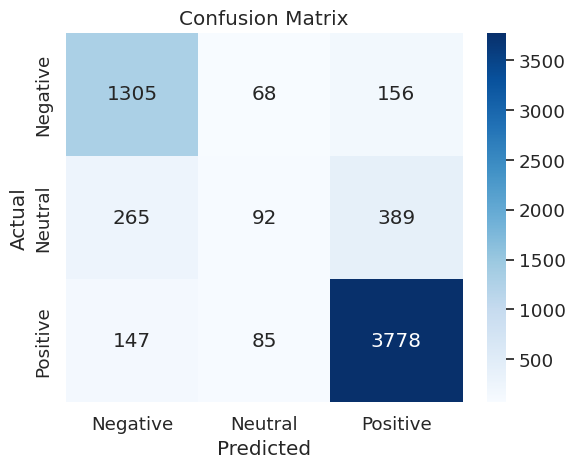

In [58]:
plot_confusion_matrix(long_reviews_y_test, long_reviews_predictions)

## Analysing short text reviews

In [59]:
short_text_dataset = evaluation_data.filter(lambda review: len(review['text']) <= max_length)

In [ ]:
short_reviews_predictions = model(short_text_dataset["text"])
short_reviews_y_test = short_text_dataset["label"]

In [ ]:
plot_confusion_matrix(short_reviews_y_test, short_reviews_predictions)

In [ ]:
# model_checkpoint = "noahnsimbe/DistilBERT-yelp-sentiment-analysis"
# model_v1 = pipeline("text-classification", model=model_checkpoint)

In [ ]:
# long_reviews_predictions = model_v1(long_text_dataset["text"])

In [ ]:
# plot_confusion_matrix(long_reviews_y_test, long_reviews_predictions)

In [ ]:
# short_reviews_predictions = model_v1(short_text_dataset["text"])

In [ ]:
# plot_confusion_matrix(short_reviews_y_test, short_reviews_predictions)